In [6]:
import numpy as np
import pandas as pd
import os
import matplotlib
matplotlib.rc('font', size = 12, weight = 'light')
matplotlib.rc('xtick', labelsize = 11)
matplotlib.rc('ytick', labelsize = 11)
matplotlib.rc('legend', fontsize = 11)
matplotlib.rc('axes', labelsize = 12, labelweight='bold', titleweight = 'bold')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import subprocess
import re
import pickle
from numba import njit
import time
import seaborn as sns

#import PySide6.QtWidgets
#app = PySide6.QtWidgets.QApplication() # Needed to print ovito renderings on screen

from ovito.io import *
from ovito.modifiers import *
from ovito.data import *
from ovito.pipeline import *
from ovito.vis import *
import PySide6.QtCore
import os.path

plt.rcParams.update({'font.size': 12})
import matplotlib.patheffects as pe

In [7]:
def getparams(pattern):
    r1 = re.compile('[_]')
    r2 = re.compile(r'(([-+]?\d+\.\d+)|([-+]?\d+))')
    r3 = re.compile('[-]')
    pattern = pattern.split()[0]
    #pattern = pattern.decode("utf-8")
    
    # Default params
    ts=-1
    real=-1
    Rcylin=-1
    Rcylout=-1
    Rring = -1
    geometry =''
    Lz=-1
    RN = 0
    pAN = 0
    pNN = 0
    pP = 0
    pB = 0
    pS = 0
    pD = 0
    pMA = 0
    pMW = 0
    pMD = 0
    pMDE = 0
    pCA=0
    pCD=0
    pMOC = 0
    nM=0
    nC=0
    eAA=0
    Lx=0
    
    # Read params
    for s in r1.split(pattern):
        if s.startswith('rw'):
            geometry = 'rw'
        elif s.startswith('cw'):
            geometry = 'cw'
        elif s.startswith('r'):
            s3 = s[1:]
            Rcylin = float(r3.split(s3)[0])
            Rcylout = float(r3.split(s3)[1])
            try:
                Rring = float(r3.split(s3)[2])
            except:
                pass
        if s.startswith('Lz'):
            Lz = float(r2.split(s)[1])
        if s.startswith('Lx'):
            Lx = float(r2.split(s)[1])    
        if s.startswith('eAA'):
            eAA = float(r2.split(s)[1])
        if s.startswith('nF'):
            s3 = s[2:]
            nF = int(r3.split(s3)[0])
            lF = int(r3.split(s3)[1])
        if s.startswith('nM'):
            nM = int(r2.split(s)[1])
        if s.startswith('nC'):
            nC = int(r2.split(s)[1])
        if s.startswith('R'):
            s3 = s[1:]
            RN = int(r3.split(s3)[0])
            pAN = float(r3.split(s3)[1])
            pNN = float(r3.split(s3)[2])
            pP = float(r3.split(s3)[3])
            pB = float(r3.split(s3)[4])
            pS = float(r3.split(s3)[5])
            pD = float(r3.split(s3)[6])
            pMA = float(r3.split(s3)[7])
            pMW = float(r3.split(s3)[8])
            pMD = float(r3.split(s3)[9])
            pMDE = float(r3.split(s3)[10])  
            pCA =float(r3.split(s3)[11])
            pCD =float(r3.split(s3)[12])
            pMOC = float(r3.split(s3)[13])  
        if s[0].isdigit():
            real=int(s)
    
    return {'geom':geometry, 'Rcylin':Rcylin, 'Rcylout':Rcylout, 'Rring':Rring, 'Lz':Lz, 'eAA':eAA, 'nF':nF, 'lF':lF, 'nM':nM, 'nC':nC, 'RN':RN, 
            'pAN':pAN,'pNN':pNN,'pP':pP,'pB':pB,'pS':pS,'pD':pD,'pMA':pMA,'pMW':pMW,'pMD':pMD,'pMDE':pMDE,'pCA':pCA,'pCD':pCD,'pMOC':pMOC,
            'real':real}


In [8]:
def sortbyparams(key):
    p = getparams(key)
    return 1e5*p['lF']+p['nM']

In [9]:
def nM2color(nM):
    if nM==19200:
        return 'black'
    if nM==9600:
        return 'navy'
    elif nM==4800:
        return 'royalblue'
    elif nM==2400:
        return 'teal'
    elif nM==1200:
        return 'forestgreen'
    elif nM==600:
        return 'green'
    elif nM==300:
        return 'lime'
    else:
        assert False, 'nM={} not in color palette nM2color'.format(nM)
    

In [10]:
def bin2midpoint(edges):
    return [0.5*(edges[i]+edges[i+1]) for i in range(0,len(edges)-1)]

In [11]:
@njit
def ThetaDiff(th1,th2):
    a = abs(th1-th2)
    if a<np.pi:
        return a
    else:
        return 2*np.pi-a

@njit
def ThetaOverlap(Th1,Th2,ThetaTolerance):
    for th1 in Th1:
        for th2 in Th2:
            if ThetaDiff(th1,th2)<ThetaTolerance:
                return True
    return False

@njit
def zDiffAbs(z1,z2,Lz):
    a = abs(z1-z2)
    if a<0.5*Lz:
        return a
    else:
        return Lz-a
    
@njit
def Distance2_ffp(p,q,Lz):
    assert len(p)==3
    assert len(q)==3
    a = (p[0]-q[0])**2 + (p[1]-q[1])**2 + (zDiffAbs(p[2],q[2],Lz))**2
    return a

@njit
def zDiffSigned(z1,z2,Lz):
    a = (z1-z2)
    if abs(a)<0.5*Lz:
        return a
    elif a<-0.5*Lz:
        return a+Lz
    else:
        return a-Lz

@njit
def zDiffSigned0(a,Lz):
    if abs(a)<0.5*Lz:
        return a
    elif a<-0.5*Lz:
        return a+Lz
    else:
        return a-Lz
    


# Traj analysis

In [12]:
# Look for all Traj files
folder='/home/alessandro/ISTA/ivan_original/Test_B15__Alessandro/Test_B15__Alessandro'
MMbondLength =10


filestringList = subprocess.check_output("ls {:s}/Results/Traj_rw_r0-*_Lz*_nF*-*_nM*_2[0-1][0-9].xyz | sed 's/.*Traj_//' | sed 's/.xyz//' ".format(folder), shell=True)
#filestringList = subprocess.check_output("ls {:s}/Results/Traj_cw_r*_Lz*_nF*-*_nM*_1[1-9][0-9].xyz | sed 's/.*Traj_//' | sed 's/.xyz//' ".format(folder), shell=True)
filestringList=filestringList.split()
filestringList=[a.decode("utf-8") for a in filestringList]
for f in filestringList:
    print(f)
    print(getparams(f))


ls: cannot access '/home/alessandro/ISTA/ivan_original/Test_B15__Alessandro/Test_B15__Alessandro/Results/Traj_rw_r0-*_Lz*_nF*-*_nM*_2[0-1][0-9].xyz': No such file or directory


In [13]:
# read dictionary 
#with open('{:s}/Analysis/dicR.pickle'.format(folder), 'rb') as file:
dicR={}
with open('/home/alessandro/ISTA/ivan_original/Test_B15__Alessandro/Test_B15__Alessandro/Analysis/dicR.pickle','rb') as file:
    dicR=pickle.load(file)
dicR.keys()

dict_keys(['rw_r0-250-200_Lz10.0_nF100-10_nM200_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_204', 'rw_r0-250-200_Lz10.0_nF350-70_nM4900_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_204', 'rw_r0-250-200_Lz10.0_nF400-50_nM9600_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00016-0-0-0_204', 'rw_r0-250-200_Lz10.0_nF240-50_nM1200_nC500_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0.1-0.00001-0_215', 'rw_r0-250-200_Lz10.0_nF400-50_nM300_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.000005-0-0-0_204', 'rw_r0-250-200_Lz5.0_nF150-50_nM0_nC400_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0.1-0.0001-0_208', 'rw_r0-250-200_Lz10.0_nF240-50_nM1200_nC500_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0.1-0.00001-1_211', 'rw_r0-250-200_Lz10.0_nF400-50_nM300_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_204', 'rw_r0-250-200_Lz5.0_nF150-50_nM0_nC400_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0.1-0.001-0_208', 'rw_r0-250-200_Lz10.0_nF240-50_nM1200_nC500_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0.1-0.00001-1_216', 'rw_r0-250-200_Lz10.0_nF400-50_nM300_nC0_R10-0-0-0-0-0-0-0.1-1

In [14]:
def addLocalFilamentDirection(dfm, Lz):
    assert len(dfm.Molec.unique())==1 # all atoms belong to same filament
    dfm = dfm.sort_values(by='PolyTime',ascending=True)
    Directionx = dfm.x.values[:-1]-dfm.x.values[1:]          # Direction goes from Barbed to Pointed end
    Directiony = dfm.y.values[:-1]-dfm.y.values[1:]
    Directionz = dfm.z.values[:-1]-dfm.z.values[1:]
    Directionz = [ zDiffSigned0(z,Lz) for z in Directionz ]
    Direction = np.array([Directionx, Directiony, Directionz]).transpose()
    Direction = np.append(Direction,[Direction[-1]],axis=0)
    Direction = [np.array(d) for d in Direction]
    dfm['Direction'] = Direction
    return dfm


def globalFilamentDirection(dfm, Lz):
    assert len(dfm.Molec.unique())==1 # all atoms belong to same filament
    dfm = dfm.sort_values(by='PolyTime',ascending=True)
    Directionx = dfm.x.values[0]-dfm.x.values[-1]          # Direction goes from Barbed [-1] to Pointed end [0]
    Directiony = dfm.y.values[0]-dfm.y.values[-1]
    Windingz = 0
    z = dfm.z.values
    Lzhalf = 0.5*Lz
    for k in range(len(z)-1):
        if z[k]>Lzhalf and z[k+1]<-Lzhalf:
            Windingz += 1
        elif z[k]<-Lzhalf and z[k+1]>Lzhalf:
            Windingz -= 1
    Directionz = dfm.z.values[0]-(dfm.z.values[-1]+(Windingz*Lz))
    return np.array([Directionx, Directiony, Directionz])


@njit
def countcontacts(dm1,dm2,Distance2Tolerance,ThetaScreeningTolerance,Dir1,Dir2,lF):
    ContactDummyCounter = 0
    ContactCounter = [0,0,0]
    for ja1, a1 in enumerate(dm1):
        for ja2, a2 in enumerate(dm2):
            if ThetaDiff(a1[4],a2[4]) < ThetaScreeningTolerance :     # [4] is ThetaRad
                if Distance2_ffp([a1[1],a1[2],a1[3]],[a2[1],a2[2],a2[3]],Lz) < Distance2Tolerance :     # [1] is x, [2] is y, [3] is z
                    ContactDummyCounter += 1
                    break
    if ContactDummyCounter ==0:
        return ContactCounter
    if np.sign( np.dot(Dir1,Dir2) ) >= 0:    # [5] is Directionx, [6] is Directiony, [7] is Directionz
        ContactFlag = 0    # Parallel 
    else:
        p1 = dm1[0]  # Pointed end of molecule 1
        b1 = dm1[-1] # Barbed end of molecule 1
        p2 = dm2[0]  # Pointed end of molecule 2
        b2 = dm2[-1] # Barbed end of molecule 2
        if Distance2_ffp([p1[1],p1[2],p1[3]],[p2[1],p2[2],p2[3]],Lz) > Distance2_ffp([b1[1],b1[2],b1[3]],[b2[1],b2[2],b2[3]],Lz) : # distance between pointed ends > barbed ends
            ContactFlag=1    # AntiParallelExtensile
            #print("extensile")
        else:
            ContactFlag=2    # AntiParallelContractile
            #print("contractile")
    ContactCounter[ContactFlag] += ContactDummyCounter     # ContactCounter only counts contacts of molecule 1
    return ContactCounter

def MMbond_boundtosamefilaments(dfBondMM,dfBondMM_Reference):
    return dfPart.loc[dfBondMM.TopologyA]['MolecA_Mpart']

In [15]:
@njit
def is_permuation_matrix(x):
    return (x.ndim == 2 and x.shape[0] == x.shape[1] and
            (x.sum(axis=0) == 1).all() and 
            (x.sum(axis=1) == 1).all() and
            ((x == 1) | (x == 0)).all())

@njit
def which_indeces_merge(Matrix):
    if is_permuation_matrix(Matrix):
        return np.array([0,0,-1],dtype=np.int64) # do not sum
    for i in range(Matrix.shape[0]):
            for j1 in range(Matrix.shape[1]):
                for j2 in range(j1+1, Matrix.shape[1]):
                    if Matrix[i,j1]*Matrix[i,j2]==1:
                        return np.array([j1,j2,1],dtype=np.int64) # sum columns
    for j in range(Matrix.shape[1]):
            for i1 in range(Matrix.shape[0]):
                for i2 in range(i1+1, Matrix.shape[0]):
                    if Matrix[i1,j]*Matrix[i2,j]==1:
                        return np.array([i1,i2,0],dtype=np.int64) # sum rows 
    return np.array([0,0,-2],dtype=np.int64) # error

'''def which_indeces_merge(Matrix):
    if is_permuation_matrix(Matrix):
        return [] # do not sum
    for i in range(Matrix.shape[0]):
            for j1 in range(Matrix.shape[1]):
                for j2 in range(j1+1, Matrix.shape[1]):
                    if Matrix[i,j1]*Matrix[i,j2]==1:
                        return [j1,j2,1] # sum columns
    for j in range(Matrix.shape[1]):
            for i1 in range(Matrix.shape[0]):
                for i2 in range(i1+1, Matrix.shape[0]):
                    if Matrix[i1,j]*Matrix[i2,j]==1:
                        return [i1,i2,0] # sum rows '''

def mergeclusters(AdjacencyMatrix):
    clusterdic = 0*AdjacencyMatrix
    Matrix = AdjacencyMatrix
    # Initialise tracking
    Mx, My = Matrix.shape
    Tracker = [ [ [[i,j]] for j in range(My)] for i in range(Mx) ]
    for i in range(Mx):
        for j in range(My):
            if AdjacencyMatrix[i,j]==0:
                Tracker[i][j]=[]
    # Reduce matrix
    indeces = which_indeces_merge(Matrix)
    while(indeces[2]>=0):
        Mx, My = Matrix.shape
        #print(indeces)
        if indeces[2]==1: # sum columns, ie multiply Matrix~(Mx,My) by Mult~(My,My-1) to get NewMatrix~(Mx,My-1) 
            j1, j2 = indeces[:2]
            Mult = np.zeros( (My, My-1), dtype=int)
            for j in range(My):
                if j<j2:
                    Mult[j,j]=1
                elif j==j2:
                    Mult[j2,j1]=1
                else:
                    Mult[j,j-1]=1
            NewMatrix = np.sign(np.dot(Matrix,Mult)) # performs logic OR of columns j1 and j2
            # Update tracker
            '''NewTracker = [ [[] for j in range(My-1)] for i in range(Mx)] 
            for i in range(Mx):
                for j in range(My):
                    if j<j2:
                        NewTracker[i][j] += Tracker[i][j]
                    elif j==j2:
                        NewTracker[i][j1] += Tracker[i][j2]
                    else:
                        NewTracker[i][j-1] += Tracker[i][j]'''
            NewTracker = [[ Tracker[i][j] if (j<j2 and j!=j1)   else   Tracker[i][j1]+Tracker[i][j2] if j==j1   else   Tracker[i][j+1]   for j in range(My-1)] for i in range(Mx)]
            Matrix = NewMatrix
            Tracker = NewTracker
        
        if indeces[2]==0: # sum rows, ie multiply Mult~(Mx-1,Mx) Matrix~(Mx,My) to get NewMatrix~(Mx-1,My) 
            i1, i2 = indeces[:2]
            Mult = np.zeros( (Mx-1, Mx), dtype=int)
            for i in range(Mx):
                if i<i2:
                    Mult[i,i]=1
                elif i==i2:
                    Mult[i1,i2]=1
                else:
                    Mult[i-1,i]=1
            NewMatrix = np.sign(np.dot(Mult,Matrix))
            # Update tracker
            '''NewTracker = [ [[] for j in range(My)] for i in range(Mx-1)] 
            for i in range(Mx):
                for j in range(My):
                    if i<i2:
                        NewTracker[i][j] += Tracker[i][j]
                    elif i==i2:
                        NewTracker[i1][j] += Tracker[i2][j]
                    else:
                        NewTracker[i-1][j] += Tracker[i][j]'''
            NewTracker = [[ Tracker[i][j] if (i<i2 and i!=i1)   else   Tracker[i1][j]+Tracker[i2][j] if i==i1   else   Tracker[i+1][j]   for j in range(My)] for i in range(Mx-1)]
            Matrix = NewMatrix
            Tracker = NewTracker

        indeces = which_indeces_merge(Matrix)
    
    assert is_permuation_matrix(Matrix) # Then also Tracker is 'permutation-like' and I can only extract the one non-empty element from its rows (or columns)
    ClusterMap = [ [] for row in Tracker ]
    for i,row in enumerate(Tracker):
        for j,el in enumerate(row):
            if len(el)>0:
                for jj in range(len(row)):
                    if jj!=j:
                        assert len(row[jj])==0, 'ERROR: Tracker is not permutation-like'
                ClusterMap[i] = el
                
    return ClusterMap

In [16]:
#Colorplot e funzioni da plottare
import seaborn as sns
def ale_colorplot(x_values,y_values,F,cmap,vmin,vmax,g=None,ax=None,lab = '',l=.92,b=.2,w=.03,h=.65, logay = False, logax = False, ymin = None,ymax = None, xmin = None,xmax = None, hatch= None):
    if g == None:
        g, ax = plt.subplots(1,1)
    f = np.zeros((len(y_values),len(x_values)))
    for i in range(len(y_values)):
        for j in range(len(x_values)):
            f[i,j] = F(x_values[j],y_values[i])
    X_grid, Y_grid = np.meshgrid(np.array(x_values).astype(np.float64),np.array(y_values).astype(np.float64))
    p = ax.pcolor(X_grid,Y_grid,f,cmap = cmap, vmin = vmin, vmax = vmax, shading = 'auto', hatch = hatch)
    if logax:
        ax.set_xscale('log')
        ax.set_xlim([xmin,xmax])
        ax.set_xticks([], minor = True)
        #print([float(y_values[i]) for i in range(len(y_values))])
        ax.set_xticks([float(x_values[i]) for i in range(len(x_values))],[str(x_values[i]) for i in range(len(x_values))])
    if logay:
        ax.set_yscale('log')
        ax.set_ylim([ymin,ymax])
        ax.set_yticks([], minor = True)
        #print([float(y_values[i]) for i in range(len(y_values))])
        ax.set_yticks([float(y_values[i]) for i in range(len(y_values))],[str(y_values[i]) for i in range(len(y_values))])
    g.figure.subplots_adjust(right=l)
    cax = g.figure.add_axes([l+0.02,b,w,h])
    points = plt.scatter(x=[],y=[],c=[],cmap = cmap, vmin = vmin, vmax = vmax)
    g.figure.colorbar(points,cax = cax,label = lab)
    return cax

def ale_3dplot(x_values,y_values,F,g,ax,logay = False, logax = False, ymin = None,ymax = None, xmin = None,xmax = None):

    f = np.zeros((len(y_values)*len(x_values)))
    X = np.zeros((len(y_values)*len(x_values)))
    Y = np.zeros((len(y_values)*len(x_values)))
    for i in range(len(y_values)):
        for j in range(len(x_values)):
            try: 
                f[i*len(x_values)+j] = F(x_values[j],y_values[i])
            except: continue
            X[i*len(x_values)+j] = x_values[j]
            Y[i*len(x_values)+j] = y_values[i]
    ax.scatter(X,Y,f)
    if logax:
        ax.set_xscale('log')
        ax.set_xlim([xmin,xmax])
    if logay:
        ax.set_yscale('log')
        ax.set_ylim([ymin,ymax])
    return g, ax

def ale_Ravg(key, timestep):
    for id, row in dicR[key].iterrows():
        if row['time'] > timestep:
            return row['Ravg']
        
def ale_PercFrac(key, timestep):
    for id, row in dicR[key].iterrows():
        if row['time'] > timestep:
            return row['PercolatedFraction']

def ale_rate_constrict(key,timestep_max):
    data_temp = dicR[key][dicR[key]['time']<=timestep_max]
    m, q = np.polyfit(x = data_temp['time'],y = data_temp['Ravg'],deg = 1)
    return m

def ale_jammed(key,timestep):
    nM_temp = getparams(key)['nM']
    for id, row in dicR[key].iterrows():
        if row['time'] > timestep:
            return row['JammedDoubleBoundMyosins']
        
def ale_actin_jammed(key,timestep):
    for id, row in dicR[key].iterrows():
        if row['time'] > timestep:
            return row['JammedActins']
        
def ale_not_jammed(key,timestep):
    nM_temp = getparams(key)['nM']
    for id, row in dicR[key].iterrows():
        if row['time'] > timestep:
            return (np.sum(row['histDoubleBoundMDistrAlongActin'][1])-row['JammedDoubleBoundMyosins'])

def ale_relevant_myosins(key,timestep):
    nM_temp = getparams(key)['nM']
    for id, row in dicR[key].iterrows():
        if row['time'] > timestep:
            """print(row['DoubleBoundOnejammedParallelMM'])
            print(row['DoubleBoundOnejammedAntiparallelMM'])
            print(row['DoubleBoundNeitherjammedAntiparallelMM'])"""
            return row['DoubleBoundOnejammedParallelMM']+row['DoubleBoundOnejammedAntiparallelMM']+2*row['DoubleBoundNeitherjammedAntiparallelMM']
                
def ale_avgspeed(key):
    return dicR[key]['MSpeedAvg'].mean()

def ale_notjammedavgspeed(key):
    return dicR[key]['MSpeedNotjammedAvg'].mean()

def ale_ring_intact_flag(key,timestep=4000000):
    for id, row in dicR[key].iterrows():
        if row['time'] > timestep:
            return row['RingIntactFlag']
        
def ale_endtoend(key, timestep = 4000000):
    return np.nanmean(dicR[key][dicR[key]['time']<=timestep]['EndtoendDistanceIn'])/getparams(key)['lF']

def ale_endtoend_ratio(key, timestep = 4000000):
    return np.nanmean(dicR[key][dicR[key]['time']<=timestep]['EndtoendDistanceBonded'])/np.nanmean(dicR[key][dicR[key]['time']<=timestep]['EndtoendDistance'])

def ale_myosin_speed(key, timestep = 4000000, sector = False):
    df_temp = dicR[key][dicR[key]['time']<=timestep]
    """a, ax = plt.subplots(1,1)
    ax.plot(df_temp['MSpeedAntiparallelNotjammedAvg'][1:])
    plt.show()"""
    #print([row['MSpeedAntiparallelNotjammedAvg'] if np.isnan(row['MSpeedRelevantAvg']) else row['MSpeedRelevantAvg'] for id, row in df_temp.iterrows()])
    try: return np.nanmean([row['MSpeedAntiparallelNotjammedAvg'] if np.isnan(row['MSpeedRelevantAvg']) else row['MSpeedRelevantAvg'] for id, row in df_temp.iterrows()][1:])
    except: return np.nanmean(df_temp['MSpeedNotjammedAvg'])

def ale_conf_prob(key, timestep):
    par_temp = getparams(key)
    for id, row in dicR[key].iterrows():
        if row['time'] > timestep:
            Leff = par_temp['lF']-row['JammedDoubleBoundMyosins']/par_temp['nF']
            #print(f'Leff {Leff}')
            return (1.-np.exp(-ale_jammed(key,timestep)/par_temp['nF']))*(1.-np.exp(-ale_relevant_myosins(key,timestep)/par_temp['nF']))

In [17]:
def build_key(Lz_temp = '10.0',lF_temp = 50, nF_temp=400,nM_temp=4800,pMW_temp = '1',pMDE_temp='0.00001', nC_temp = 0, pCA_temp = '0', pCD_temp = '0', pMOC_temp = '0', sd = 204, sector = False):
    key = 'rw_r0-250-200_Lz'+Lz_temp+'_nF'+str(nF_temp)+'-'+str(lF_temp)+'_nM'+str(nM_temp)+'_nC'+str(nC_temp)+'_R10-0-0-0-0-0-0-0.1-'+pMW_temp+'-0.00001-'+pMDE_temp+'-'+pCA_temp+'-'+pCD_temp+'-'+pMOC_temp+'_'+str(sd)
    if sector: return "Sector_"+key
    return key

In [13]:
for key in dicR.keys():
    if getparams(key)['real'] == 217:# or getparams(key)['real'] == 216:
        print(key)

rw_r0-250-200_Lz10.0_nF400-50_nM300_nC1000_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0.1-0.00001-1_217
rw_r0-250-200_Lz10.0_nF400-50_nM300_nC2000_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0.1-0.00001-1_217
rw_r0-250-200_Lz10.0_nF400-50_nM300_nC4000_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0.1-0.00001-1_217
rw_r0-250-200_Lz10.0_nF400-50_nM300_nC8000_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0.1-0.00001-1_217
rw_r0-250-200_Lz10.0_nF400-50_nM600_nC1000_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0.1-0.00001-1_217
rw_r0-250-200_Lz10.0_nF400-50_nM600_nC2000_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0.1-0.00001-1_217
rw_r0-250-200_Lz10.0_nF400-50_nM600_nC4000_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0.1-0.00001-1_217
rw_r0-250-200_Lz10.0_nF400-50_nM600_nC8000_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0.1-0.00001-1_217
rw_r0-250-200_Lz10.0_nF400-50_nM1200_nC1000_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0.1-0.00001-1_217
rw_r0-250-200_Lz10.0_nF400-50_nM1200_nC2000_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0.1-0.00001-1_217
rw_r0-250-200_Lz10.0_nF400-50_nM1200_nC4000_R10-0-0-0-0-0-0-0.1-1-0.

# Myosin population

In [213]:
print(key)

rw_r0-250-200_Lz10.0_nF400-50_nM4800_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_204


In [214]:
df_temp = dicR[key]

In [228]:
df_temp['DoubleBoundBothjammedAntiparallelMM'] = df_temp['DoubleBoundAntiparallelMM']-df_temp['DoubleBoundNeitherjammedAntiparallelMM']-df_temp['DoubleBoundOnejammedAntiparallelMM']
df_temp['DoubleBoundBothjammedParallelMM'] = df_temp['DoubleBoundParallelMM']-df_temp['DoubleBoundNeitherjammedParallelMM']-df_temp['DoubleBoundOnejammedParallelMM']

0    100000
Name: time, dtype: int64
Line2D(_child0)


/tmp/ipykernel_121702/1074138590.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Both dwelling \n Antiparallel','Both dwelling \n Parallel','One dwelling \n Antiparallel','One dwelling \n Parallel','Neither dwelling \n Antiparallel','Neither dwelling \n Parallel'])


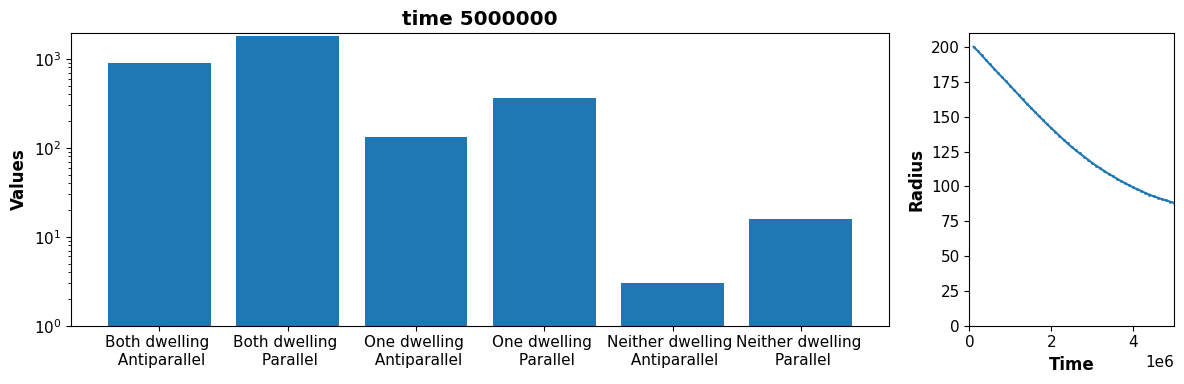

In [229]:
from matplotlib.animation import FuncAnimation

df = df_temp[['DoubleBoundBothjammedAntiparallelMM','DoubleBoundBothjammedParallelMM','DoubleBoundOnejammedAntiparallelMM','DoubleBoundOnejammedParallelMM','DoubleBoundNeitherjammedAntiparallelMM','DoubleBoundNeitherjammedParallelMM']]
# Ensure the default Seaborn style is applied for better visuals
#sns.set(style='whitegrid')

# Create a figure and axis
fig, [ax,ax2] = plt.subplots(1,2,width_ratios=(4,1))

# Define the number of rows (frames) and the categories (columns)
categories = df.columns
n_frames = len(df)

# Initialize a bar plot
bars = ax.bar(categories, df.iloc[0])
print(df_temp[df_temp['time']<=df_temp.iloc[0]['time']]['time'])
Rplot = ax2.plot(df_temp[df_temp['time']<=df_temp.iloc[0]['time']]['time'],df_temp[df_temp['time']<=df_temp.iloc[0]['time']]['Ravg'], marker = '.', markersize = 2)[0]
print(Rplot)
# Set up labels and limits
ax2.set_ylim(0, 210)
ax2.set_xlim(0,np.max(df_temp['time']))
ax2.set_ylabel('Radius')
ax2.set_xlabel('Time')
ax.set_ylim(1, df.max().max())  # Ensure y-axis covers the max value in the DataFrame
ax.set_title(f"time {df_temp.iloc[0]['time']}")
ax.set_ylabel('Values')
ax.set_xticklabels(['Both dwelling \n Antiparallel','Both dwelling \n Parallel','One dwelling \n Antiparallel','One dwelling \n Parallel','Neither dwelling \n Antiparallel','Neither dwelling \n Parallel'])
ax.set_yscale('log')
fig.figure.set_figwidth(12)
fig.figure.set_figheight(4)
# Function to update the bars in each frame
def update(frame):
    for bar, new_val in zip(bars, df.iloc[frame]):
        bar.set_height(new_val)
    ax.set_title(f"time {df_temp.iloc[frame]['time']}")
    Rplot.set_xdata(df_temp[df_temp['time']<=df_temp.iloc[frame]['time']]['time'])
    Rplot.set_ydata(df_temp[df_temp['time']<=df_temp.iloc[frame]['time']]['Ravg'])
# Create the animation
ani = FuncAnimation(fig, update, frames=n_frames, repeat=False)
plt.tight_layout()
ani.save(filename="prova.gif", writer="pillow")
# Show the plot
plt.show()
#sns.set(style='white')

# lF nF

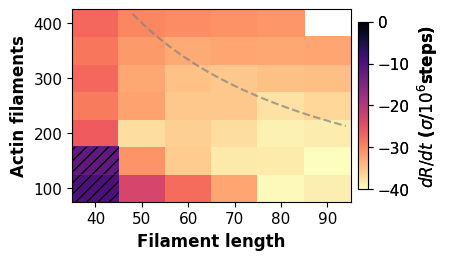

In [230]:
#Constriction rate
lFs = np.array([40,50,60,70,80,90])
nFs = np.array([100,150,200,250,300,350,400])
g, ax2 = plt.subplots(1,1, sharex=True)
timestep_temp= 2000000
ax2.plot(np.linspace(48,94,100), 20000/np.linspace(48,94,100), alpha = 0.7,c='gray', linestyle = '--')
cmap = sns.color_palette('magma_r',as_cmap = True)
def rate_temp(lF_temp,nF_temp):
    try: 
        key = build_key(lF_temp = lF_temp, nF_temp = nF_temp, nM_temp = int(nF_temp*lF_temp/5))
        if ale_PercFrac(key,timestep_temp) > 0.8:
            return 1000000*ale_rate_constrict(key,timestep_temp)
        else: return np.nan
    except KeyError: return np.nan
def rate_temp_broken(lF_temp,nF_temp):
    try: 
        key = build_key(lF_temp = lF_temp, nF_temp = nF_temp, nM_temp = int(nF_temp*lF_temp/5))
        if not ale_PercFrac(key,timestep_temp) > 0.8:
            return 1000000*ale_rate_constrict(key,timestep_temp)
        else: return np.nan
    except KeyError: return np.nan
ale_colorplot(lFs,nFs,rate_temp,cmap,-4*10**(1),-0,g=g,ax=ax2,l=.92,b=.16,w=.03,h=.67,lab='$dR/dt$ ($\sigma$/$10^6$steps)')
ale_colorplot(lFs,nFs,rate_temp_broken,cmap,-4*10**(1),-0,g=g,ax=ax2,l=.92,b=.16,w=.03,h=.67,lab='$dR/dt$ ($\sigma$/$10^6$steps)',hatch='///')
ax2.set_ylabel('Actin filaments')
ax2.set_xlabel('Filament length')
g.figure.set_figwidth(3.5)
g.figure.set_figheight(2.5)
plt.show()

Probability of ring intact at time 0

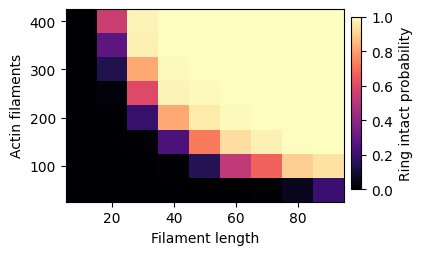

rw_r0-250-200_Lz10.0_nF400-90_nM7200_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_204


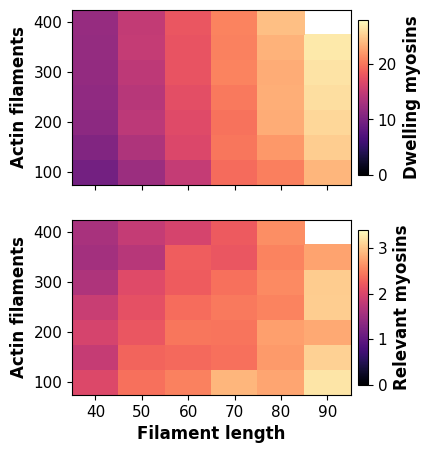

In [231]:
#Jammed filaments and not jammed motors
lFs = np.array([40,50,60,70,80,90])
nFs = np.array([100,150,200,250,300,350,400])

g, [ax2, ax3] = plt.subplots(2,1, sharex=True)
timestep_temp= 2000000

cmap = sns.color_palette('magma',as_cmap = True)
def jammed_temp(lF_temp,nF_temp):
    key = build_key(lF_temp = lF_temp, nF_temp = nF_temp, nM_temp = int(nF_temp*lF_temp/5))
    try: return ale_jammed(key,timestep_temp)/getparams(key)['nF']
    except KeyError: return np.nan
ale_colorplot(lFs,nFs,jammed_temp,cmap,0,28,g=g,ax=ax2,l=.92,b=.55,w=.03,h=.31,lab='Dwelling myosins')

cmap = sns.color_palette('magma',as_cmap = True)
def not_jammed_temp(lF_temp,nF_temp):
    key = build_key(lF_temp = lF_temp, nF_temp = nF_temp, nM_temp = int(nF_temp*lF_temp/5))
    try: 
        #print(ale_relevant_myosins(key,timestep_temp))
        return ale_relevant_myosins(key,timestep_temp)/getparams(key)['nF']
    except KeyError: 
        print(key)
        return np.nan
ale_colorplot(lFs,nFs,not_jammed_temp,cmap,0,3.4,g=g,ax=ax3,l=.92,b=.13,w=.03,h=.31,lab='Relevant myosins')

ax3.set_ylabel('Actin filaments')
ax2.set_ylabel('Actin filaments')
ax3.set_xlabel('Filament length')
g.figure.set_figwidth(3.5)
g.figure.set_figheight(5)
plt.show()

rw_r0-250-200_Lz10.0_nF400-90_nM7200_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_204


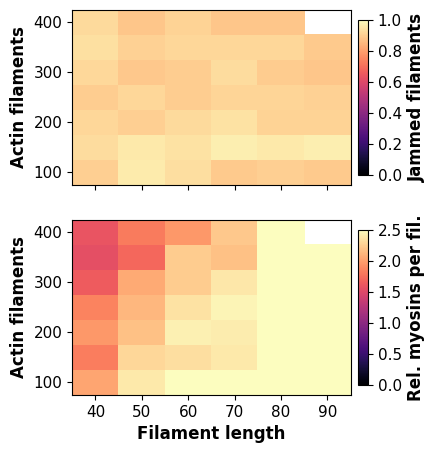

In [232]:
#Jammed filaments and not jammed motors
lFs = np.array([40,50,60,70,80,90])
nFs = np.array([100,150,200,250,300,350,400])

g, [ax2, ax3] = plt.subplots(2,1, sharex=True)
timestep_temp= 2000000

cmap = sns.color_palette('magma',as_cmap = True)
def actin_jammed_temp(lF_temp,nF_temp):
    key = build_key(lF_temp = lF_temp, nF_temp = nF_temp, nM_temp = int(nF_temp*lF_temp/5))
    try: return ale_actin_jammed(key,timestep_temp)/getparams(key)['nF']
    except KeyError: return np.nan
ale_colorplot(lFs,nFs,actin_jammed_temp,cmap,0,1,g=g,ax=ax2,l=.92,b=.55,w=.03,h=.31,lab='Jammed filaments')

cmap = sns.color_palette('magma',as_cmap = True)
def not_jammed_temp(lF_temp,nF_temp):
    key = build_key(lF_temp = lF_temp, nF_temp = nF_temp, nM_temp = int(nF_temp*lF_temp/5))
    try: 
        #print(ale_relevant_myosins(key,timestep_temp))
        return ale_relevant_myosins(key,timestep_temp)/getparams(key)['nF']
    except KeyError: 
        print(key)
        return np.nan
ale_colorplot(lFs,nFs,not_jammed_temp,cmap,0,2.5,g=g,ax=ax3,l=.92,b=.13,w=.03,h=.31,lab='Rel. myosins per fil.')

ax3.set_ylabel('Actin filaments')
ax2.set_ylabel('Actin filaments')
ax3.set_xlabel('Filament length')
g.figure.set_figwidth(3.5)
g.figure.set_figheight(5)
plt.show()

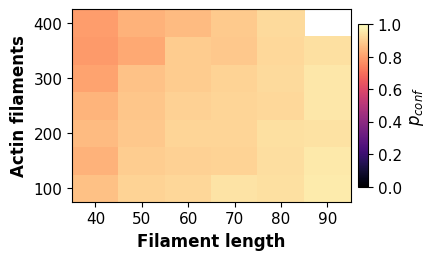

In [233]:
#Configuration probability
g, ax1 = plt.subplots(1,1, sharex=True)
lFs = np.array([40,50,60,70,80,90])
nFs = np.array([100,150,200,250,300,350,400])
#lFs = np.array([40,50,60,70,80,90])
#nFs = np.array([100,150,200,250,300,350,400])
cmap = sns.color_palette('magma',as_cmap = True)
def conf_prob_temp(lF_temp,nF_temp):
    try: return ale_conf_prob(build_key(lF_temp = lF_temp, nF_temp = nF_temp, nM_temp = int(nF_temp*lF_temp/5)),timestep_temp)
    except KeyError: return np.nan
ale_colorplot(lFs,nFs,conf_prob_temp,cmap,0,1,g=g,ax=ax1,l=.92,b=.17,w=.03,h=.65,lab='$p_{conf}$')

ax1.set_ylabel('Actin filaments')
ax1.set_xlabel('Filament length')

g.figure.set_figwidth(3.5)
g.figure.set_figheight(2.5)

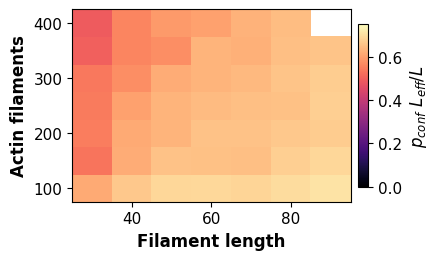

In [234]:
#Configuration probability times Leff
g, ax1 = plt.subplots(1,1, sharex=True)
lFs = np.array([30,40,50,60,70,80,90])
nFs = np.array([100,150,200,250,300,350,400])
timestep_temp = 2000000
cmap = sns.color_palette('magma',as_cmap = True)
def conf_prob_temp(lF_temp,nF_temp):
    key = build_key(lF_temp = lF_temp, nF_temp = nF_temp, nM_temp = int(nF_temp*lF_temp/5))
    try: return ale_conf_prob(key,timestep_temp)*(getparams(key)['lF']-ale_jammed(key,timestep_temp)/getparams(key)['nF'])/getparams(key)['lF']
    except KeyError: return np.nan
ale_colorplot(lFs,nFs,conf_prob_temp,cmap,0,0.75,g=g,ax=ax1,l=.92,b=.17,w=.03,h=.65,lab='$p_{conf}$ $L_{eff}/L$')

ax1.set_ylabel('Actin filaments')
ax1.set_xlabel('Filament length')

g.figure.set_figwidth(3.5)
g.figure.set_figheight(2.5)

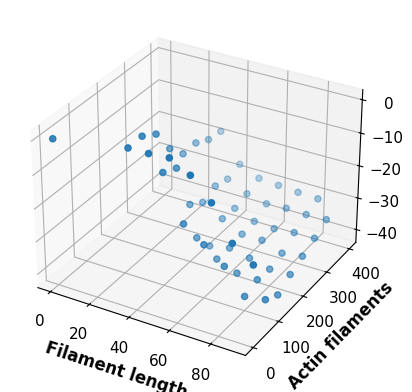

In [235]:
#Constriction rate
lFs = np.array([30,40,50,60,70,80,90])
nFs = np.array([50,100,150,200,250,300,350,400])
timestep_temp= 2000000

def rate_temp(lF_temp,nF_temp):
    key = build_key(lF_temp = lF_temp, nF_temp = nF_temp, nM_temp = int(nF_temp*lF_temp/5))
    return 1000000*ale_rate_constrict(key,timestep_temp)

g = plt.figure()
ax = g.add_subplot(projection='3d')
ale_3dplot(lFs,nFs,rate_temp,g = g, ax = ax)

ax.set_ylabel('Actin filaments')
ax.set_xlabel('Filament length')
plt.show()

## With less actin

In [236]:
for key in dicR.keys():
    if getparams(key)['real'] == 213: print(key)

rw_r0-250-200_Lz10.0_nF100-60_nM300_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_213
rw_r0-250-200_Lz10.0_nF250-30_nM375_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_213
rw_r0-250-200_Lz10.0_nF250-40_nM500_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_213
rw_r0-250-200_Lz10.0_nF250-50_nM625_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_213
rw_r0-250-200_Lz10.0_nF250-60_nM750_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_213
rw_r0-250-200_Lz10.0_nF100-30_nM150_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_213
rw_r0-250-200_Lz10.0_nF150-30_nM225_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_213
rw_r0-250-200_Lz10.0_nF150-40_nM300_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_213
rw_r0-250-200_Lz10.0_nF150-50_nM375_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_213
rw_r0-250-200_Lz10.0_nF150-60_nM450_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_213
rw_r0-250-200_Lz10.0_nF100-40_nM200_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_213
rw_r0-250-200_Lz10.0_nF200-30_nM

# nM pMDE

In [237]:
nMs = np.array([300,600,1200,2400,3600,4800,6000,7200,8400,9600,12000,15600])
pMDEs = np.array(['0.000001','0.000003','0.000005','0.00001','0.00002','0.00004','0.00008','0.00016','0.00032','0.00064','0.00128'])

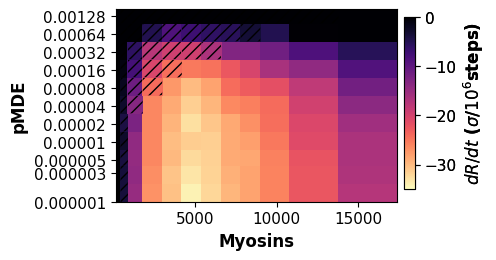

In [240]:
#CONSTRICTION RATE
g, ax1 = plt.subplots(1,1, sharex=True)
timestep_temp=1000000
cmap = sns.color_palette('magma_r',as_cmap = True)
def rate_temp(nM_temp,pMDE_temp):
    try: 
        key = build_key(pMDE_temp = pMDE_temp, nM_temp = nM_temp)
        if ale_PercFrac(key,timestep_temp) > 0.8:
            return 1000000*ale_rate_constrict(key,timestep_temp)
        else: return np.nan
    except KeyError: return np.nan
def rate_temp_broken(nM_temp,pMDE_temp):
    try: 
        key = build_key(pMDE_temp = pMDE_temp, nM_temp = nM_temp)
        if not ale_PercFrac(key,timestep_temp)>0.8:
            return 1000000*ale_rate_constrict(key,timestep_temp)
        else: return np.nan
    except KeyError: return np.nan
ale_colorplot(nMs,pMDEs,rate_temp,cmap,-3.5*10**(1),0,g=g,ax=ax1,l=.93,b=.16,w=.03,h=.69,lab='$dR/dt$ ($\sigma$/$10^6$steps)',logay = True,ymax = 0.00165)
ale_colorplot(nMs,pMDEs,rate_temp_broken,cmap,-3.5*10**(1),0,g=g,ax=ax1,l=.93,b=.16,w=.03,h=.69,lab='$dR/dt$ ($\sigma$/$10^6$steps)',logay = True,ymax = 0.00165, hatch = "///")
ax1.set_ylabel('pMDE')
ax1.set_xlabel('Myosins')

g.figure.set_figwidth(3.5)
g.figure.set_figheight(2.5)

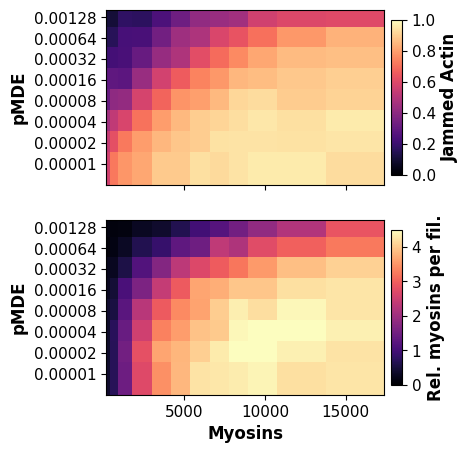

In [332]:
#Jammed filaments and not jammed motors
g, [ax1, ax2] = plt.subplots(2,1, sharex=True)
timestep_temp=2000000
cmap = sns.color_palette('magma',as_cmap = True)
def actin_jammed_temp(nM_temp,pMDE_temp):
    return ale_actin_jammed(build_key(pMDE_temp = pMDE_temp, nM_temp = nM_temp),timestep_temp)/400
ale_colorplot(nMs,pMDEs,actin_jammed_temp,cmap,0,1,g=g,ax=ax1,l=.92,b=.55,w=.03,h=.31,lab='Jammed Actin',logay = True,ymax = 0.00165)

cmap = sns.color_palette('magma',as_cmap = True)
def not_jammed_temp(nM_temp,pMDE_temp):
    return ale_relevant_myosins(build_key(pMDE_temp = pMDE_temp, nM_temp = nM_temp),timestep_temp)/getparams(key)['nF']
ale_colorplot(nMs,pMDEs,not_jammed_temp,cmap,0.,4.5,g=g,ax=ax2,l=.92,b=.13,w=.03,h=.31,lab='Rel. myosins per fil.',logay = True,ymax = 0.00165)

ax1.set_ylabel('pMDE')
ax2.set_ylabel('pMDE')
ax2.set_xlabel('Myosins')

g.figure.set_figwidth(3.5)
g.figure.set_figheight(5)

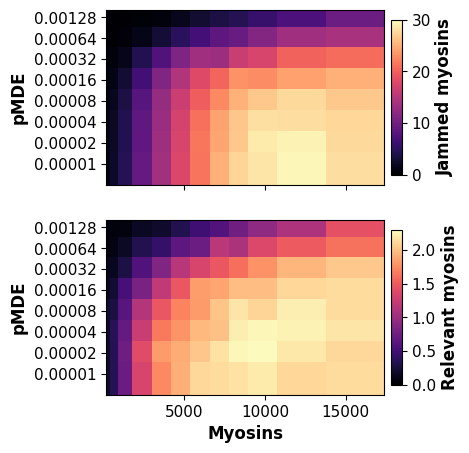

In [333]:
#Jammed filaments and not jammed motors
nMs = np.array([300,600,1200,2400,3600,4800,6000,7200,8400,9600,12000,15600])
pMDEs = np.array(['0.00001','0.00002','0.00004','0.00008','0.00016','0.00032','0.00064','0.00128'])
g, [ax1, ax2] = plt.subplots(2,1, sharex=True)
timestep_temp=2000000
cmap = sns.color_palette('magma',as_cmap = True)
def jammed_temp(nM_temp,pMDE_temp):
    key = build_key(pMDE_temp = pMDE_temp, nM_temp = nM_temp)
    return ale_jammed(key,timestep_temp)/getparams(key)['nF']
ale_colorplot(nMs,pMDEs,jammed_temp,cmap,0,30,g=g,ax=ax1,l=.92,b=.55,w=.03,h=.31,lab='Jammed myosins',logay = True,ymax = 0.00165)

cmap = sns.color_palette('magma',as_cmap = True)
def not_jammed_temp(nM_temp,pMDE_temp):
    key = build_key(pMDE_temp = pMDE_temp, nM_temp = nM_temp)
    return ale_relevant_myosins(key,timestep_temp)/getparams(key)['nF']
ale_colorplot(nMs,pMDEs,not_jammed_temp,cmap,0.,2.3,g=g,ax=ax2,l=.92,b=.13,w=.03,h=.31,lab='Relevant myosins',logay = True,ymax = 0.00165)

ax1.set_ylabel('pMDE')
ax2.set_ylabel('pMDE')
ax2.set_xlabel('Myosins')

g.figure.set_figwidth(3.5)
g.figure.set_figheight(5)

/tmp/ipykernel_203315/2125132243.py:91: RuntimeWarning: Mean of empty slice
  try: return np.nanmean([row['MSpeedAntiparallelNotjammedAvg'] if np.isnan(row['MSpeedRelevantAvg']) else row['MSpeedRelevantAvg'] for id, row in df_temp.iterrows()][1:])


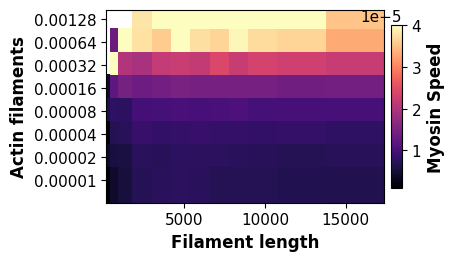

In [334]:
#Myosin Speed
nMs = np.array([300,600,1200,2400,3600,4800,6000,7200,8400,9600,12000,15600])
pMDEs = np.array(['0.00001','0.00002','0.00004','0.00008','0.00016','0.00032','0.00064','0.00128'])
timestep_temp = 2000000
#Myosin Speed
g, ax1 = plt.subplots(1,1, sharex=True)
cmap = sns.color_palette('magma',as_cmap = True)
def myosin_speed_temp(nM_temp,pMDE_temp):
    key = build_key(nM_temp = nM_temp, pMDE_temp=pMDE_temp, sector = False)
    try: 
        #print(key)
        #print(ale_myosin_speed(key,timestep_temp, sector=False))
        return ale_myosin_speed(key,timestep_temp, sector=False)
    except KeyError:
        print(key)
        return np.nan
ale_colorplot(nMs,pMDEs,myosin_speed_temp,cmap,10**-6,4*10**-5,g=g,ax=ax1,l=.92,b=.17,w=.03,h=.65,lab='Myosin Speed',logay = True,ymax = 0.00165)

ax1.set_ylabel('Actin filaments')
ax1.set_xlabel('Filament length')

g.figure.set_figwidth(3.5)
g.figure.set_figheight(2.5)

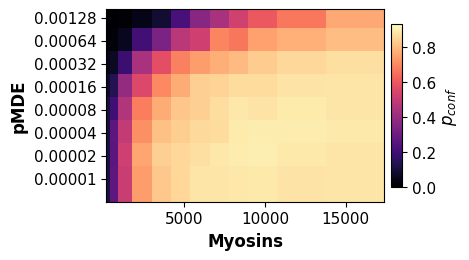

In [335]:
#Configuration probability
timestep_temp = 2000000
nMs = np.array([300,600,1200,2400,3600,4800,6000,7200,8400,9600,12000,15600])
pMDEs = np.array(['0.00001','0.00002','0.00004','0.00008','0.00016','0.00032','0.00064','0.00128'])
g, ax1 = plt.subplots(1,1, sharex=True)

cmap = sns.color_palette('magma',as_cmap = True)
def conf_prob_temp(nM_temp,pMDE_temp):
    return ale_conf_prob(build_key(pMDE_temp = pMDE_temp, nM_temp = nM_temp),timestep_temp)
ale_colorplot(nMs,pMDEs,conf_prob_temp,cmap,0.,0.93,g=g,ax=ax1,l=.92,b=.17,w=.03,h=.65,lab='$p_{conf}$',logay = True,ymax = 0.00165)

ax1.set_ylabel('pMDE')
ax1.set_xlabel('Myosins')

g.figure.set_figwidth(3.5)
g.figure.set_figheight(2.5)

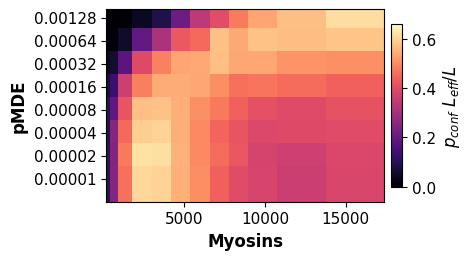

In [336]:
#Configuration probability
timestep_temp = 2000000
nMs = np.array([300,600,1200,2400,3600,4800,6000,7200,8400,9600,12000,15600])
pMDEs = np.array(['0.00001','0.00002','0.00004','0.00008','0.00016','0.00032','0.00064','0.00128'])
g, ax1 = plt.subplots(1,1, sharex=True)

cmap = sns.color_palette('magma',as_cmap = True)
def conf_prob_temp(nM_temp,pMDE_temp):
    key = build_key(pMDE_temp = pMDE_temp, nM_temp = nM_temp)
    return ale_conf_prob(key,timestep_temp)*(getparams(key)['lF']-ale_jammed(key,timestep_temp)/getparams(key)['nF'])/getparams(key)['lF']
ale_colorplot(nMs,pMDEs,conf_prob_temp,cmap,0,.66,g=g,ax=ax1,l=.92,b=.17,w=.03,h=.65,lab='$p_{conf}$ $L_{eff}/L$',logay = True,ymax = 0.00165)

ax1.set_ylabel('pMDE')
ax1.set_xlabel('Myosins')

g.figure.set_figwidth(3.5)
g.figure.set_figheight(2.5)

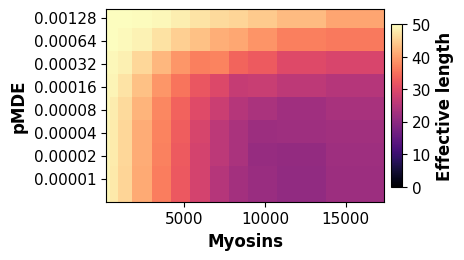

In [337]:
#Effective filament length
g, ax1 = plt.subplots(1,1, sharex=True)
nMs = np.array([300,600,1200,2400,3600,4800,6000,7200,8400,9600,12000,15600])
pMDEs = np.array(['0.00001','0.00002','0.00004','0.00008','0.00016','0.00032','0.00064','0.00128'])
cmap = sns.color_palette('magma',as_cmap = True)
def effective_length(nM_temp,pMDE_temp):
    key = build_key(pMDE_temp = pMDE_temp, nM_temp = nM_temp)
    return getparams(key)['lF']-ale_jammed(key,2000000)/getparams(key)['nF']
ale_colorplot(nMs,pMDEs,effective_length,cmap,0.,50,g=g,ax=ax1,l=.92,b=.17,w=.03,h=.65,lab='Effective length',logay = True,ymax = 0.00165)

ax1.set_ylabel('pMDE')
ax1.set_xlabel('Myosins')

g.figure.set_figwidth(3.5)
g.figure.set_figheight(2.5)

# lF, nF*lF = const

In [41]:
def S(L):
    return (
        1 - np.exp((((
        2.4*10**-8 * (0.10002 + 0.003/L) * (2.*10**-15 + 
        1.*10**-10 * (0.1 + 0.043/L) + (0.00003 * (0.1 + 0.01/L))/L**2 + (
        1.*10**-7 * (0.2 + 0.026/L))/L))/(
        0.1 * (-0.05001 * (1.*10**-6 * (0.0001 * (0.10004 + 0.026/L) + 0.003/
                L) + (-2.*10**-10 - (0.0002 * (0.10002 + 0.003/L) + 0.003/
                    L) * (0.10001 + 0.01/L)) * (0.00001 + 0.01/
                L)) * (0.00001 + 0.003/L) * (0.10002 + 0.003/
            L) - (0.00001 * (0. + 
                0.0001 * (0.05 + 1. * (0.1 + 0.003/L) - 0.003/L) + 0.0015/
                L) * (0.10002 + 0.003/L) + (
            0.00060006 * (1.*10**-9 + 
                0.0001 * (0. + 1. * (0.1 + 0.003/L)) + 0.0015/L))/
            L) * (2.*10**-15 + 1.*10**-10 * (0.1 + 0.043/L) + (
            0.00003 * (0.1 + 0.01/L))/L**2 + (1.*10**-7 * (0.2 + 0.026/L))/
            L)) - (-0.5 * (1.*10**-6 * (0.0001 * (0.10004 + 0.026/L) + 
                0.003/L) + (-2.*10**-10 - (0.0002 * (0.10002 + 0.003/L) + 
                    0.003/L) * (0.10001 + 0.01/L)) * (0.00001 + 0.01/
                L)) * (0.010003 + 0.00003/L**2 + 0.00030023/
            L) * (0.10002 + 0.003/
            L) + (-((-1.*10**-10 - 2.*10**-9 * (0.10001 + 0.01/L) + 
                    0.5 * (0.0002 * (0.10002 + 0.003/L) + 0.003/
                    L) * (0.10001 + 0.01/L)) * (0.10002 + 0.003/L)) + (
            0.002 * (1.*10**-9 + 0.0001 * (0. + 1. * (0.1 + 0.003/L)) + 
                0.0015/L))/L) * (2.*10**-15 + 
            1.*10**-10 * (0.1 + 0.043/L) + (0.00003 * (0.1 + 0.01/L))/
            L**2 + (1.*10**-7 * (0.2 + 0.026/L))/L)) * (0.00001 + 0.003/
            L)) - (0.0024 * (1.3*10**-7/L + (0.003 * (0.1 + 0.01/L))/
        L) * (2.*10**-15 + 1.*10**-10 * (0.1 + 0.043/L) + (
        0.00003 * (0.1 + 0.01/L))/L**2 + (1.*10**-7 * (0.2 + 0.026/L))/
        L))/(8.*10**-39 + 
        1.*10**-24 * (0.004 + 
            2 * (0.001 + 0.01 * (0. + 0.0685/L) + 6.14*10**-6/L**3 + 
            0.0001237/L**2) + 
            0.2 * (0.1 * (0. + 0.0265/L) + (0.01 * (0. + 0.029/L))/L) + 
            0.000012874/L**3 + 0.0003426/L**2 + 0.00254/L) + 
        2.*10**-29 * (0.07 + 0.001965/L**2 + 0.0268/L) + 
        4.*10**-34 * (0.4 + 0.072/L) + 
        1.*10**-14 * ((2.7*10**-8 * (0.03 + 0.0006/L**2 + 0.012/L))/L**3 + (
            9.*10**-6 * (0.007 + 0.00001/L**3 + 0.00048/L**2 + 0.0051/L))/
            L**2 + (0.001 * (0.002 + 0.00004/L**2 + 0.0006/L))/L + (
            0.0003 * (0.002 + 0.000016/L**3 + 0.0005/L**2 + 0.0031/L))/L) + 
        1.*10**-19 * (0.0001 + 
            0.1 * (0. + 0.1 * (0. + 0.0012875/L**2) + 0.02 * (0. + 0.023/L) + 
            6.14*10**-6/L**3) + 0.001 * (0. + 0.1005/L) + 7.062*10**-8/
            L**4 + 2.8788*10**-6/L**3 + 0.000034805/L**2 + 0.0000295/L + (
            0.01 * (6.*10**-7/L**3 + 0.000065/L + (0.002 * (0. + 0.003/L))/
            L))/L) + (2.7*10**-11 * (0.1 + 0.01/L)**2)/L**4 + (
        1.8*10**-12 * (0.1 + 0.01/L) * (0.02 + 0.1 * (0. + 0.0325/L) + (
            0.01 * (0. + 0.003/L))/L))/L**3 + (
        3.*10**-12 * (1.8*10**-11/L**5 + 1.889*10**-7/L**3 + 1.969*10**-6/
            L**2 + (0.00002 * (0. + 0.000195/L**2))/L**2 + 5.3*10**-6/L))/
        L) - (0.000024 * (0.00001 + 0.003/L) * (0.10002 + 0.01/
        L) * (0.00001 * (0.10002 + 0.02/L) + (0.003 * (0.10001 + 0.01/L))/
        L))/((8.*10**-39 + 
        1.*10**-24 * (0.004 + 
            2 * (0.001 + 0.01 * (0. + 0.0685/L) + 6.14*10**-6/L**3 + 
                0.0001237/L**2) + 
            0.2 * (0.1 * (0. + 0.0265/L) + (0.01 * (0. + 0.029/L))/L) + 
            0.000012874/L**3 + 0.0003426/L**2 + 0.00254/L) + 
        2.*10**-29 * (0.07 + 0.001965/L**2 + 0.0268/L) + 
        4.*10**-34 * (0.4 + 0.072/L) + 
        1.*10**-14 * ((2.7*10**-8 * (0.03 + 0.0006/L**2 + 0.012/L))/L**3 + (
            9.*10**-6 * (0.007 + 0.00001/L**3 + 0.00048/L**2 + 0.0051/L))/
            L**2 + (0.001 * (0.002 + 0.00004/L**2 + 0.0006/L))/L + (
            0.0003 * (0.002 + 0.000016/L**3 + 0.0005/L**2 + 0.0031/L))/
            L) + 1.*10**-19 * (0.0001 + 
            0.1 * (0. + 0.1 * (0. + 0.0012875/L**2) + 
                0.02 * (0. + 0.023/L) + 6.14*10**-6/L**3) + 
            0.001 * (0. + 0.1005/L) + 7.062*10**-8/L**4 + 2.8788*10**-6/
            L**3 + 0.000034805/L**2 + 0.0000295/L + (
            0.01 * (6.*10**-7/L**3 + 0.000065/L + (0.002 * (0. + 0.003/L))/
                L))/L) + (2.7*10**-11 * (0.1 + 0.01/L)**2)/L**4 + (
        1.8*10**-12 * (0.1 + 0.01/L) * (0.02 + 0.1 * (0. + 0.0325/L) + (
            0.01 * (0. + 0.003/L))/L))/L**3 + (
        3.*10**-12 * (1.8*10**-11/L**5 + 1.889*10**-7/L**3 + 1.969*10**-6/
            L**2 + (0.00002 * (0. + 0.000195/L**2))/L**2 + 5.3*10**-6/L))/
        L ) * L) ) * L)/12000)
        ) * (
            1 - np.exp(((-((
        0.0024 * (1.3*10**-7/L + (0.003 * (0.1 + 0.01/L))/L) * (2.*10**-15 + 
            1.*10**-10 * (0.1 + 0.043/L) + (0.00003 * (0.1 + 0.01/L))/L**2 + (
            1.*10**-7 * (0.2 + 0.026/L))/L))/(
        8.*10**-39 + 
        1.*10**-24 * (0.004 + 
            2 * (0.001 + 0.01 * (0. + 0.0685/L) + 6.14*10**-6/L**3 + 
                0.0001237/L**2) + 
            0.2 * (0.1 * (0. + 0.0265/L) + (0.01 * (0. + 0.029/L))/L) + 
            0.000012874/L**3 + 0.0003426/L**2 + 0.00254/L) + 
        2.*10**-29 * (0.07 + 0.001965/L**2 + 0.0268/L) + 
        4.*10**-34 * (0.4 + 0.072/L) + 
        1.*10**-14 * ((2.7*10**-8 * (0.03 + 0.0006/L**2 + 0.012/L))/L**3 + (
            9.*10**-6 * (0.007 + 0.00001/L**3 + 0.00048/L**2 + 0.0051/L))/
            L**2 + (0.001 * (0.002 + 0.00004/L**2 + 0.0006/L))/L + (
            0.0003 * (0.002 + 0.000016/L**3 + 0.0005/L**2 + 0.0031/L))/L) + 
        1.*10**-19 * (0.0001 + 
            0.1 * (0. + 0.1 * (0. + 0.0012875/L**2) + 
                0.02 * (0. + 0.023/L) + 6.14*10**-6/L**3) + 
            0.001 * (0. + 0.1005/L) + 7.062*10**-8/L**4 + 2.8788*10**-6/
            L**3 + 0.000034805/L**2 + 0.0000295/L + (
            0.01 * (6.*10**-7/L**3 + 0.000065/L + (0.002 * (0. + 0.003/L))/
                L))/L) + (2.7*10**-11 * (0.1 + 0.01/L)**2)/L**4 + (
        1.8*10**-12 * (0.1 + 0.01/L) * (0.02 + 0.1 * (0. + 0.0325/L) + (
            0.01 * (0. + 0.003/L))/L))/L**3 + (
        3.*10**-12 * (1.8*10**-11/L**5 + 1.889*10**-7/L**3 + 1.969*10**-6/
            L**2 + (0.00002 * (0. + 0.000195/L**2))/L**2 + 5.3*10**-6/L))/
        L)) - (0.0072 * (0.00001 + 0.003/L) * (0.10002 + 0.01/
        L) * (0.00001 * (0.10002 + 0.02/L) + (0.003 * (0.10001 + 0.01/L))/
        L))/((8.*10**-39 + 
        1.*10**-24 * (0.004 + 
            2 * (0.001 + 0.01 * (0. + 0.0685/L) + 6.14*10**-6/L**3 + 
                0.0001237/L**2) + 
            0.2 * (0.1 * (0. + 0.0265/L) + (0.01 * (0. + 0.029/L))/L) + 
            0.000012874/L**3 + 0.0003426/L**2 + 0.00254/L) + 
        2.*10**-29 * (0.07 + 0.001965/L**2 + 0.0268/L) + 
        4.*10**-34 * (0.4 + 0.072/L) + 
        1.*10**-14 * ((2.7*10**-8 * (0.03 + 0.0006/L**2 + 0.012/L))/L**3 + (
            9.*10**-6 * (0.007 + 0.00001/L**3 + 0.00048/L**2 + 0.0051/L))/
            L**2 + (0.001 * (0.002 + 0.00004/L**2 + 0.0006/L))/L + (
            0.0003 * (0.002 + 0.000016/L**3 + 0.0005/L**2 + 0.0031/L))/
            L) + 1.*10**-19 * (0.0001 + 
            0.1 * (0. + 0.1 * (0. + 0.0012875/L**2) + 
                0.02 * (0. + 0.023/L) + 6.14*10**-6/L**3) + 
            0.001 * (0. + 0.1005/L) + 7.062*10**-8/L**4 + 2.8788*10**-6/
            L**3 + 0.000034805/L**2 + 0.0000295/L + (
            0.01 * (6.*10**-7/L**3 + 0.000065/L + (0.002 * (0. + 0.003/L))/
                L))/L) + (2.7*10**-11 * (0.1 + 0.01/L)**2)/L**4 + (
        1.8*10**-12 * (0.1 + 0.01/L) * (0.02 + 0.1 * (0. + 0.0325/L) + (
            0.01 * (0. + 0.003/L))/L))/L**3 + (
        3.*10**-12 * (1.8*10**-11/L**5 + 1.889*10**-7/L**3 + 1.969*10**-6/
            L**2 + (0.00002 * (0. + 0.000195/L**2))/L**2 + 5.3*10**-6/L))/
        L) * L**2) - (
        0.000024 * (0.00001 + 0.003/L) * (0.10002 + 0.01/
        L) * (0.00001 * (0.10002 + 0.02/L) + (0.003 * (0.10001 + 0.01/L))/
        L))/((8.*10**-39 + 
        1.*10**-24 * (0.004 + 
            2 * (0.001 + 0.01 * (0. + 0.0685/L) + 6.14*10**-6/L**3 + 
                0.0001237/L**2) + 
            0.2 * (0.1 * (0. + 0.0265/L) + (0.01 * (0. + 0.029/L))/L) + 
            0.000012874/L**3 + 0.0003426/L**2 + 0.00254/L) + 
        2.*10**-29 * (0.07 + 0.001965/L**2 + 0.0268/L) + 
        4.*10**-34 * (0.4 + 0.072/L) + 
        1.*10**-14 * ((2.7*10**-8 * (0.03 + 0.0006/L**2 + 0.012/L))/L**3 + (
            9.*10**-6 * (0.007 + 0.00001/L**3 + 0.00048/L**2 + 0.0051/L))/
            L**2 + (0.001 * (0.002 + 0.00004/L**2 + 0.0006/L))/L + (
            0.0003 * (0.002 + 0.000016/L**3 + 0.0005/L**2 + 0.0031/L))/
            L) + 1.*10**-19 * (0.0001 + 
            0.1 * (0. + 0.1 * (0. + 0.0012875/L**2) + 
                0.02 * (0. + 0.023/L) + 6.14*10**-6/L**3) + 
            0.001 * (0. + 0.1005/L) + 7.062*10**-8/L**4 + 2.8788*10**-6/
            L**3 + 0.000034805/L**2 + 0.0000295/L + (
            0.01 * (6.*10**-7/L**3 + 0.000065/L + (0.002 * (0. + 0.003/L))/
                L))/L) + (2.7*10**-11 * (0.1 + 0.01/L)**2)/L**4 + (
        1.8*10**-12 * (0.1 + 0.01/L) * (0.02 + 0.1 * (0. + 0.0325/L) + (
            0.01 * (0. + 0.003/L))/L))/L**3 + (
        3.*10**-12 * (1.8*10**-11/L**5 + 1.889*10**-7/L**3 + 1.969*10**-6/
            L**2 + (0.00002 * (0. + 0.000195/L**2))/L**2 + 5.3*10**-6/L))/
        L) * L) - (
        0.72 * (1.3*10**-7/L + (0.003 * (0.1 + 0.01/L))/L) * (2.*10**-15 + 
        1.*10**-10 * (0.1 + 0.043/L) + (0.00003 * (0.1 + 0.01/L))/L**2 + (
        1.*10**-7 * (0.2 + 0.026/L))/L))/((8.*10**-39 + 
        1.*10**-24 * (0.004 + 
            2 * (0.001 + 0.01 * (0. + 0.0685/L) + 6.14*10**-6/L**3 + 
                0.0001237/L**2) + 
            0.2 * (0.1 * (0. + 0.0265/L) + (0.01 * (0. + 0.029/L))/L) + 
            0.000012874/L**3 + 0.0003426/L**2 + 0.00254/L) + 
        2.*10**-29 * (0.07 + 0.001965/L**2 + 0.0268/L) + 
        4.*10**-34 * (0.4 + 0.072/L) + 
        1.*10**-14 * ((2.7*10**-8 * (0.03 + 0.0006/L**2 + 0.012/L))/L**3 + (
            9.*10**-6 * (0.007 + 0.00001/L**3 + 0.00048/L**2 + 0.0051/L))/
            L**2 + (0.001 * (0.002 + 0.00004/L**2 + 0.0006/L))/L + (
            0.0003 * (0.002 + 0.000016/L**3 + 0.0005/L**2 + 0.0031/L))/
            L) + 1.*10**-19 * (0.0001 + 
            0.1 * (0. + 0.1 * (0. + 0.0012875/L**2) + 
                0.02 * (0. + 0.023/L) + 6.14*10**-6/L**3) + 
            0.001 * (0. + 0.1005/L) + 7.062*10**-8/L**4 + 2.8788*10**-6/
            L**3 + 0.000034805/L**2 + 0.0000295/L + (
            0.01 * (6.*10**-7/L**3 + 0.000065/L + (0.002 * (0. + 0.003/L))/
                L))/L) + (2.7*10**-11 * (0.1 + 0.01/L)**2)/L**4 + (
        1.8*10**-12 * (0.1 + 0.01/L) * (0.02 + 0.1 * (0. + 0.0325/L) + (
            0.01 * (0. + 0.003/L))/L))/L**3 + (
        3.*10**-12 * (1.8*10**-11/L**5 + 1.889*10**-7/L**3 + 1.969*10**-6/
            L**2 + (0.00002 * (0. + 0.000195/L**2))/L**2 + 5.3*10**-6/L))/
        L) * L)) * L)/12000))

KeyError: 'DoubleBoundOnejammedParallelMM'

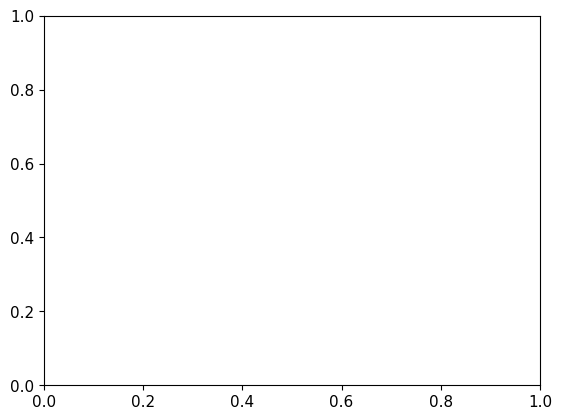

In [32]:
fig, ax1 = plt.subplots(1,1,sharex = True)
timestep_temp = 1500000
rate = []
lFs = [10,15,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
P= []
P_Leff = []
rate1 = []
P1 = []
P_Leff1 = []
rate2 = []
P2 = []
P_Leff2 = []
for lF_temp in lFs:
    nF_temp = int(20000/lF_temp)
    key = build_key(nF_temp = nF_temp, lF_temp = lF_temp, nM_temp = int(nF_temp*lF_temp/5))
    P.append(ale_conf_prob(key,timestep_temp))
    P_Leff.append(ale_conf_prob(key,timestep_temp)*(getparams(key)['lF']-ale_jammed(key,timestep_temp)/getparams(key)['nF'])/getparams(key)['lF'])
    rate.append(1000000*ale_rate_constrict(key,timestep_temp))
    nF_temp = int(12000/lF_temp)
    key = build_key(nF_temp = nF_temp, lF_temp = lF_temp, nM_temp = int(nF_temp*lF_temp/5))
    P1.append(ale_conf_prob(key,timestep_temp))
    P_Leff1.append(ale_conf_prob(key,timestep_temp)*(getparams(key)['lF']-ale_jammed(key,timestep_temp)/getparams(key)['nF'])/getparams(key)['lF'])
    rate1.append(1000000*ale_rate_constrict(key,timestep_temp))
    nF_temp = int(6000/lF_temp)
    key = build_key(nF_temp = nF_temp, lF_temp = lF_temp, nM_temp = int(nF_temp*lF_temp/5))
    P2.append(ale_conf_prob(key,timestep_temp))
    P_Leff2.append(ale_conf_prob(key,timestep_temp)*(getparams(key)['lF']-ale_jammed(key,timestep_temp)/getparams(key)['nF'])/getparams(key)['lF'])
    rate2.append(1000000*ale_rate_constrict(key,timestep_temp))
ax1.plot(lFs,rate, c= 'C0', linewidth = 0.5, marker = '.', label = '$nF * lF = 20000$')
#ax1.plot(lFs,rate1, c= 'C0', linewidth = 0.5, marker = '+', linestyle = '--', label = '$nF * lF = 12000$')
#ax1.plot(lFs,rate2, c= 'C0', linewidth = 0.5, marker = '^', linestyle = '-.', label = '$nF * lF = 6000$')
#ax1.legend()
ax1.set_ylabel('Constriction rate')
ax1.set_ylim(45/25,-45)
ax1.set_title('$nF * lF = 20000$ actin beads')
#ax1.set_title('At constant actin')
ax1.set_xlabel('Filament length')
fig.set_figheight(3.5)
fig.set_figwidth(5)
plt.tight_layout()
plt.show()

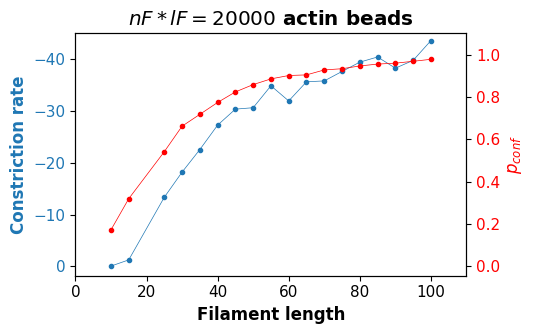

In [38]:
fig, ax1 = plt.subplots()
fig.set_figheight(3.5)
fig.set_figwidth(5.5)
ax1.set_title('$nF * lF = 20000$ actin beads')
ax1.set_xlabel('Filament length')
ax1.plot(lFs,rate, c= 'C0', linewidth = 0.5, marker = '.')
ax1.set_ylabel('Constriction rate', c = 'C0')
ax1.tick_params(axis = 'y', labelcolor = 'C0')
ax1.set_xlim(0,110)
ax1.set_ylim(45/25,-45)
ax2 = ax1.twinx()
ax2.plot(lFs,P, c = 'r', linewidth = 0.5, marker = '.')
#ax2.plot(np.linspace(5,100,100), 0.95*S(np.linspace(0,100,100)), c='C1', linestyle = '-.', alpha = 0.9, label = 'Model')
ax2.set_ylabel('$p_{conf}$', c = 'r')
ax2.set_ylim(-0.044,1.1)
ax2.tick_params(axis = 'y', labelcolor = 'r')
plt.tight_layout()
plt.show()

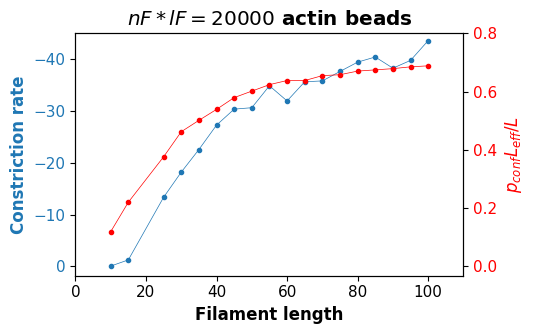

In [39]:
fig, ax1 = plt.subplots()
fig.set_figheight(3.5)
fig.set_figwidth(5.5)
ax1.set_title('$nF * lF = 20000$ actin beads')
ax1.set_xlabel('Filament length')
ax1.plot(lFs,rate, c= 'C0', linewidth = 0.5, marker = '.')
ax1.set_ylabel('Constriction rate', c = 'C0')
ax1.tick_params(axis = 'y', labelcolor = 'C0')
ax1.set_xlim(0,110)
ax1.set_ylim(45/25,-45)
ax2 = ax1.twinx()
ax2.plot(lFs,P_Leff, c = 'r', linewidth = 0.5, marker = '.')
#ax2.plot(np.linspace(5,100,100), 0.95*S(np.linspace(0,100,100)), c='C1', linestyle = '-.', alpha = 0.9, label = 'Model')
ax2.set_ylabel('$p_{conf} L_{eff} / L$', c = 'r')
ax2.set_ylim(-0.032,0.8)
ax2.tick_params(axis = 'y', labelcolor = 'r')
plt.tight_layout()
plt.show()

/tmp/ipykernel_122331/1836192141.py:4: RuntimeWarning: divide by zero encountered in divide
  2.4*10**-8 * (0.10002 + 0.003/L) * (2.*10**-15 +
/tmp/ipykernel_122331/1836192141.py:5: RuntimeWarning: divide by zero encountered in divide
  1.*10**-10 * (0.1 + 0.043/L) + (0.00003 * (0.1 + 0.01/L))/L**2 + (
/tmp/ipykernel_122331/1836192141.py:6: RuntimeWarning: divide by zero encountered in divide
  1.*10**-7 * (0.2 + 0.026/L))/L))/(
/tmp/ipykernel_122331/1836192141.py:7: RuntimeWarning: divide by zero encountered in divide
  0.1 * (-0.05001 * (1.*10**-6 * (0.0001 * (0.10004 + 0.026/L) + 0.003/
/tmp/ipykernel_122331/1836192141.py:8: RuntimeWarning: divide by zero encountered in divide
  L) + (-2.*10**-10 - (0.0002 * (0.10002 + 0.003/L) + 0.003/
/tmp/ipykernel_122331/1836192141.py:9: RuntimeWarning: divide by zero encountered in divide
  L) * (0.10001 + 0.01/L)) * (0.00001 + 0.01/
/tmp/ipykernel_122331/1836192141.py:7: RuntimeWarning: invalid value encountered in add
  0.1 * (-0.05001 * (1.*

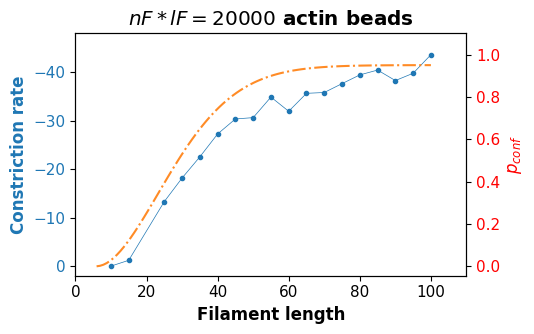

In [51]:
fig, ax1 = plt.subplots()
fig.set_figheight(3.5)
fig.set_figwidth(5.5)
ax1.set_title('$nF * lF = 20000$ actin beads')
ax1.set_xlabel('Filament length')
ax1.plot(lFs,rate, c= 'C0', linewidth = 0.5, marker = '.')
ax1.set_ylabel('Constriction rate', c = 'C0')
ax1.tick_params(axis = 'y', labelcolor = 'C0')
ax1.set_xlim(0,110)
ax1.set_ylim(48/25,-48)
ax2 = ax1.twinx()
#ax2.plot(lFs,P, c = 'r', linewidth = 0.5, marker = '.')
ax2.plot(np.linspace(5,100,100), 0.95*S(np.linspace(0,100,100)), c='C1', linestyle = '-.', alpha = 0.9, label = 'Model')
#ax2.legend()
ax2.set_ylabel('$p_{conf}$', c = 'r')
ax2.set_ylim(-0.044,1.1)
ax2.tick_params(axis = 'y', labelcolor = 'r')
plt.tight_layout()
plt.show()

/tmp/ipykernel_122331/1836192141.py:4: RuntimeWarning: divide by zero encountered in divide
  2.4*10**-8 * (0.10002 + 0.003/L) * (2.*10**-15 +
/tmp/ipykernel_122331/1836192141.py:5: RuntimeWarning: divide by zero encountered in divide
  1.*10**-10 * (0.1 + 0.043/L) + (0.00003 * (0.1 + 0.01/L))/L**2 + (
/tmp/ipykernel_122331/1836192141.py:6: RuntimeWarning: divide by zero encountered in divide
  1.*10**-7 * (0.2 + 0.026/L))/L))/(
/tmp/ipykernel_122331/1836192141.py:7: RuntimeWarning: divide by zero encountered in divide
  0.1 * (-0.05001 * (1.*10**-6 * (0.0001 * (0.10004 + 0.026/L) + 0.003/
/tmp/ipykernel_122331/1836192141.py:8: RuntimeWarning: divide by zero encountered in divide
  L) + (-2.*10**-10 - (0.0002 * (0.10002 + 0.003/L) + 0.003/
/tmp/ipykernel_122331/1836192141.py:9: RuntimeWarning: divide by zero encountered in divide
  L) * (0.10001 + 0.01/L)) * (0.00001 + 0.01/
/tmp/ipykernel_122331/1836192141.py:7: RuntimeWarning: invalid value encountered in add
  0.1 * (-0.05001 * (1.*

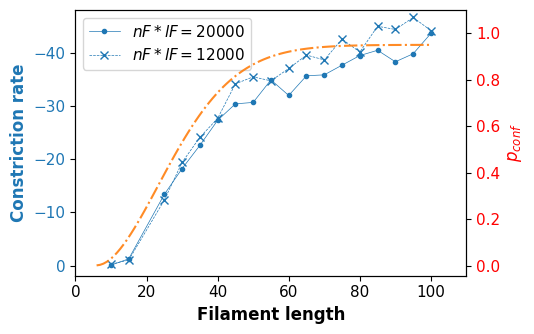

In [52]:
fig, ax1 = plt.subplots()
fig.set_figheight(3.5)
fig.set_figwidth(5.5)
ax1.set_xlabel('Filament length')
ax1.plot(lFs,rate, c= 'C0', linewidth = 0.5, marker = '.', label = '$nF*lF=20000$')
ax1.plot(lFs,rate1, c= 'C0', linewidth = 0.5, marker = 'x', linestyle = '--', label = '$nF*lF=12000$')
ax1.legend()
ax1.set_ylabel('Constriction rate', c = 'C0')
ax1.tick_params(axis = 'y', labelcolor = 'C0')
ax1.set_xlim(0,110)
ax1.set_ylim(48/25,-48)
ax2 = ax1.twinx()
#ax2.plot(lFs,P, c = 'r', linewidth = 0.5, marker = '.')
ax2.plot(np.linspace(5,100,100), 0.95*S(np.linspace(0,100,100)), c='C1', linestyle = '-.', alpha = 0.9, label = 'Model')
#ax2.legend()
ax2.set_ylabel('$p_{conf}$', c = 'r')
ax2.set_ylim(-0.044,1.1)
ax2.tick_params(axis = 'y', labelcolor = 'r')
plt.tight_layout()
plt.show()

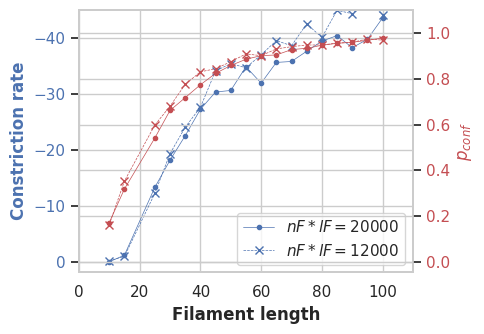

In [134]:
#This is kinda good
fig, ax1 = plt.subplots()
fig.set_figheight(3.5)
fig.set_figwidth(5)
ax1.set_xlabel('Filament length')
ax1.plot(lFs,rate, c= 'C0', linewidth = 0.5, marker = '.', label = '$nF*lF=20000$')
ax1.set_ylabel('Constriction rate', c = 'C0')
ax1.tick_params(axis = 'y', labelcolor = 'C0')
ax1.set_xlim(0,110)
ax1.set_ylim(45/25,-45)
ax2 = ax1.twinx()
ax2.plot(lFs,P, c = 'r', linewidth = 0.5, marker = '.')
ax1.plot(lFs,rate1, c= 'C0', linewidth = 0.5, marker = 'x', linestyle = '--', label = '$nF*lF=12000$')
ax2.plot(lFs,P1, c = 'r', linewidth = 0.5, marker = 'x', linestyle = '--')
ax1.legend()
ax2.set_ylabel('$p_{conf}$', c = 'r')
ax2.set_ylim(-0.044,1.1)
ax2.tick_params(axis = 'y', labelcolor = 'r')
plt.tight_layout()
plt.show()

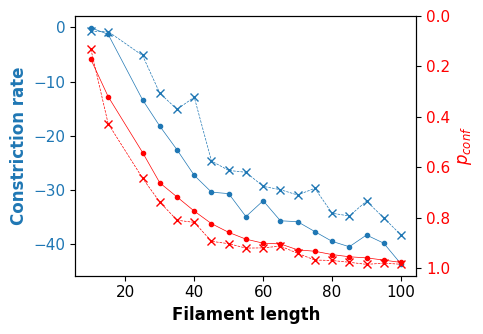

In [353]:
#But this is bad

fig, ax1 = plt.subplots()
fig.set_figheight(3.5)
fig.set_figwidth(5)
#ax1.set_title('$nF * lF = 12000$ actin beads')
ax1.set_xlabel('Filament length')
ax1.plot(lFs,rate, c= 'C0', linewidth = 0.5, marker = '.')
ax1.plot(lFs,rate2, c= 'C0', linewidth = 0.5, marker = 'x', linestyle = '--')
ax1.set_ylabel('Constriction rate', c = 'C0')
ax1.tick_params(axis = 'y', labelcolor = 'C0')
ax2 = ax1.twinx()
ax2.plot(lFs,P, c = 'r', linewidth = 0.5, marker = '.')
ax2.plot(lFs,P2, c = 'r', linewidth = 0.5, marker = 'x', linestyle = '--')
ax2.set_ylabel('$p_{conf}$', c = 'r')
ax2.set_ylim(1.03,0)
ax2.tick_params(axis = 'y', labelcolor = 'r')
plt.tight_layout()
plt.show()

# pMW (and lF)

In [345]:
for key in dicR.keys():
    if getparams(key)['real'] == 205: print(key)

rw_r0-250-200_Lz10.0_nF400-50_nM4000_nC0_R10-0-0-0-0-0-0-0.1-0.001-0.00001-0.00001-0-0-0_205
rw_r0-250-200_Lz10.0_nF400-50_nM4000_nC0_R10-0-0-0-0-0-0-0.1-0.01-0.00001-0.00001-0-0-0_205
rw_r0-250-200_Lz10.0_nF400-50_nM4000_nC0_R10-0-0-0-0-0-0-0.1-0.1-0.00001-0.00001-0-0-0_205
rw_r0-250-200_Lz10.0_nF400-50_nM4000_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_205
rw_r0-250-200_Lz10.0_nF266-75_nM3990_nC0_R10-0-0-0-0-0-0-0.1-0.001-0.00001-0.00001-0-0-0_205
rw_r0-250-200_Lz10.0_nF266-75_nM3990_nC0_R10-0-0-0-0-0-0-0.1-0.01-0.00001-0.00001-0-0-0_205
rw_r0-250-200_Lz10.0_nF266-75_nM3990_nC0_R10-0-0-0-0-0-0-0.1-0.1-0.00001-0.00001-0-0-0_205
rw_r0-250-200_Lz10.0_nF266-75_nM3990_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_205
rw_r0-250-200_Lz10.0_nF800-25_nM4000_nC0_R10-0-0-0-0-0-0-0.1-0.001-0.00001-0.00001-0-0-0_205
rw_r0-250-200_Lz10.0_nF800-25_nM4000_nC0_R10-0-0-0-0-0-0-0.1-0.01-0.00001-0.00001-0-0-0_205
rw_r0-250-200_Lz10.0_nF800-25_nM4000_nC0_R10-0-0-0-0-0-0-0.1-0.1-0.00001-0.00001-0-0-

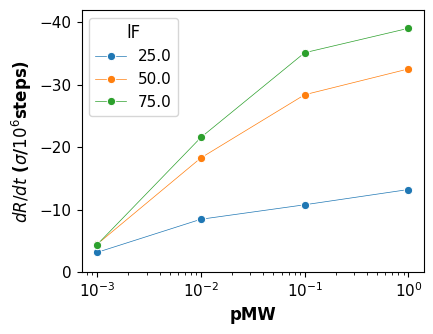

In [356]:
df_temp = pd.DataFrame({'pMW':[],'lF':[],'rate':[]})
fig, ax = plt.subplots(1,1)
for key in dicR.keys():
    if getparams(key)['real'] == 205 and not key[:3]=='Sec':# and not getparams(key)['lF']==50:
        df_temp.loc[len(df_temp.index)] = [getparams(key)['pMW'],getparams(key)['lF'],ale_rate_constrict(key,1000000)*1000000]
sns.lineplot(data = df_temp, x = 'pMW', y = 'rate', hue = 'lF', palette=sns.color_palette()[0:3], linewidth = 0.5, marker = 'o')
plt.xscale('log')
"""ax.set_ylabel('Ring radius')
ax.set_xlabel('time')
ax.set_xlim(1*10**5,2*10**6)
ax.set_ylim(130,205)"""
ax.set_ylabel('$dR/dt$ ($\sigma$/$10^6$steps)')
ax.set_ylim(0,-42)
fig.set_figheight(3.5)
fig.set_figwidth(4.5)
plt.tight_layout()
plt.show()


/tmp/ipykernel_112965/269116762.py:28: RuntimeWarning: divide by zero encountered in divide
  def nF2lF(nF_temp): return 20000/nF_temp


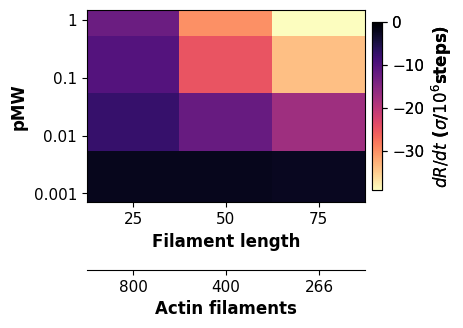

In [271]:
lFs = np.array([25,50,75])
pMWs = np.array(['0.001','0.01','0.1','1'])

g, ax2 = plt.subplots(1,1, sharex=True)
timestep_temp= 500000

cmap = sns.color_palette('magma_r',as_cmap = True)

def rate_temp(lF_temp,pMW_temp):
    try: 
        key = build_key(lF_temp = lF_temp, nF_temp = int(20000/lF_temp), nM_temp = int(int(20000/lF_temp)*lF_temp/5),pMW_temp=pMW_temp,sd = 205)
        if ale_PercFrac(key,timestep_temp)>0.8:
            return 1000000*ale_rate_constrict(key,timestep_temp)
        else: 
            return np.nan
    except KeyError: return np.nan
def rate_temp_broken(lF_temp,pMW_temp):
    try: 
        key = build_key(lF_temp = lF_temp, nF_temp = int(20000/lF_temp), nM_temp = int(int(20000/lF_temp)*lF_temp/5),pMW_temp=pMW_temp,sd = 205)
        if not ale_PercFrac(key,timestep_temp)>0.8:
            return 1000000*ale_rate_constrict(key,timestep_temp)
        else: return np.nan
    except KeyError: return np.nan
ale_colorplot(lFs,pMWs,rate_temp,cmap,-3.9*10**(1),0,g=g,ax=ax2,l=.92,b=.16,w=.03,h=.67,lab='$dR/dt$ ($\sigma$/$10^6$steps)', logay = True, ymax = 1.5, ymin = 0.0007)
ale_colorplot(lFs,pMWs,rate_temp_broken,cmap,-3.9*10**(1),0,g=g,ax=ax2,l=.92,b=.16,w=.03,h=.67,lab='$dR/dt$ ($\sigma$/$10^6$steps)', logay = True, ymax = 1.5, ymin = 0.0007,hatch='///')

def lF2nF(lF_temp): return 20000/lF_temp
def nF2lF(nF_temp): return 20000/nF_temp

secax2 = ax2.secondary_xaxis(-0.35, functions=(lF2nF,nF2lF))
secax2.set_xlabel('Actin filaments')
secax2.set_xticks([int(lF2nF(25)),int(lF2nF(50)),int(lF2nF(75))])
ax2.set_xticks([25, 50, 75])

ax2.set_ylabel('pMW')
ax2.set_xlabel('Filament length')
g.figure.set_figwidth(3.5)
g.figure.set_figheight(2.5)
plt.show()

/tmp/ipykernel_112965/1405934892.py:20: RuntimeWarning: divide by zero encountered in divide
  def nF2lF(nF_temp): return 20000/nF_temp


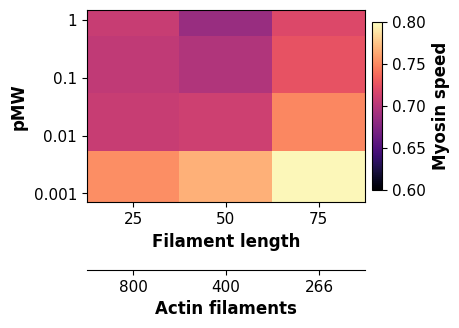

In [586]:
lFs = np.array([25,50,75])
pMWs = np.array(['0.001','0.01','0.1','1'])

g, ax2 = plt.subplots(1,1, sharex=True)
timestep_temp= 500000

cmap = sns.color_palette('magma',as_cmap = True)

def conf_prob_temp(lF_temp,pMW_temp):
    key = build_key(lF_temp = lF_temp, nF_temp = int(20000/lF_temp), nM_temp = int(int(20000/lF_temp)*lF_temp/5),pMW_temp=pMW_temp,sd = 205)
    try: 
        return (getparams(key)['lF']-ale_jammed(key,timestep_temp)/getparams(key)['nF'])/getparams(key)['lF']
    except KeyError:
        print(key)
        return np.nan
 
ale_colorplot(lFs,pMWs,conf_prob_temp,cmap,0.6,0.8,g=g,ax=ax2,l=.92,b=.16,w=.03,h=.67,lab='Myosin speed', logay = True, ymax = 1.5, ymin = 0.0007)

def lF2nF(lF_temp): return 20000/lF_temp
def nF2lF(nF_temp): return 20000/nF_temp

secax2 = ax2.secondary_xaxis(-0.35, functions=(lF2nF,nF2lF))
secax2.set_xlabel('Actin filaments')
secax2.set_xticks([int(lF2nF(25)),int(lF2nF(50)),int(lF2nF(75))])
ax2.set_xticks([25, 50, 75])

ax2.set_ylabel('pMW')
ax2.set_xlabel('Filament length')
g.figure.set_figwidth(3.5)
g.figure.set_figheight(2.5)
plt.show()

/tmp/ipykernel_112965/2881108597.py:20: RuntimeWarning: divide by zero encountered in divide
  def nF2lF(nF_temp): return 20000/nF_temp


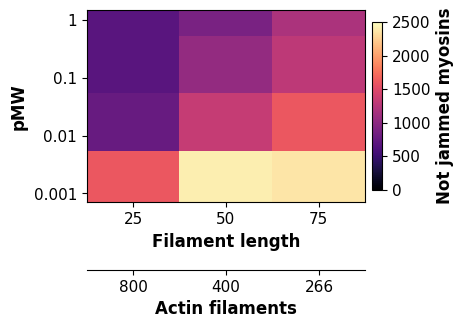

In [310]:
lFs = np.array([25,50,75])
pMWs = np.array(['0.001','0.01','0.1','1'])

g, ax2 = plt.subplots(1,1, sharex=True)
timestep_temp= 500000

cmap = sns.color_palette('magma',as_cmap = True)

def relevant_temp(lF_temp,pMW_temp):
    key = build_key(lF_temp = lF_temp, nF_temp = int(20000/lF_temp), nM_temp = int(int(20000/lF_temp)*lF_temp/5),pMW_temp=pMW_temp,sd = 205)
    try: 
        return ale_not_jammed(key,timestep_temp)
    except KeyError:
        print(key)
        return np.nan
 
ale_colorplot(lFs,pMWs,relevant_temp,cmap,0,2500,g=g,ax=ax2,l=.92,b=.16,w=.03,h=.67,lab='Not jammed myosins', logay = True, ymax = 1.5, ymin = 0.0007)

def lF2nF(lF_temp): return 20000/lF_temp
def nF2lF(nF_temp): return 20000/nF_temp

secax2 = ax2.secondary_xaxis(-0.35, functions=(lF2nF,nF2lF))
secax2.set_xlabel('Actin filaments')
secax2.set_xticks([int(lF2nF(25)),int(lF2nF(50)),int(lF2nF(75))])
ax2.set_xticks([25, 50, 75])

ax2.set_ylabel('pMW')
ax2.set_xlabel('Filament length')
g.figure.set_figwidth(3.5)
g.figure.set_figheight(2.5)
plt.show()

/tmp/ipykernel_112965/1360781195.py:20: RuntimeWarning: divide by zero encountered in divide
  def nF2lF(nF_temp): return 20000/nF_temp


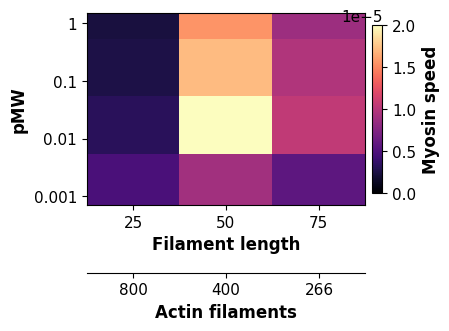

In [286]:
lFs = np.array([25,50,75])
pMWs = np.array(['0.001','0.01','0.1','1'])

g, ax2 = plt.subplots(1,1, sharex=True)
timestep_temp= 500000

cmap = sns.color_palette('magma',as_cmap = True)

def myosin_speed_temp(lF_temp,pMW_temp):
    key = build_key(lF_temp = lF_temp, nF_temp = int(20000/lF_temp), nM_temp = int(int(20000/lF_temp)*lF_temp/5),pMW_temp=pMW_temp,sd = 205)
    try: 
        return ale_myosin_speed(key,timestep_temp, sector = False)
    except KeyError:
        print(key)
        return np.nan
 
ale_colorplot(lFs,pMWs,myosin_speed_temp,cmap,0,2*10**-5,g=g,ax=ax2,l=.92,b=.16,w=.03,h=.67,lab='Myosin speed', logay = True, ymax = 1.5, ymin = 0.0007)

def lF2nF(lF_temp): return 20000/lF_temp
def nF2lF(nF_temp): return 20000/nF_temp

secax2 = ax2.secondary_xaxis(-0.35, functions=(lF2nF,nF2lF))
secax2.set_xlabel('Actin filaments')
secax2.set_xticks([int(lF2nF(25)),int(lF2nF(50)),int(lF2nF(75))])
ax2.set_xticks([25, 50, 75])

ax2.set_ylabel('pMW')
ax2.set_xlabel('Filament length')
g.figure.set_figwidth(3.5)
g.figure.set_figheight(2.5)
plt.show()

# Myosin bond strain

In [20]:
df = pd.DataFrame({'nM':[],'nC':[],'lF':[],'nF':[],'Lz':[],'pMDE':[],'pMW':[],'real':[],'DBANotjammedMM':[],'DBJammedMM':[],'StrainAll':[],'StrainDB':[],'StrainNotDB':[],'StrainDBANJ':[],'StrainDBAOJ':[],'StrainDBPNJ':[],'StrainDBPOJ':[],'EndtoendFree':[],'EndtoendActive':[],'Rate':[]})
for key in dicR.keys():
    if key[:3] == 'Sec': continue
    df_temp = dicR[key]
    pars = getparams(key)
    df_temp = df_temp[df_temp['time']<3000000]
    try: 
        a = df_temp['MyosinStrainAvg'][0]
        b = df_temp['EndtoendDistanceOut']
    except: continue
    notDBMM = (np.sum(df_temp['histMyosinStrainDistr'][0][1])-df_temp['DoubleBoundMM'])
    strainnotdoublebonded = np.nanmean([(df_temp['MyosinStrainAvg']*np.sum(df_temp['histMyosinStrainDistr'][0][1])-df_temp['DoubleBoundMyosinStrainAvg']*df_temp['DoubleBoundMM'])/notDBMM])
    nonjammedcontractile = 0
    jammed = 0
    #jammed = np.nanmean(df_temp['JammedMyosins'])
    #nonjammedcontractile = np.nanmean(2*df_temp['DoubleBoundNeitherjammedAntiparallelMM'])+np.nanmean(df_temp['DoubleBoundOnejammedAntiparallelMM'])+np.nanmean(df_temp['DoubleBoundOnejammedParallelMM'])
    df.loc[len(df)] = [pars['nM'],pars['nC'],pars['lF'],pars['nF'],pars['Lz'],pars['pMDE'],pars['pMW'],pars['real'],nonjammedcontractile,jammed,np.nanmean(df_temp['MyosinStrainAvg'])/10,np.nanmean(df_temp['DoubleBoundMyosinStrainAvg'])/10,strainnotdoublebonded/10,np.nanmean(df_temp['DoubleBoundNeitherjammedAntiparallelMyosinStrainAvg'])/10,np.nanmean(df_temp['DoubleBoundOnejammedAntiparallelMyosinStrainAvg'])/10,np.nanmean(df_temp['DoubleBoundNeitherjammedParallelMyosinStrainAvg'])/10,np.nanmean(df_temp['DoubleBoundOnejammedParallelMyosinStrainAvg'])/10, np.nanmean(df_temp['EndtoendDistanceOut'])/pars['lF'],np.nanmean([np.nanmean(df_temp['EndtoendDistanceBondedMM']),np.nanmean(df_temp['EndtoendDistanceBondedMC'])])/pars['lF'], -1000000*ale_rate_constrict(key,2000000)]
df

/tmp/ipykernel_295206/2026109434.py:17: RuntimeWarning: Mean of empty slice
  df.loc[len(df)] = [pars['nM'],pars['nC'],pars['lF'],pars['nF'],pars['Lz'],pars['pMDE'],pars['pMW'],pars['real'],nonjammedcontractile,jammed,np.nanmean(df_temp['MyosinStrainAvg'])/10,np.nanmean(df_temp['DoubleBoundMyosinStrainAvg'])/10,strainnotdoublebonded/10,np.nanmean(df_temp['DoubleBoundNeitherjammedAntiparallelMyosinStrainAvg'])/10,np.nanmean(df_temp['DoubleBoundOnejammedAntiparallelMyosinStrainAvg'])/10,np.nanmean(df_temp['DoubleBoundNeitherjammedParallelMyosinStrainAvg'])/10,np.nanmean(df_temp['DoubleBoundOnejammedParallelMyosinStrainAvg'])/10, np.nanmean(df_temp['EndtoendDistanceOut'])/pars['lF'],np.nanmean([np.nanmean(df_temp['EndtoendDistanceBondedMM']),np.nanmean(df_temp['EndtoendDistanceBondedMC'])])/pars['lF'], -1000000*ale_rate_constrict(key,2000000)]
/tmp/ipykernel_295206/2026109434.py:17: RuntimeWarning: Mean of empty slice
  df.loc[len(df)] = [pars['nM'],pars['nC'],pars['lF'],pars['nF'],pars['

nM     nC    lF     nF    Lz      pMDE  pMW   real  DBANotjammedMM  \
0     200.0    0.0  10.0  100.0  10.0  0.000010  1.0  204.0             0.0   
1    4900.0    0.0  70.0  350.0  10.0  0.000010  1.0  204.0             0.0   
2    9600.0    0.0  50.0  400.0  10.0  0.000160  1.0  204.0             0.0   
3    1200.0  500.0  50.0  240.0  10.0  1.000000  1.0  215.0             0.0   
4     300.0    0.0  50.0  400.0  10.0  0.000005  1.0  204.0             0.0   
..      ...    ...   ...    ...   ...       ...  ...    ...             ...   
550   300.0    0.0  50.0  400.0  10.0  0.000003  1.0  204.0             0.0   
551     0.0  400.0  50.0  150.0   5.0  1.000000  1.0  208.0             0.0   
552  1200.0    0.0  60.0  100.0  10.0  0.000010  1.0  204.0             0.0   
553  1600.0    0.0  20.0  400.0  10.0  0.000010  1.0  204.0             0.0   
554  4000.0    0.0  40.0  500.0  10.0  0.000010  1.0  204.0             0.0   

     DBJammedMM  StrainAll  StrainDB  StrainNotDB  StrainDBANJ  StrainDBAOJ  \
0           0.0   1.000415  0.999867     1.000451     0.993532     0.999267   
1           0.0   1.000611  1.001759     1.000185     1.009039     1.003195   
2           0.0   1.000373  1.000270     1.000366     1.006106     1.001498   
3           0.0   1.003266  1.005546     1.000703     1.015433     1.005377   
4           0.0   0.997398  0.985576     1.000447     1.008512     1.004706   
..          ...        ...       ...          ...          ...          ...   
550         0.0   0.997271  0.983891     1.000595     1.012394     1.006058   
551         0.0        NaN       NaN          NaN          NaN          NaN   
552         0.0   0.999052  0.995942     0.999903     1.016721     1.006169   
553         0.0   0.997555  0.987430     0.999801     0.999834     1.000300   
554         0.0   1.000843  1.000850     1.000799     1.013661     1.005319   

     StrainDBPNJ  StrainDBPOJ  EndtoendFree  EndtoendActive       Rate  
0            NaN     1.001743      0.900635        0.900922   0.143295  
1       1.001299     1.000358      0.976536        0.961333  32.461155  
2       0.998356     0.999172      0.974399        0.971442  13.223853  
3       1.007190     1.001725      0.979863        0.968896   9.511384  
4       0.985709     0.981429      0.974361        0.975342   0.158461  
..           ...          ...           ...             ...        ...  
550     0.980835     0.980680      0.974668        0.975666   0.121362  
551          NaN          NaN      0.975652             NaN  -0.669058  
552     0.989455     0.992906           NaN        0.972919  27.700399  
553     0.982456     0.983924      0.950970        0.951962   1.995484  
554     0.997003     0.998159      0.971137        0.972520  26.653999  

[555 rows x 20 columns]

In [21]:
df['id'] = 1*((df['nC']==0)*(df['pMW']==1)*(df['real']==204)*(df['lF']==50)*(df['pMDE']==0.00001)==True) + 2*((df['nC']!=0)*(df['nM']!=0)*(df['pMW']==1)*(df['lF']==50)*(df['pMDE']==1)==True)# + 3*((df['real']>=20)==True)

In [22]:
#df['id'] = 1*((df['nC']==0)*(df['pMW']==1)*(df['pMDE']==0.00001)==True) + 2*((df['nC']!=0)*(df['nM']!=0)*(df['pMW']==1)*(df['lF']==50)*(df['pMDE']==1)==True)

In [23]:
df.groupby('id').agg('count')

nM   nC   lF   nF   Lz  pMDE  pMW  real  DBANotjammedMM  DBJammedMM  \
id                                                                         
0   499  499  499  499  499   499  499   499             499         499   
1    22   22   22   22   22    22   22    22              22          22   
2    34   34   34   34   34    34   34    34              34          34   

    StrainAll  StrainDB  StrainNotDB  StrainDBANJ  StrainDBAOJ  StrainDBPNJ  \
id                                                                            
0         408       408          408          407          408          405   
1          22        22           22           22           22           22   
2          34        34           34           34           34           34   

    StrainDBPOJ  EndtoendFree  EndtoendActive  Rate  
id                                                   
0           408           481             404   499  
1            22            20              22    22  
2            34            34              34    34

In [24]:
#df['id'] = 1*((df['nC']==0)*(df['pMW']==1)*(df['real']==204)*(df['pMDE']==0.00001)==True) + 2*((df['nC']!=0)*(df['nM']!=0)*(df['pMW']==1)*(df['real']<215)*(df['pMDE']==1)==True)

In [25]:
df['EndtoendDiff'] = df['EndtoendActive']-df['EndtoendFree']
df['StrainADiff'] = df['StrainDBANJ']-df['StrainAll']
df['StrainPDiff'] = df['StrainDBPNJ']-df['StrainAll']
df['StrainAPDiff'] = df['StrainDBANJ']-df['StrainDBPNJ']

In [26]:
df['Kbend'] = 500*(df['real']<215)+1000*(df['real']>=215)

In [27]:
df['NormRate'] = (df['id'] == 1)*(df['Rate']/np.max(df[df['id']==1]['Rate']))+(df['id'] == 2)*(df['Rate']/np.max(df[df['id']==2]['Rate']))

/tmp/ipykernel_295206/3528121337.py:1: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  g = sns.scatterplot(data = df[df['id']>0], x = 'EndtoendDiff', y = 'StrainADiff', hue = 'id', palette=sns.color_palette(),size = 'NormRate', sizes=(40,250), size_norm=(0.4,0.9), style='Kbend')


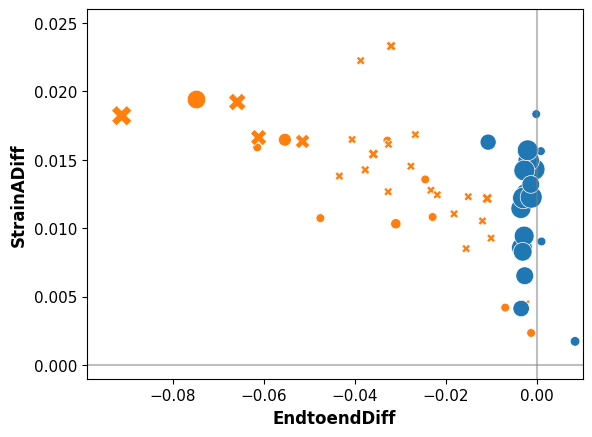

In [28]:
g = sns.scatterplot(data = df[df['id']>0], x = 'EndtoendDiff', y = 'StrainADiff', hue = 'id', palette=sns.color_palette(),size = 'NormRate', sizes=(40,250), size_norm=(0.4,0.9), style='Kbend')
plt.ylim(-0.001,0.026)
plt.xlim(-0.099,0.01)
plt.plot(np.linspace(-0.099,0.01,100),np.linspace(-0.099,0.01,100)*0,c = 'gray', alpha = 0.5)
plt.plot(np.linspace(-0.099,0.01,100)*0,np.linspace(-0.001,0.026,100),c = 'gray', alpha = 0.5)
g.legend_.remove()

/tmp/ipykernel_295206/3999348798.py:1: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(data = df[df['id']>0], x = 'EndtoendDiff', y = 'StrainPDiff', hue = 'id', palette=sns.color_palette(),size = 'NormRate', sizes=(40,250), size_norm=(0.4,0.9))


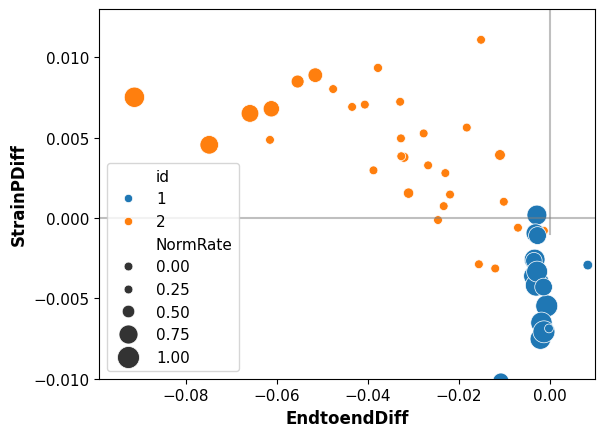

In [29]:
sns.scatterplot(data = df[df['id']>0], x = 'EndtoendDiff', y = 'StrainPDiff', hue = 'id', palette=sns.color_palette(),size = 'NormRate', sizes=(40,250), size_norm=(0.4,0.9))
plt.ylim(-0.01,0.013)
plt.xlim(-0.099,0.01)
plt.plot(np.linspace(-0.099,0.01,100),np.linspace(-0.099,0.01,100)*0,c = 'gray', alpha = 0.5)
plt.plot(np.linspace(-0.099,0.01,100)*0,np.linspace(-0.001,0.026,100),c = 'gray', alpha = 0.5)

/tmp/ipykernel_295206/1889834327.py:1: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(data = df[df['id']>0], x = 'EndtoendDiff', y = 'StrainAPDiff', hue = 'id', palette=sns.color_palette(),size = 'NormRate', sizes=(40,250), size_norm=(0.5,1))


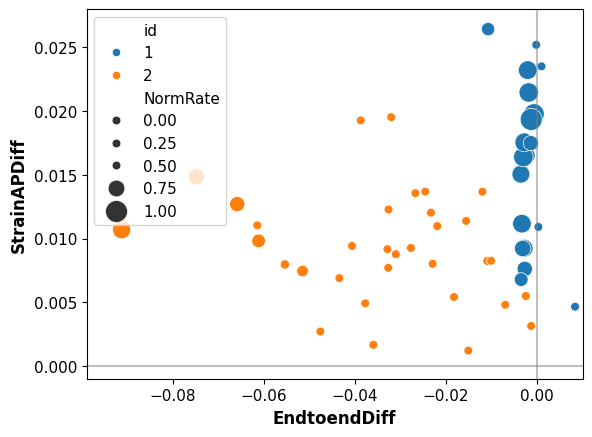

In [30]:
sns.scatterplot(data = df[df['id']>0], x = 'EndtoendDiff', y = 'StrainAPDiff', hue = 'id', palette=sns.color_palette(),size = 'NormRate', sizes=(40,250), size_norm=(0.5,1))
plt.ylim(-0.001,0.028)
plt.xlim(-0.099,0.01)
plt.plot(np.linspace(-0.099,0.01,100),np.linspace(-0.099,0.01,100)*0,c = 'gray', alpha = 0.5)
plt.plot(np.linspace(-0.099,0.01,100)*0,np.linspace(-0.001,0.028,100),c = 'gray', alpha = 0.5)

/tmp/ipykernel_121702/2529433442.py:7: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.violinplot([df_temp['StrainDBANJ'],df_temp['StrainDBAOJ'],df_temp['StrainDBPNJ'],df_temp['StrainDBPOJ']], ax= ax,palette = ['C2'],label = 'Dwelling',inner = 'box', alpha = 0.8)


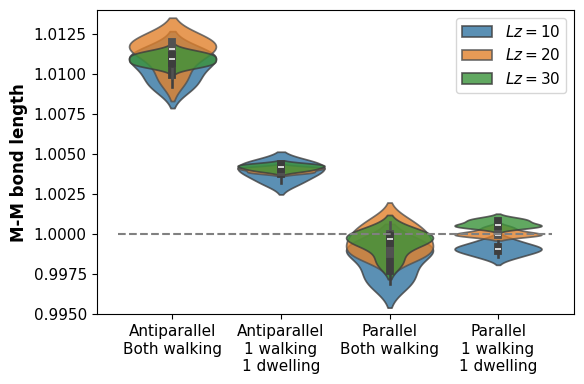

In [83]:
fig, ax = plt.subplots()
df_temp = df[(df['real']>219)*(df['Lz']==10)==True]
sns.violinplot([df_temp['StrainDBANJ'],df_temp['StrainDBAOJ'],df_temp['StrainDBPNJ'],df_temp['StrainDBPOJ']], ax= ax,palette = ['C0','C0','C0','C0'],label = 'Dwelling',inner = 'box', alpha = 0.8)
df_temp = df[(df['real']>219)*(df['Lz']==20)==True]
sns.violinplot([df_temp['StrainDBANJ'],df_temp['StrainDBAOJ'],df_temp['StrainDBPNJ'],df_temp['StrainDBPOJ']], ax= ax,palette = ['C1','C1','C1','C1'],label = 'Dwelling',inner = 'box', alpha = 0.8)
df_temp = df[(df['real']>219)*(df['Lz']==30)==True]
sns.violinplot([df_temp['StrainDBANJ'],df_temp['StrainDBAOJ'],df_temp['StrainDBPNJ'],df_temp['StrainDBPOJ']], ax= ax,palette = ['C2'],label = 'Dwelling',inner = 'box', alpha = 0.8)
#sns.violinplot([strain_Msim2,strain_DB_Msim2,strain_DBNJ_antipar_Msim2,strain_DBOJ_antipar_Msim2,strain_DBNJ_par_Msim2,strain_DBOJ_par_Msim2], ax= ax, inner = 'quart',palette = ['C1','C1','C1','C1'], alpha = 0.8, label = 'Less dwelling')
plt.ylim(0.995,1.014)
handles, labels = ax.get_legend_handles_labels()
plt.legend([handles[0],handles[6],handles[-1]],['$Lz = 10$','$Lz = 20$','$Lz = 30$'])
#plt.title("Myosin-myosin bond length")
plt.plot(np.linspace(-0.5,3.5,100),0*np.linspace(0,3,100)+1, c = 'gray', linestyle = '--')
plt.xticks([0,1,2,3],['Antiparallel\nBoth walking','Antiparallel\n1 walking\n1 dwelling','Parallel\nBoth walking','Parallel\n1 walking\n1 dwelling'])
fig.set_figheight(4)
fig.set_figwidth(6)
ax.set_ylabel('M-M bond length')
plt.tight_layout()

/tmp/ipykernel_295206/813034425.py:3: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.violinplot([df_temp['StrainNotDB'],df_temp['StrainDBANJ'],df_temp['StrainDBAOJ'],df_temp['StrainDBPNJ'],df_temp['StrainDBPOJ']], ax= ax,palette = ['C0','C0','C0','C0'],label = 'Dwelling',inner = 'box', alpha = 0.8)
/tmp/ipykernel_295206/813034425.py:5: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.violinplot([df_temp['StrainNotDB'],df_temp['StrainDBANJ'],df_temp['StrainDBAOJ'],df_temp['StrainDBPNJ'],df_temp['StrainDBPOJ']], ax= ax,palette = ['C1','C1','C1','C1'],label = 'Dwelling',inner = 'box', alpha = 0.8)
/tmp/ipykernel_295206/813034425.py:7: UserWarning: 
The palette list has fewer values (1) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.violinplot([df_temp['StrainNotDB'],df_temp['StrainDBANJ']

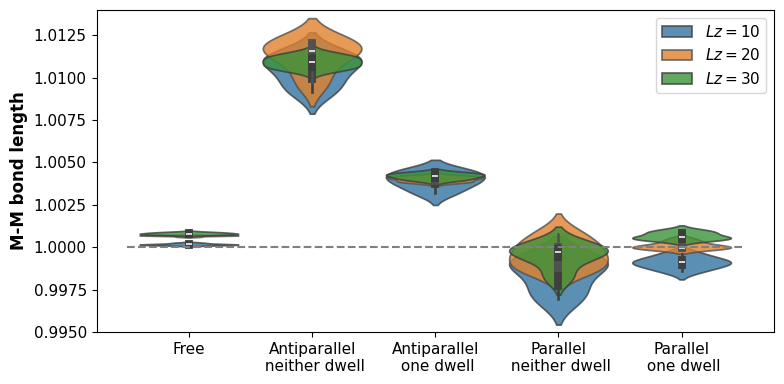

In [37]:
fig, ax = plt.subplots()
df_temp = df[(df['real']>219)*(df['Lz']==10)==True]
sns.violinplot([df_temp['StrainNotDB'],df_temp['StrainDBANJ'],df_temp['StrainDBAOJ'],df_temp['StrainDBPNJ'],df_temp['StrainDBPOJ']], ax= ax,palette = ['C0','C0','C0','C0'],label = 'Dwelling',inner = 'box', alpha = 0.8)
df_temp = df[(df['real']>219)*(df['Lz']==20)==True]
sns.violinplot([df_temp['StrainNotDB'],df_temp['StrainDBANJ'],df_temp['StrainDBAOJ'],df_temp['StrainDBPNJ'],df_temp['StrainDBPOJ']], ax= ax,palette = ['C1','C1','C1','C1'],label = 'Dwelling',inner = 'box', alpha = 0.8)
df_temp = df[(df['real']>219)*(df['Lz']==30)==True]
sns.violinplot([df_temp['StrainNotDB'],df_temp['StrainDBANJ'],df_temp['StrainDBAOJ'],df_temp['StrainDBPNJ'],df_temp['StrainDBPOJ']], ax= ax,palette = ['C2'],label = 'Dwelling',inner = 'box', alpha = 0.8)
#sns.violinplot([strain_Msim2,strain_DB_Msim2,strain_DBNJ_antipar_Msim2,strain_DBOJ_antipar_Msim2,strain_DBNJ_par_Msim2,strain_DBOJ_par_Msim2], ax= ax, inner = 'quart',palette = ['C1','C1','C1','C1'], alpha = 0.8, label = 'Less dwelling')
plt.ylim(0.995,1.014)
handles, labels = ax.get_legend_handles_labels()
plt.legend([handles[0],handles[6],handles[-1]],['$Lz = 10$','$Lz = 20$','$Lz = 30$'])
#plt.title("Myosin-myosin bond length")
plt.plot(np.linspace(-0.5,4.5,100),0*np.linspace(0,3,100)+1, c = 'gray', linestyle = '--')
plt.xticks([0,1,2,3,4],['Free','Antiparallel\n neither dwell','Antiparallel\n one dwell','Parallel\n neither dwell','Parallel\n one dwell'])
fig.set_figheight(4)
fig.set_figwidth(8)
ax.set_ylabel('M-M bond length')
plt.tight_layout()

# End to end distances: quantiying buckling

In [38]:
dfend = pd.DataFrame({'nM':[],'nC':[],'lF':[],'nF':[],'Lz':[],'pMDE':[],'pMW':[],'real':[],'Nconf':[],'e2e':[],'e2eBondedM':[],'e2eNotbondedM':[],'e2eBondedC':[],'e2eNotbondedC':[],'e2eBondedMC':[],'e2eNotbondedMC':[],'e2eBondedMCextensile':[],'e2eBondedMM':[],'e2eNotbondedMM':[],'e2eIn':[],'e2eOut':[],'strain':[],'rate':[]})
for key in dicR.keys():
    if key[:3] == 'Sec': continue
    df_temp = dicR[key]
    pars = getparams(key)
    df_temp = df_temp[df_temp['time']<2000000]
    try: 
        a = df_temp['MyosinStrainAvg'][0]
        b = df_temp['EndtoendDistanceOut']
    except: continue
    dfend.loc[len(dfend)] = [pars['nM'],pars['nC'],pars['lF'],pars['nF'],pars['Lz'],pars['pMDE'],pars['pMW'],pars['real'], np.nanmean(df_temp['EndtoendDistance'])/pars['lF'],np.nanmean(df_temp['EndtoendDistanceBondedM'])/pars['lF'],np.nanmean(df_temp['EndtoendDistanceNotbondedM'])/pars['lF'],np.nanmean(df_temp['EndtoendDistanceBondedC'])/pars['lF'],np.nanmean(df_temp['EndtoendDistanceNotbondedC'])/pars['lF'],np.nanmean(df_temp['EndtoendDistanceBondedMC'])/pars['lF'],np.nanmean(df_temp['EndtoendDistanceNotbondedMC'])/pars['lF'],np.nanmean(df_temp['EndtoendDistanceBondedMCextensile'])/pars['lF'],np.nanmean(df_temp['EndtoendDistanceBondedMM'])/pars['lF'],np.nanmean(df_temp['EndtoendDistanceNotbondedMM'])/pars['lF'],np.nanmean(df_temp['EndtoendDistanceIn'])/pars['lF'],np.nanmean(df_temp['EndtoendDistanceOut'])/pars['lF'], np.nanmean(df_temp['DoubleBoundNeitherjammedAntiparallelMyosinStrainAvg'])/10,-1000000*ale_rate_constrict(key,2000000)]
dfend

/tmp/ipykernel_295206/3099135418.py:11: RuntimeWarning: Mean of empty slice
  dfend.loc[len(dfend)] = [pars['nM'],pars['nC'],pars['lF'],pars['nF'],pars['Lz'],pars['pMDE'],pars['pMW'],pars['real'], np.nanmean(df_temp['EndtoendDistance'])/pars['lF'],np.nanmean(df_temp['EndtoendDistanceBondedM'])/pars['lF'],np.nanmean(df_temp['EndtoendDistanceNotbondedM'])/pars['lF'],np.nanmean(df_temp['EndtoendDistanceBondedC'])/pars['lF'],np.nanmean(df_temp['EndtoendDistanceNotbondedC'])/pars['lF'],np.nanmean(df_temp['EndtoendDistanceBondedMC'])/pars['lF'],np.nanmean(df_temp['EndtoendDistanceNotbondedMC'])/pars['lF'],np.nanmean(df_temp['EndtoendDistanceBondedMCextensile'])/pars['lF'],np.nanmean(df_temp['EndtoendDistanceBondedMM'])/pars['lF'],np.nanmean(df_temp['EndtoendDistanceNotbondedMM'])/pars['lF'],np.nanmean(df_temp['EndtoendDistanceIn'])/pars['lF'],np.nanmean(df_temp['EndtoendDistanceOut'])/pars['lF'], np.nanmean(df_temp['DoubleBoundNeitherjammedAntiparallelMyosinStrainAvg'])/10,-1000000*ale_rate_

nM     nC    lF     nF    Lz      pMDE  pMW   real       e2e  \
0     200.0    0.0  10.0  100.0  10.0  0.000010  1.0  204.0  0.900556   
1    4900.0    0.0  70.0  350.0  10.0  0.000010  1.0  204.0  0.962577   
2    9600.0    0.0  50.0  400.0  10.0  0.000160  1.0  204.0  0.970820   
3    1200.0  500.0  50.0  240.0  10.0  1.000000  1.0  215.0  0.971157   
4     300.0    0.0  50.0  400.0  10.0  0.000005  1.0  204.0  0.974235   
..      ...    ...   ...    ...   ...       ...  ...    ...       ...   
550   300.0    0.0  50.0  400.0  10.0  0.000003  1.0  204.0  0.974590   
551     0.0  400.0  50.0  150.0   5.0  1.000000  1.0  208.0  0.975451   
552  1200.0    0.0  60.0  100.0  10.0  0.000010  1.0  204.0  0.972622   
553  1600.0    0.0  20.0  400.0  10.0  0.000010  1.0  204.0  0.950852   
554  4000.0    0.0  40.0  500.0  10.0  0.000010  1.0  204.0  0.972117   

     e2eBondedM  ...  e2eNotbondedC  e2eBondedMC  e2eNotbondedMC  \
0      0.900644  ...       0.900556          NaN        0.900556   
1      0.962315  ...       0.962577          NaN        0.962577   
2      0.970785  ...       0.970820          NaN        0.970820   
3      0.970000  ...       0.979486     0.969847        0.979471   
4      0.974034  ...       0.974235          NaN        0.974235   
..          ...  ...            ...          ...             ...   
550    0.974488  ...       0.974590          NaN        0.974590   
551         NaN  ...       0.974987          NaN        0.975451   
552    0.972622  ...       0.972622          NaN        0.972622   
553    0.950874  ...       0.950852          NaN        0.950852   
554    0.972170  ...       0.972117          NaN        0.972117   

     e2eBondedMCextensile  e2eBondedMM  e2eNotbondedMM     e2eIn    e2eOut  \
0                     NaN     0.901310        0.900548  0.901441  0.900488   
1                     NaN     0.960947        0.972037  0.962257  0.975542   
2                     NaN     0.970690        0.972494  0.970782  0.974249   
3                0.970455     0.969993        0.976417  0.970158  0.979772   
4                     NaN     0.975162        0.974087  0.974220  0.974239   
..                    ...          ...             ...       ...       ...   
550                   NaN     0.975758        0.974406  0.974189  0.974612   
551                   NaN          NaN        0.975451  0.975929  0.975197   
552                   NaN     0.972692        0.970914  0.972622       NaN   
553                   NaN     0.951812        0.949617  0.950918  0.950860   
554                   NaN     0.972556        0.971020  0.972181  0.971190   

       strain       rate  
0    1.005500   0.143295  
1    1.011732  32.461155  
2    1.007261  13.223853  
3    1.015751   9.511384  
4    1.008839   0.158461  
..        ...        ...  
550  1.007575   0.121362  
551       NaN  -0.669058  
552  1.019524  27.700399  
553  1.001455   1.995484  
554  1.015391  26.653999  

[555 rows x 22 columns]

In [39]:
# id = 1 for M sims, 2 for MC sims, 3 for C sims
dfend['id'] = 1*((dfend['nC']==0)*(dfend['lF']==50)*(dfend['pMDE']==0.00001)==True)+2*((dfend['nC']>300)*(dfend['nM']>300)*(dfend['lF']==50)*(dfend['pMDE']==1)==True)+3*((dfend['nC']!=0)*(dfend['nM']==0)*(dfend['lF']==50)==True)#+4*(dfend['real']==217)
dfend['Kbend'] = 500*(np.logical_and(df['real']!=216,df['real']!=215))+1000*(np.logical_or(df['real']==216,df['real'] ==215))

/tmp/ipykernel_295206/251211006.py:2: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(ax = ax, data = dfend[(dfend['id']>0)*(dfend['id']<4)==True], x = 'e2eIn', y = 'rate', hue = 'id', palette = sns.color_palette())


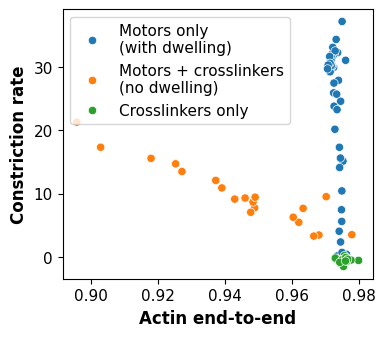

In [40]:
fig, ax = plt.subplots()
sns.scatterplot(ax = ax, data = dfend[(dfend['id']>0)*(dfend['id']<4)==True], x = 'e2eIn', y = 'rate', hue = 'id', palette = sns.color_palette())
ax.set_xlabel('Actin end-to-end')
ax.set_ylabel('Constriction rate')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles,['Motors only\n(with dwelling)','Motors + crosslinkers\n(no dwelling)','Crosslinkers only'])
fig.set_figheight(3.5)
fig.set_figwidth(4)

/tmp/ipykernel_121702/2871295402.py:3: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.violinplot([df_temp['e2eOut'],df_temp['e2eIn']], ax= ax, inner = 'box',palette = ['C1'], alpha = 0.8, label = 'Free',linewidth=1.7)
/tmp/ipykernel_121702/2871295402.py:5: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.violinplot([df_temp['e2eOut'],df_temp['e2eIn']], ax= ax, inner = 'box',palette = ['C2'], alpha = 0.8, label = 'Free',linewidth=1.7)
/tmp/ipykernel_121702/2871295402.py:7: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.violinplot([df_temp['e2eOut'],df_temp['e2eIn']], ax= ax, inner = 'box',palette = ['C0'], alpha = 0.8, label = 'Free',linewidth=1.7)


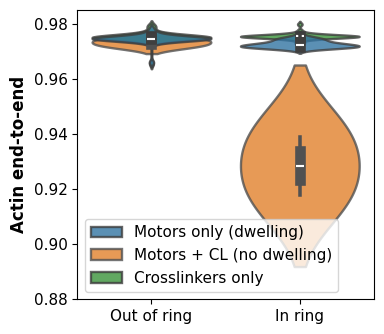

In [210]:
fig, ax = plt.subplots()
df_temp = dfend[(dfend['id']==2)*(dfend['Kbend']==500)*(dfend['rate']>10)==True]
sns.violinplot([df_temp['e2eOut'],df_temp['e2eIn']], ax= ax, inner = 'box',palette = ['C1'], alpha = 0.8, label = 'Free',linewidth=1.7)
df_temp = dfend[(dfend['id']==3)*(dfend['rate']>-10)==True]
sns.violinplot([df_temp['e2eOut'],df_temp['e2eIn']], ax= ax, inner = 'box',palette = ['C2'], alpha = 0.8, label = 'Free',linewidth=1.7)
df_temp = dfend[(dfend['id']==1)*(dfend['rate']>10)==True]
sns.violinplot([df_temp['e2eOut'],df_temp['e2eIn']], ax= ax, inner = 'box',palette = ['C0'], alpha = 0.8, label = 'Free',linewidth=1.7)
#sns.violinplot([endtoend_bonded_Csim,endtoend_bondedMM_Msim,endtoend_bondedMC_MCsim], ax= ax, inner = 'quart',palette = ['C1'], alpha = 0.8, label = 'Double bound',linewidth=1.7)
plt.ylim(0.88,0.985)
handles, labels = ax.get_legend_handles_labels()
plt.legend([handles[-1],handles[0],handles[3]],['Motors only (dwelling)','Motors + CL (no dwelling)','Crosslinkers only'],loc='lower left')
#plt.title("Myosin-myosin bond length")
plt.xticks([0,1],['Out of ring','In ring'])
fig.set_figheight(3.5)
fig.set_figwidth(4)
ax.set_ylabel('Actin end-to-end')
plt.tight_layout()

In [48]:
print(len(endtoend_bondedMM_Msim))
print(len(endtoend_notMM_Msim))
print(len(endtoend_bonded_Msim))
print(len(endtoend_free_Msim))
print(len(endtoend_bondedMC_MCsim))
print(len(endtoend_notMC_MCsim))
print(len(endtoend_bonded_MCsim))
print(len(endtoend_free_MCsim))
print(len(endtoend_bonded_Csim))
print(len(endtoend_free_Csim))

132
132
39
132
50
50
0
50
27
43


<Axes: xlabel='time', ylabel='endtoenddistance'>

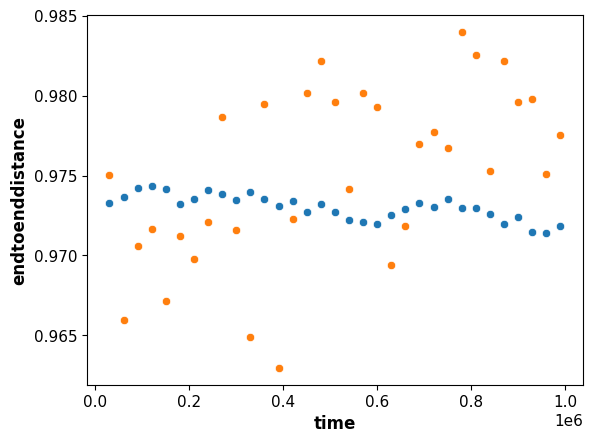

In [312]:
#fig, [ax1,ax2] = plt.subplots(2,1,sharex=True)
key = 'rw_r0-250-200_Lz10.0_nF400-50_nM4000_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_205'
#print(dicR[key]['JammedDoubleBoundMyosins'])
dicR[key]['NotjammedDoubleBoundMyosins'] = [np.sum(dicR[key]['histDoubleBoundMDistrAlongActin'][i][1]) for i in range(len(dicR[key]))]-dicR[key]['JammedDoubleBoundMyosins']
dicR[key]['notjammeddoubleboundmyosins'] = ([np.sum(dicR[key]['histDoubleBoundMDistrAlongActin'][i][1]) for i in range(len(dicR[key]))]-dicR[key]['JammedDoubleBoundMyosins'])/2/getparams(key)['nM']
dicR[key]['endtoenddistance'] = dicR[key]['EndtoendDistance']/getparams(key)['lF']
dicR[key]['endtoenddistancenotbonded'] = dicR[key]['EndtoendDistanceNotbonded']/getparams(key)['lF']
#print([np.sum(dicR[key]['histDoubleBoundMDistrAlongActin'][i][1]) for i in range(len(dicR[key]))]-dicR[key]['JammedDoubleBoundMyosins'])
dicR[key][['time','NotjammedDoubleBoundMyosins','EndtoendDistance','EndtoendDistanceNotbonded']]
sns.scatterplot(data = dicR[key], x = 'time', y = 'endtoenddistance')
sns.scatterplot(data = dicR[key], x = 'time', y = 'endtoenddistancenotbonded')
#sns.scatterplot(ax = ax2,data = dicR[key], x = 'time', y = 'notjammeddoubleboundmyosins')

Index(['time', 'RingIntactFlag', 'PercolatedFraction', 'Ravg', 'Rstd',
       'NActin', 'histAdensity', 'histABdensity', 'histAPdensity',
       'histMUdensity', 'histMBdensity', 'histActinStrainDistr',
       'ActinStrainAvg', 'histvdotnActinDistr', 'vdotnActinAvg',
       'histMDistrAlongActin', 'histDoubleBoundMDistrAlongActin',
       'EndtoendDistance', 'EndtoendDistanceBonded',
       'EndtoendDistanceNotbonded', 'JammedActins', 'JammedMyosins',
       'JammedDoubleBoundMyosins', 'MSpeedAntiparallelAvg',
       'MSpeedParallelAvg', 'MSpeedAntiparallelNotjammedAvg',
       'MSpeedParallelNotjammedAvg', 'histMSpeedAntiparallel',
       'histMSpeedParallel', 'histMSpeedAntiparallelNotjammed',
       'histMSpeedParallelNotjammed', 'MSpeedAvg', 'MSpeedNotjammedAvg',
       'histParallelMbond', 'histAntiparallelMbond'],
      dtype='object')


<Axes: xlabel='time', ylabel='EndtoendDistance'>

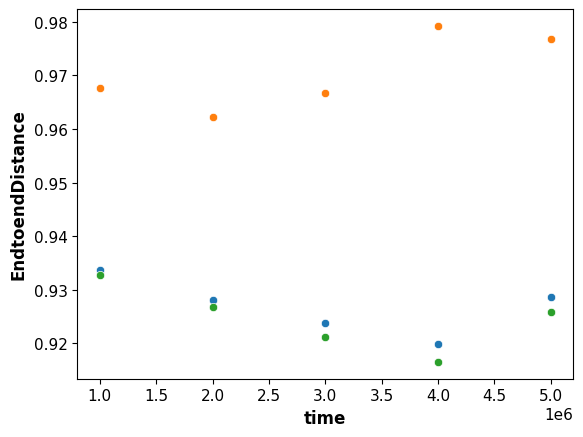

In [720]:
key = 'rw_r0-250-200_Lz10.0_nF240-50_nM2400_nC250_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-1_209'
print(dicR[key].columns)
sns.scatterplot(x = dicR[key]['time'], y = dicR[key]['EndtoendDistance']/getparams(key)['lF'])
sns.scatterplot(x = dicR[key]['time'], y = dicR[key]['EndtoendDistanceNotbonded']/getparams(key)['lF'])
sns.scatterplot(x = dicR[key]['time'], y = dicR[key]['EndtoendDistanceBonded']/getparams(key)['lF'])

<Axes: xlabel='time', ylabel='endtoenddistance'>

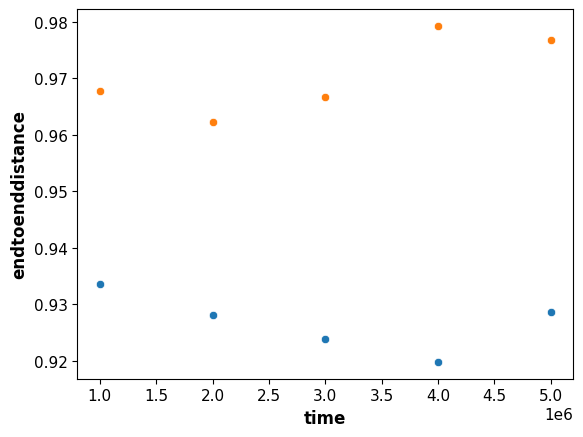

In [311]:
key = 'rw_r0-250-200_Lz10.0_nF240-50_nM2400_nC250_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-1_209'
#fig, [ax1,ax2] = plt.subplots(2,1,sharex=True)
#print(dicR[key]['JammedDoubleBoundMyosins'])
dicR[key]['NotjammedDoubleBoundMyosins'] = [np.sum(dicR[key]['histDoubleBoundMDistrAlongActin'][i][1]) for i in range(len(dicR[key]))]-dicR[key]['JammedDoubleBoundMyosins']
dicR[key]['notjammeddoubleboundmyosins'] = ([np.sum(dicR[key]['histDoubleBoundMDistrAlongActin'][i][1]) for i in range(len(dicR[key]))]-dicR[key]['JammedDoubleBoundMyosins'])/2/getparams(key)['nM']
dicR[key]['endtoenddistance'] = dicR[key]['EndtoendDistance']/getparams(key)['lF']
dicR[key]['endtoenddistancenotbonded'] = dicR[key]['EndtoendDistanceNotbonded']/getparams(key)['lF']
#print([np.sum(dicR[key]['histDoubleBoundMDistrAlongActin'][i][1]) for i in range(len(dicR[key]))]-dicR[key]['JammedDoubleBoundMyosins'])
dicR[key][['time','NotjammedDoubleBoundMyosins','EndtoendDistance','EndtoendDistanceNotbonded']]
sns.scatterplot(data = dicR[key], x = 'time', y = 'endtoenddistance')
sns.scatterplot(data = dicR[key], x = 'time', y = 'endtoenddistancenotbonded')
#sns.scatterplot(ax = ax2,data = dicR[key], x = 'time', y = 'notjammeddoubleboundmyosins')

# Other tests

### 208 e 214: only crosslinkers

In [367]:
for key in dicR.keys():
    if getparams(key)['real'] == 214: print(key)

rw_r0-250-200_Lz8.0_nF200-100_nM0_nC1600_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-0_214
rw_r0-250-200_Lz8.0_nF200-100_nM0_nC1600_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.0001-0_214
rw_r0-250-200_Lz8.0_nF200-100_nM0_nC1600_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.001-0_214
rw_r0-250-200_Lz8.0_nF200-100_nM0_nC1600_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.01-0_214
rw_r0-250-200_Lz8.0_nF200-100_nM0_nC3200_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-0_214
rw_r0-250-200_Lz8.0_nF200-100_nM0_nC3200_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.0001-0_214
rw_r0-250-200_Lz8.0_nF200-100_nM0_nC3200_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.001-0_214
rw_r0-250-200_Lz8.0_nF200-100_nM0_nC3200_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.01-0_214
rw_r0-250-200_Lz8.0_nF200-100_nM0_nC400_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-0_214
rw_r0-250-200_Lz8.0_nF200-100_nM0_nC400_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.0001-0_214
rw_r0-250-200_Lz8.0_nF200-100_nM0_nC400_R10-0

/tmp/ipykernel_112965/886152647.py:29: RuntimeWarning: divide by zero encountered in divide
  def nF2lF(nF_temp): return 12000/nF_temp


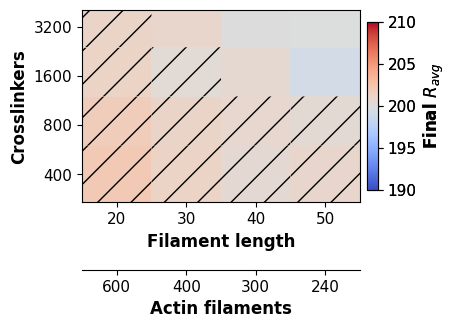

In [411]:
#Test 208: crosslinkers alone
#Constriction rate
lFs = np.array([20,30,40,50])
nCs = np.array([400,800,1600,3200])

g, ax2 = plt.subplots(1,1, sharex=True)

timestep_temp= 4900000
cmap = sns.color_palette('coolwarm',as_cmap = True)
def Ravg_temp(lF_temp,nC_temp):
    key = build_key(lF_temp = lF_temp, nF_temp = int(12000/lF_temp), nC_temp = nC_temp, nM_temp = 0, pCA_temp='0.1',pCD_temp = '0.00001',pMOC_temp = '0',sd = 208)
    try: 
        if ale_PercFrac(key,2000000) > 0.8:
            return ale_Ravg(key,timestep_temp)
        else: return np.nan
    except: return np.nan
def Ravg_temp_broken(lF_temp,nC_temp):
    key = build_key(lF_temp = lF_temp, nF_temp = int(12000/lF_temp), nC_temp = nC_temp, nM_temp = 0, pCA_temp='0.1',pCD_temp = '0.00001',pMOC_temp = '0',sd = 208)
    try: 
        if not ale_PercFrac(key,2000000) > 0.8:
            return ale_Ravg(key,timestep_temp)
        else: return np.nan
    except: return np.nan

ale_colorplot(lFs,nCs,Ravg_temp,cmap,190,210,g=g,ax=ax2,l=.92,b=.16,w=.03,h=.67,lab='Final $R_{avg}$', logay = True, ymax = 4065, ymin= 270)
ale_colorplot(lFs,nCs,Ravg_temp_broken,cmap,190,210,g=g,ax=ax2,l=.92,b=.16,w=.03,h=.67,lab='Final $R_{avg}$', logay = True, ymax = 4065, ymin= 270, hatch='/')

def lF2nF(lF_temp): return 12000/lF_temp
def nF2lF(nF_temp): return 12000/nF_temp

secax2 = ax2.secondary_xaxis(-0.35, functions=(lF2nF,nF2lF))
secax2.set_xlabel('Actin filaments')
secax2.set_xticks([240,300,400,600])

ax2.set_ylabel('Crosslinkers')
ax2.set_xlabel('Filament length')
g.figure.set_figwidth(3.5)
g.figure.set_figheight(2.5)
plt.show()


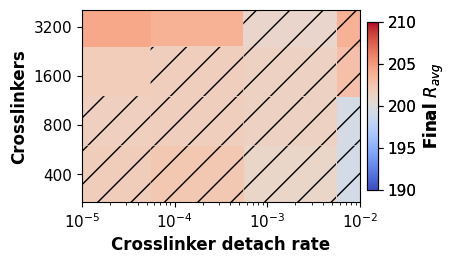

In [400]:
#Test 208: crosslinkers alone
#Constriction rate
pCDs = np.array(['0.01','0.001','0.0001','0.00001'])
nCs = np.array([400,800,1600,3200])

g, ax2 = plt.subplots(1,1, sharex=True)
timestep_temp= 19000000

cmap = sns.color_palette('coolwarm',as_cmap = True)
def Ravg_temp(pCD_temp,nC_temp):
    key = build_key(Lz_temp='5.0',lF_temp = 50, nF_temp = 150, nC_temp = nC_temp, nM_temp = 0, pCA_temp='0.1',pCD_temp = pCD_temp,pMOC_temp = '0',pMDE_temp='1',sd = 208)
    try: 
        if ale_PercFrac(key,2000000) > 0.8:
            return ale_Ravg(key,timestep_temp)
        else: return np.nan
    except: return np.nan
def Ravg_temp_broken(pCD_temp,nC_temp):
    key = build_key(Lz_temp='5.0',lF_temp = 50, nF_temp = 150, nC_temp = nC_temp, nM_temp = 0, pCA_temp='0.1',pCD_temp = pCD_temp,pMOC_temp = '0',pMDE_temp='1',sd = 208)
    try: 
        if not ale_PercFrac(key,2000000) > 0.8:
            return ale_Ravg(key,timestep_temp)
        else: return np.nan
    except: return np.nan


ale_colorplot(pCDs,nCs,Ravg_temp,cmap,190,210,g=g,ax=ax2,l=.92,b=.16,w=.03,h=.67,lab='Final $R_{avg}$', logay = True, logax= True, ymax = 4065, ymin= 270, xmin = 0.00001, xmax = 0.01)
ale_colorplot(pCDs,nCs,Ravg_temp_broken,cmap,190,210,g=g,ax=ax2,l=.92,b=.16,w=.03,h=.67,lab='Final $R_{avg}$', logay = True, logax= True, ymax = 4065, ymin= 270, xmin = 0.00001, xmax = 0.01, hatch='/')
ax2.set_ylabel('Crosslinkers')
ax2.set_xlabel('Crosslinker detach rate')
g.figure.set_figwidth(3.5)
g.figure.set_figheight(2.5)
plt.show()

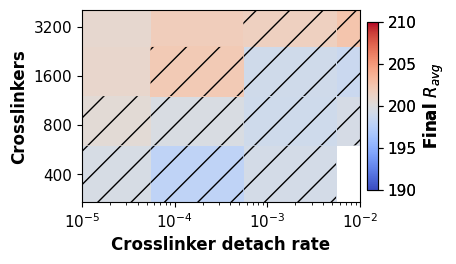

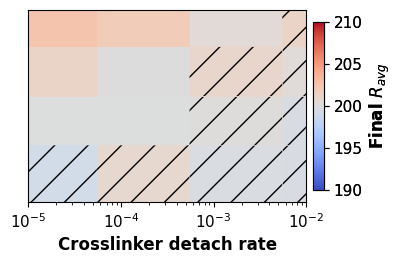

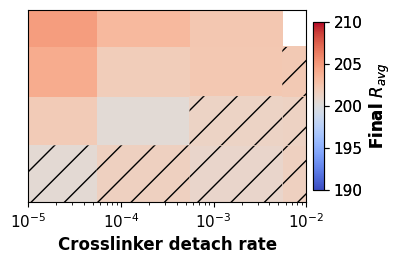

In [396]:
#Test 214: crosslinkers alone
#Constriction rate
for lF_temp in [50, 100, 150]:
    pCDs = np.array(['0.01','0.001','0.0001','0.00001'])
    nCs = np.array([400,800,1600,3200])

    g, ax2 = plt.subplots(1,1, sharex=True)
    timestep_temp= 19000000
    cmap = sns.color_palette('coolwarm',as_cmap = True)
    def Ravg_temp(pCD_temp,nC_temp):
        key = build_key(Lz_temp='8.0',lF_temp = lF_temp, nF_temp = 200, nC_temp = nC_temp, nM_temp = 0, pCA_temp='0.1',pCD_temp = pCD_temp,pMOC_temp = '0',pMDE_temp='0.00001',sd = 214)
        try: 
            if ale_PercFrac(key,2000000) > 0.8:
                return ale_Ravg(key,timestep_temp)
            else: return np.nan
        except: return np.nan
    def Ravg_temp_broken(pCD_temp,nC_temp):
        key = build_key(Lz_temp='8.0',lF_temp = lF_temp, nF_temp = 200, nC_temp = nC_temp, nM_temp = 0, pCA_temp='0.1',pCD_temp = pCD_temp,pMOC_temp = '0',pMDE_temp='0.00001',sd = 214)
        try: 
            if not ale_PercFrac(key,2000000) > 0.8:
                return ale_Ravg(key,timestep_temp)
            else: return np.nan
        except: return np.nan

    
    ale_colorplot(pCDs,nCs,Ravg_temp,cmap,190,210,g=g,ax=ax2,l=.92,b=.16,w=.03,h=.67,lab='Final $R_{avg}$', logay = True, logax= True, ymax = 4065, ymin= 270, xmin = 0.00001, xmax = 0.01)
    ale_colorplot(pCDs,nCs,Ravg_temp_broken,cmap,190,210,g=g,ax=ax2,l=.92,b=.16,w=.03,h=.67,lab='Final $R_{avg}$', logay = True, logax= True, ymax = 4065, ymin= 270, xmin = 0.00001, xmax = 0.01, hatch='/')
    if lF_temp == 50: 
        ax2.set_ylabel('Crosslinkers')
    else: 
        ax2.set_ylabel('')
        ax2.set_yticks([])
    ax2.set_xlabel('Crosslinker detach rate')
    g.figure.set_figwidth(3.5)
    g.figure.set_figheight(2.5)
    plt.show()

### 209: crosslinkers and motors, dwelling, overtaking

/tmp/ipykernel_203315/2597516753.py:27: RuntimeWarning: divide by zero encountered in divide
  def nM2nC(nM_temp): return 600000/nM_temp
/tmp/ipykernel_203315/2597516753.py:34: RuntimeWarning: divide by zero encountered in divide
  def nF2lF(nF_temp): return 12000/nF_temp


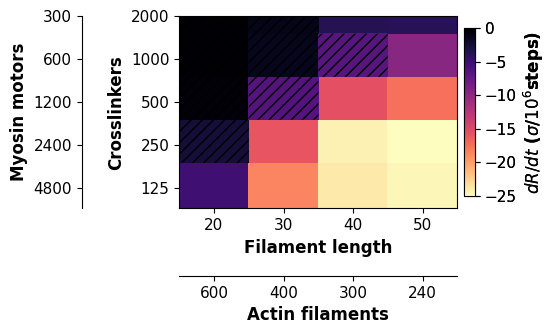

In [46]:
#Test 209: crosslinkers and motors, dwelling, overtaking 
# Constriction rate
lFs = np.array([20,30,40,50])
nCs = np.array([125,250,500,1000,2000])

g, ax2 = plt.subplots(1,1, sharex=True)
timestep_temp= 4000000
def rate_temp(lF_temp,nC_temp):
    key = build_key(lF_temp = lF_temp, nF_temp = int(12000/lF_temp), nC_temp = nC_temp, nM_temp = int(600000/nC_temp), pCA_temp='0.1',pCD_temp = '0.00001',pMOC_temp = '1',sd = 209)
    try: 
        if ale_PercFrac(key,timestep_temp) > 0.8:
            return 1000000*ale_rate_constrict(key,timestep_temp)
        else: return np.nan
    except KeyError: return np.nan
def rate_temp_broken(lF_temp,nC_temp):
    key = build_key(lF_temp = lF_temp, nF_temp = int(12000/lF_temp), nC_temp = nC_temp, nM_temp = int(600000/nC_temp), pCA_temp='0.1',pCD_temp = '0.00001',pMOC_temp = '1',sd = 209)
    try: 
        if not ale_PercFrac(key,timestep_temp) > 0.8:
            return 1000000*ale_rate_constrict(key,timestep_temp)
        else: return np.nan
    except KeyError: return np.nan

ale_colorplot(lFs,nCs,rate_temp,cmap,-25,0,g=g,ax=ax2,l=.92,b=.16,w=.03,h=.67,lab='$dR/dt$ ($\sigma$/$10^6$steps)', logay = True, ymax = 1270,ymin=90)
ale_colorplot(lFs,nCs,rate_temp_broken,cmap,-25,0,g=g,ax=ax2,l=.92,b=.16,w=.03,h=.67,lab='$dR/dt$ ($\sigma$/$10^6$steps)', logay = True, ymax = 1270,ymin=90, hatch='///')

def nC2nM(nC_temp): return 600000/nC_temp
def nM2nC(nM_temp): return 600000/nM_temp
secay2 = ax2.secondary_yaxis(-0.35, functions=(nC2nM,nM2nC))
secay2.set_ylabel('Myosin motors')
secay2.set_yticks([600,1200,2400,4800,300],[600,1200,2400,4800,300])
secay2.set_yticks([],minor = True)

def lF2nF(lF_temp): return 12000/lF_temp
def nF2lF(nF_temp): return 12000/nF_temp

secax2 = ax2.secondary_xaxis(-0.35, functions=(lF2nF,nF2lF))
secax2.set_xlabel('Actin filaments')
secax2.set_xticks([240,300,400,600])

ax2.set_ylabel('Crosslinkers')
ax2.set_xlabel('Filament length')
g.figure.set_figwidth(3.5)
g.figure.set_figheight(2.5)
plt.show()

/tmp/ipykernel_203315/3668624289.py:30: RuntimeWarning: divide by zero encountered in divide
  def nM2nC(nM_temp): return 600000/nM_temp


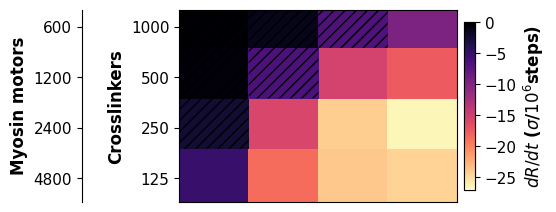

In [62]:
#Test 209: crosslinkers and motors, dwelling, overtaking 
# Constriction rate
lFs = np.array([20,30,40,50])
nCs = np.array([125,250,500,1000])

g, ax2 = plt.subplots(1,1, sharex=True)
timestep_temp= 4000000
def rate_temp(lF_temp,nC_temp):
    key = build_key(lF_temp = lF_temp, nF_temp = int(12000/lF_temp), nC_temp = nC_temp, nM_temp = int(600000/nC_temp), pCA_temp='0.1',pCD_temp = '0.00001',pMOC_temp = '1',sd = 209)
    try: 
        if ale_PercFrac(key,timestep_temp) > 0.8:
            return 1000000*ale_rate_constrict(key,timestep_temp)
        else: return np.nan
    except KeyError: return np.nan
def rate_temp_broken(lF_temp,nC_temp):
    key = build_key(lF_temp = lF_temp, nF_temp = int(12000/lF_temp), nC_temp = nC_temp, nM_temp = int(600000/nC_temp), pCA_temp='0.1',pCD_temp = '0.00001',pMOC_temp = '1',sd = 209)
    try: 
        if not ale_PercFrac(key,timestep_temp) > 0.8:
            return 1000000*ale_rate_constrict(key,timestep_temp)
        else: return np.nan
    except KeyError: return np.nan

cax = ale_colorplot(lFs,nCs,rate_temp,cmap,-27,0,g=g,ax=ax2,l=.92,b=.16,w=.03,h=.67,lab='$dR/dt$ ($\sigma$/$10^6$steps)', logay = True, ymax = 1270,ymin=90)
cax1 = ale_colorplot(lFs,nCs,rate_temp_broken,cmap,-27,0,g=g,ax=ax2,l=.92,b=.16,w=.03,h=.67,lab='$dR/dt$ ($\sigma$/$10^6$steps)', logay = True, ymax = 1270,ymin=90, hatch='///')
cax.set_yticks([0,-5,-10,-15,-20,-25])
cax1.set_yticks([])
cax1.set_ylabel('')

def nC2nM(nC_temp): return 600000/nC_temp
def nM2nC(nM_temp): return 600000/nM_temp
secay2 = ax2.secondary_yaxis(-0.35, functions=(nC2nM,nM2nC))
secay2.set_ylabel('Myosin motors')
secay2.set_yticks([600,1200,2400,4800,300],[600,1200,2400,4800,300])
secay2.set_yticks([],minor = True)

"""def lF2nF(lF_temp): return 12000/lF_temp
def nF2lF(nF_temp): return 12000/nF_temp

secax2 = ax2.secondary_xaxis(-0.35, functions=(lF2nF,nF2lF))
secax2.set_xlabel('Actin filaments')
secax2.set_xticks([240,300,400,600])
ax2.set_xlabel('Filament length')"""

ax2.set_xticks([])
ax2.set_ylabel('Crosslinkers')
g.figure.set_figwidth(3.5)
g.figure.set_figheight(2.5)
plt.show()

### 210: crosslinkers and motors, dwelling, no overtaking

/tmp/ipykernel_203315/3507936783.py:39: RankWarning: Polyfit may be poorly conditioned
  m, q = np.polyfit(x = data_temp['time'],y = data_temp['Ravg'],deg = 1)
/tmp/ipykernel_203315/987312310.py:18: RuntimeWarning: divide by zero encountered in divide
  def nM2nC(nM_temp): return 600000/nM_temp
/tmp/ipykernel_203315/987312310.py:25: RuntimeWarning: divide by zero encountered in divide
  def nF2lF(nF_temp): return 12000/nF_temp


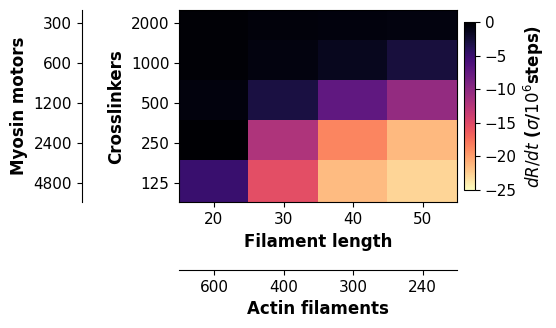

In [61]:
#Test 210: crosslinkers and motors, dwelling, no overtaking
# Constriction rate
lFs = np.array([20,30,40,50])
nCs = np.array([125,250,500,1000,2000])

g, ax2 = plt.subplots(1,1, sharex=True)
timestep_temp= 4000000

cmap = sns.color_palette('magma_r',as_cmap = True)
def rate_temp(lF_temp,nC_temp):
    try: return 1000000*ale_rate_constrict(build_key(lF_temp = lF_temp, nF_temp = int(12000/lF_temp), nC_temp = nC_temp, nM_temp = int(600000/nC_temp), pCA_temp='0.1',pCD_temp = '0.00001',pMOC_temp = '0',sd = 210),timestep_temp)
    except KeyError: 
        print(build_key(lF_temp = lF_temp, nF_temp = 12000/lF_temp, nC_temp = nC_temp, nM_temp = int(600000/nC_temp), pCA_temp='0.1',pCD_temp = '0.00001',pMOC_temp = '0',sd = 209))
        return np.nan
cax = ale_colorplot(lFs,nCs,rate_temp,cmap,-2.5*10**(1),0,g=g,ax=ax2,l=.92,b=.16,w=.03,h=.67,lab='$dR/dt$ ($\sigma$/$10^6$steps)', logay = True, ymax = 2500,ymin= 90)

def nC2nM(nC_temp): return 600000/nC_temp
def nM2nC(nM_temp): return 600000/nM_temp
secay2 = ax2.secondary_yaxis(-0.35, functions=(nC2nM,nM2nC))
secay2.set_ylabel('Myosin motors')
secay2.set_yticks([600,1200,2400,4800,300],[600,1200,2400,4800,300])
secay2.set_yticks([],minor = True)

def lF2nF(lF_temp): return 12000/lF_temp
def nF2lF(nF_temp): return 12000/nF_temp

secax2 = ax2.secondary_xaxis(-0.35, functions=(lF2nF,nF2lF))
secax2.set_xlabel('Actin filaments')
secax2.set_xticks([240,300,400,600])

cax.set_yticks([0,-5,-10,-15,-20,-25])

ax2.set_ylabel('Crosslinkers')
ax2.set_xlabel('Filament length')
g.figure.set_figwidth(3.5)
g.figure.set_figheight(2.5)
plt.show()

/tmp/ipykernel_203315/3507936783.py:39: RankWarning: Polyfit may be poorly conditioned
  m, q = np.polyfit(x = data_temp['time'],y = data_temp['Ravg'],deg = 1)
/tmp/ipykernel_203315/943277057.py:31: RuntimeWarning: divide by zero encountered in divide
  def nM2nC(nM_temp): return 600000/nM_temp
/tmp/ipykernel_203315/943277057.py:38: RuntimeWarning: divide by zero encountered in divide
  def nF2lF(nF_temp): return 12000/nF_temp


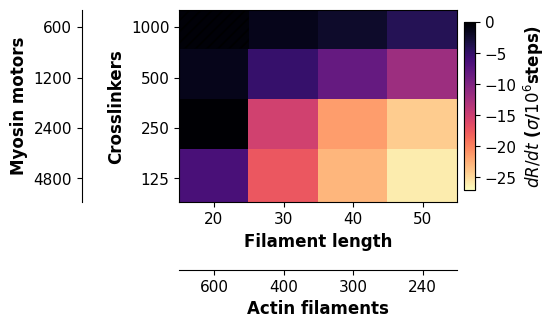

In [63]:
#Test 210: crosslinkers and motors, dwelling, no overtaking
# Constriction rate
lFs = np.array([20,30,40,50])
nCs = np.array([125,250,500,1000])

g, ax2 = plt.subplots(1,1, sharex=True)
timestep_temp= 2000000
cmap = sns.color_palette('magma_r',as_cmap = True)
def rate_temp(lF_temp,nC_temp):
    key = build_key(lF_temp = lF_temp, nF_temp = int(12000/lF_temp), nC_temp = nC_temp, nM_temp = int(600000/nC_temp), pCA_temp='0.1',pCD_temp = '0.00001',pMOC_temp = '0',sd = 210)
    try: 
        if ale_PercFrac(key,0) > 0.8:
            return 1000000*ale_rate_constrict(key,timestep_temp)
        else: return np.nan
    except KeyError: return np.nan
def rate_temp_broken(lF_temp,nC_temp):
    key = build_key(lF_temp = lF_temp, nF_temp = int(12000/lF_temp), nC_temp = nC_temp, nM_temp = int(600000/nC_temp), pCA_temp='0.1',pCD_temp = '0.00001',pMOC_temp = '0',sd = 210)
    try: 
        if not ale_PercFrac(key,0) > 0.8:
            return 1000000*ale_rate_constrict(key,timestep_temp)
        else: return np.nan
    except KeyError: return np.nan

cax = ale_colorplot(lFs,nCs,rate_temp,cmap,-27,0,g=g,ax=ax2,l=.92,b=.16,w=.03,h=.67,lab='$dR/dt$ ($\sigma$/$10^6$steps)', logay = True, ymax = 1270,ymin=90)
cax1 = ale_colorplot(lFs,nCs,rate_temp_broken,cmap,-27,0,g=g,ax=ax2,l=.92,b=.16,w=.03,h=.67,lab='$dR/dt$ ($\sigma$/$10^6$steps)', logay = True, ymax = 1270,ymin=90, hatch='///')
cax.set_yticks([0,-5,-10,-15,-20,-25])
cax1.set_yticks([])
cax1.set_ylabel('')

def nC2nM(nC_temp): return 600000/nC_temp
def nM2nC(nM_temp): return 600000/nM_temp
secay2 = ax2.secondary_yaxis(-0.35, functions=(nC2nM,nM2nC))
secay2.set_ylabel('Myosin motors')
secay2.set_yticks([600,1200,2400,4800,300],[600,1200,2400,4800,300])
secay2.set_yticks([],minor = True)

def lF2nF(lF_temp): return 12000/lF_temp
def nF2lF(nF_temp): return 12000/nF_temp

secax2 = ax2.secondary_xaxis(-0.35, functions=(lF2nF,nF2lF))
secax2.set_xlabel('Actin filaments')
secax2.set_xticks([240,300,400,600])

ax2.set_ylabel('Crosslinkers')
ax2.set_xlabel('Filament length')
g.figure.set_figwidth(3.5)
g.figure.set_figheight(2.5)
plt.show()

### 211 and 216: crosslinkers and motors, no dwelling, overtaking

In [241]:
for key in dicR.keys():
    if getparams(key)['real'] == 217: print(key)

rw_r0-250-200_Lz10.0_nF400-50_nM300_nC1000_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0.1-0.00001-1_217
rw_r0-250-200_Lz10.0_nF400-50_nM300_nC2000_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0.1-0.00001-1_217
rw_r0-250-200_Lz10.0_nF400-50_nM300_nC4000_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0.1-0.00001-1_217
rw_r0-250-200_Lz10.0_nF400-50_nM300_nC8000_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0.1-0.00001-1_217
rw_r0-250-200_Lz10.0_nF400-50_nM600_nC1000_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0.1-0.00001-1_217
rw_r0-250-200_Lz10.0_nF400-50_nM600_nC2000_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0.1-0.00001-1_217
rw_r0-250-200_Lz10.0_nF400-50_nM600_nC4000_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0.1-0.00001-1_217
rw_r0-250-200_Lz10.0_nF400-50_nM600_nC8000_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0.1-0.00001-1_217
rw_r0-250-200_Lz10.0_nF400-50_nM1200_nC1000_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0.1-0.00001-1_217
rw_r0-250-200_Lz10.0_nF400-50_nM1200_nC2000_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0.1-0.00001-1_217
rw_r0-250-200_Lz10.0_nF400-50_nM1200_nC4000_R10-0-0-0-0-0-0-0.1-1-0.

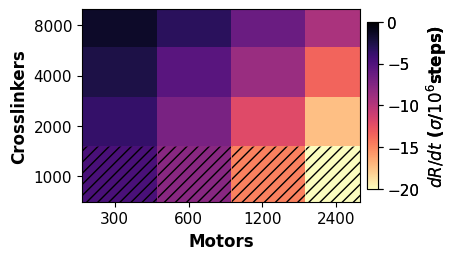

In [270]:
# Constriction rate
nCs = np.array([1000,2000,4000,8000])
nMs = np.array([300,600,1200,2400])

g, ax2 = plt.subplots(1,1, sharex=True)
timestep_temp= 2000000

cmap = sns.color_palette('magma_r',as_cmap = True)
def rate_temp(nM_temp,nC_temp):
    key = build_key(nM_temp = nM_temp, nC_temp = nC_temp, pMDE_temp = '1',pCA_temp='0.1',pCD_temp = '0.00001',pMOC_temp = '1',sd = 217)
    try: 
        if ale_PercFrac(key,timestep_temp) > 0.8:
            return 1000000*ale_rate_constrict(key,timestep_temp)
        else: return np.nan
    except KeyError: return np.nan
def rate_temp_broken(nM_temp,nC_temp):
    key = build_key(nM_temp = nM_temp, nC_temp = nC_temp, pMDE_temp = '1',pCA_temp='0.1',pCD_temp = '0.00001',pMOC_temp = '1',sd = 217)
    try: 
        if not ale_PercFrac(key,timestep_temp) > 0.8:
            return 1000000*ale_rate_constrict(key,timestep_temp)
        else: return np.nan
    except KeyError: return np.nan

ale_colorplot(nMs,nCs,rate_temp,cmap,-20,0,g=g,ax=ax2,l=.92,b=.16,w=.03,h=.67,lab='$dR/dt$ ($\sigma$/$10^6$steps)', logay = True, ymin=700,ymax = 10000, logax = True,xmin = 220, xmax = 3000)
ale_colorplot(nMs,nCs,rate_temp_broken,cmap,-20,0,g=g,ax=ax2,l=.92,b=.16,w=.03,h=.67,lab='$dR/dt$ ($\sigma$/$10^6$steps)', logay = True, ymin=700,ymax = 10000, logax = True,xmin = 220, xmax = 3000, hatch='///')

ax2.set_ylabel('Crosslinkers')
ax2.set_xlabel('Motors')
g.figure.set_figwidth(3.5)
g.figure.set_figheight(2.5)
plt.show()

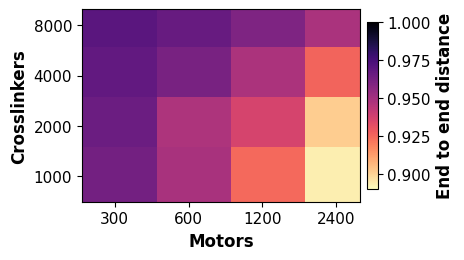

In [275]:
# Constriction rate
nCs = np.array([1000,2000,4000,8000])
nMs = np.array([300,600,1200,2400])

g, ax2 = plt.subplots(1,1, sharex=True)
timestep_temp= 2000000

cmap = sns.color_palette('magma_r',as_cmap = True)
def endtoend_temp(nM_temp,nC_temp):
    key = build_key(nM_temp = nM_temp, nC_temp = nC_temp, pMDE_temp = '1',pCA_temp='0.1',pCD_temp = '0.00001',pMOC_temp = '1',sd = 217)
    try: return ale_endtoend(key,timestep_temp)
    except KeyError: 
        return np.nan
ale_colorplot(nMs,nCs,endtoend_temp,cmap,.89,1,g=g,ax=ax2,l=.92,b=.16,w=.03,h=.67,lab='End to end distance', logay = True, ymin=700,ymax = 10000, logax = True,xmin = 220, xmax = 3000)

ax2.set_ylabel('Crosslinkers')
ax2.set_xlabel('Motors')
g.figure.set_figwidth(3.5)
g.figure.set_figheight(2.5)
plt.show()

/tmp/ipykernel_203315/3985576654.py:28: RuntimeWarning: divide by zero encountered in divide
  def nM2nC(nM_temp): return 600000/nM_temp
/tmp/ipykernel_203315/3985576654.py:35: RuntimeWarning: divide by zero encountered in divide
  def nF2lF(nF_temp): return 12000/nF_temp


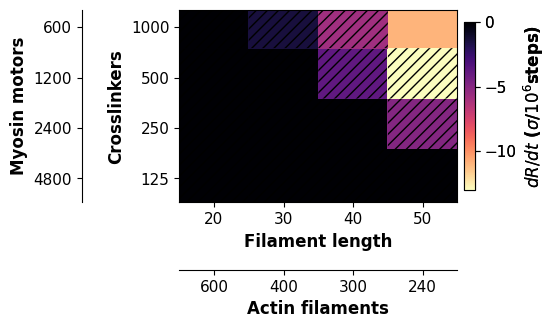

In [81]:
# Constriction rate
lFs = np.array([20,30,40,50])
nCs = np.array([125,250,500,1000])

g, ax2 = plt.subplots(1,1, sharex=True)
timestep_temp= 2000000

cmap = sns.color_palette('magma_r',as_cmap = True)
def rate_temp(lF_temp,nC_temp):
    key = build_key(lF_temp = lF_temp, nF_temp = int(12000/lF_temp), nC_temp = nC_temp, nM_temp = int(600000/nC_temp), pMDE_temp = '1',pCA_temp='0.1',pCD_temp = '0.00001',pMOC_temp = '1',sd = 211)
    try: 
        if ale_PercFrac(key,timestep_temp) > 0.8:
            return 1000000*ale_rate_constrict(key,timestep_temp)
        else: return np.nan
    except KeyError: return np.nan
def rate_temp_broken(lF_temp,nC_temp):
    key = build_key(lF_temp = lF_temp, nF_temp = int(12000/lF_temp), nC_temp = nC_temp, nM_temp = int(600000/nC_temp), pMDE_temp = '1',pCA_temp='0.1',pCD_temp = '0.00001',pMOC_temp = '1',sd = 211)
    try: 
        if not ale_PercFrac(key,timestep_temp) > 0.8:
            return 1000000*ale_rate_constrict(key,timestep_temp)
        else: return np.nan
    except KeyError: return np.nan

ale_colorplot(lFs,nCs,rate_temp,cmap,-13,0,g=g,ax=ax2,l=.92,b=.16,w=.03,h=.67,lab='$dR/dt$ ($\sigma$/$10^6$steps)', logay = True, ymax = 1270,ymin=90)
ale_colorplot(lFs,nCs,rate_temp_broken,cmap,-13,0,g=g,ax=ax2,l=.92,b=.16,w=.03,h=.67,lab='$dR/dt$ ($\sigma$/$10^6$steps)', logay = True, ymax = 1270,ymin=90, hatch='///')

def nC2nM(nC_temp): return 600000/nC_temp
def nM2nC(nM_temp): return 600000/nM_temp
secay2 = ax2.secondary_yaxis(-0.35, functions=(nC2nM,nM2nC))
secay2.set_ylabel('Myosin motors')
secay2.set_yticks([600,1200,2400,4800],[600,1200,2400,4800])
secay2.set_yticks([],minor = True)

def lF2nF(lF_temp): return 12000/lF_temp
def nF2lF(nF_temp): return 12000/nF_temp

secax2 = ax2.secondary_xaxis(-0.35, functions=(lF2nF,nF2lF))
secax2.set_xlabel('Actin filaments')
secax2.set_xticks([240,300,400,600])

ax2.set_ylabel('Crosslinkers')
ax2.set_xlabel('Filament length')
g.figure.set_figwidth(3.5)
g.figure.set_figheight(2.5)
plt.show()

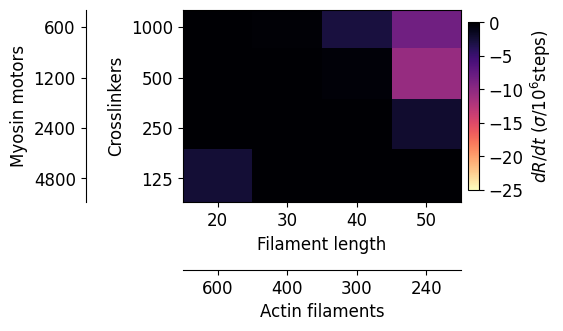

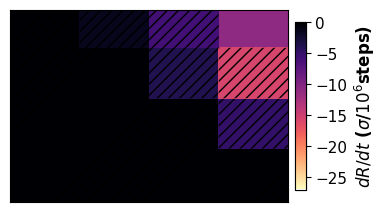

In [65]:
# Constriction rate
lFs = np.array([20,30,40,50])
nCs = np.array([125,250,500,1000])

g, ax2 = plt.subplots(1,1, sharex=True)
timestep_temp= 2000000

cmap = sns.color_palette('magma_r',as_cmap = True)
def rate_temp(lF_temp,nC_temp):
    key = build_key(lF_temp = lF_temp, nF_temp = int(12000/lF_temp), nC_temp = nC_temp, nM_temp = int(600000/nC_temp), pMDE_temp = '1',pCA_temp='0.1',pCD_temp = '0.00001',pMOC_temp = '1',sd = 211)
    try: 
        if ale_PercFrac(key,timestep_temp) > 0.8:
            return 1000000*ale_rate_constrict(key,timestep_temp)
        else: return np.nan
    except KeyError: return np.nan
def rate_temp_broken(lF_temp,nC_temp):
    key = build_key(lF_temp = lF_temp, nF_temp = int(12000/lF_temp), nC_temp = nC_temp, nM_temp = int(600000/nC_temp), pMDE_temp = '1',pCA_temp='0.1',pCD_temp = '0.00001',pMOC_temp = '1',sd = 211)
    try: 
        if not ale_PercFrac(key,timestep_temp) > 0.8:
            return 1000000*ale_rate_constrict(key,timestep_temp)
        else: return np.nan
    except KeyError: return np.nan

cax = ale_colorplot(lFs,nCs,rate_temp,cmap,-27,0,g=g,ax=ax2,l=.92,b=.16,w=.03,h=.67,lab='$dR/dt$ ($\sigma$/$10^6$steps)', logay = True, ymax = 1270,ymin=90)
cax1 = ale_colorplot(lFs,nCs,rate_temp_broken,cmap,-27,0,g=g,ax=ax2,l=.92,b=.16,w=.03,h=.67,lab='$dR/dt$ ($\sigma$/$10^6$steps)', logay = True, ymax = 1270,ymin=90, hatch='///')
cax.set_yticks([0,-5,-10,-15,-20,-25])
cax1.set_yticks([])
cax1.set_ylabel('')

ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel('')
g.figure.set_figwidth(3.5)
g.figure.set_figheight(2.5)
plt.show()

/tmp/ipykernel_112965/3644644575.py:16: RuntimeWarning: divide by zero encountered in divide
  def nM2nC(nM_temp): return 600000/nM_temp
/tmp/ipykernel_112965/3644644575.py:23: RuntimeWarning: divide by zero encountered in divide
  def nF2lF(nF_temp): return 12000/nF_temp


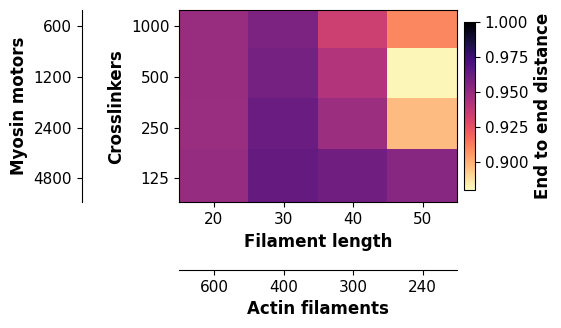

In [726]:
#End to end
lFs = np.array([20,30,40,50])
nCs = np.array([125,250,500,1000])

g, ax2 = plt.subplots(1,1, sharex=True)
timestep_temp= 4000000

cmap = sns.color_palette('magma_r',as_cmap = True)
def endtoend_temp(lF_temp,nC_temp):
    try: return ale_endtoend(build_key(lF_temp = lF_temp, nF_temp = int(12000/lF_temp), nC_temp = nC_temp, nM_temp = int(600000/nC_temp), pMDE_temp = '1',pCA_temp='0.1',pCD_temp = '0.00001',pMOC_temp = '1',sd = 211),timestep_temp)
    except KeyError: 
        return np.nan
ale_colorplot(lFs,nCs,endtoend_temp,cmap,.88,1,g=g,ax=ax2,l=.92,b=.16,w=.03,h=.67,lab='End to end distance', logay = True, ymax = 1250,ymin= 90)

def nC2nM(nC_temp): return 600000/nC_temp
def nM2nC(nM_temp): return 600000/nM_temp
secay2 = ax2.secondary_yaxis(-0.35, functions=(nC2nM,nM2nC))
secay2.set_ylabel('Myosin motors')
secay2.set_yticks([600,1200,2400,4800],[600,1200,2400,4800])
secay2.set_yticks([],minor = True)

def lF2nF(lF_temp): return 12000/lF_temp
def nF2lF(nF_temp): return 12000/nF_temp

secax2 = ax2.secondary_xaxis(-0.35, functions=(lF2nF,nF2lF))
secax2.set_xlabel('Actin filaments')
secax2.set_xticks([240,300,400,600])

ax2.set_ylabel('Crosslinkers')
ax2.set_xlabel('Filament length')
g.figure.set_figwidth(3.5)
g.figure.set_figheight(2.5)
plt.show()

In [710]:
for key in dicR.keys():
    if getparams(key)['real'] == 215:
        print(key)

rw_r0-250-200_Lz10.0_nF200-60_nM1200_nC500_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0.1-0.00001-0_215
rw_r0-250-200_Lz10.0_nF200-60_nM2400_nC250_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0.1-0.00001-0_215
rw_r0-250-200_Lz10.0_nF200-60_nM4800_nC125_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0.1-0.00001-0_215
rw_r0-250-200_Lz10.0_nF200-60_nM600_nC1000_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0.1-0.00001-0_215
rw_r0-250-200_Lz10.0_nF240-50_nM1200_nC500_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0.1-0.00001-0_215
rw_r0-250-200_Lz10.0_nF240-50_nM2400_nC250_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0.1-0.00001-0_215
rw_r0-250-200_Lz10.0_nF240-50_nM4800_nC125_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0.1-0.00001-0_215
rw_r0-250-200_Lz10.0_nF240-50_nM600_nC1000_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0.1-0.00001-0_215
rw_r0-250-200_Lz10.0_nF300-40_nM1200_nC500_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0.1-0.00001-0_215
rw_r0-250-200_Lz10.0_nF300-40_nM2400_nC250_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0.1-0.00001-0_215
rw_r0-250-200_Lz10.0_nF300-40_nM4800_nC125_R10-0-0-0-0-0-0-0.1-1-0.000

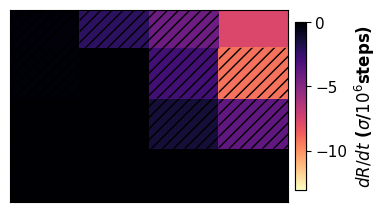

In [85]:
# Constriction rate for test 215: less flexible filaments

lFs = np.array([20,30,40,50])
nCs = np.array([125,250,500,1000])

cmap = sns.color_palette('magma_r',as_cmap = True)

g, ax2 = plt.subplots(1,1, sharex=True)
timestep_temp= 2000000
def rate_temp(lF_temp,nC_temp):
    key = build_key(lF_temp = lF_temp, nF_temp = int(12000/lF_temp), nC_temp = nC_temp, nM_temp = int(600000/nC_temp), pMDE_temp = '1',pCA_temp='0.1',pCD_temp = '0.00001',pMOC_temp = '1',sd = 216)
    try: 
        if ale_PercFrac(key,timestep_temp) > 0.8:
            return 1000000*ale_rate_constrict(key,timestep_temp)
        else: return np.nan
    except KeyError: return np.nan
def rate_temp_broken(lF_temp,nC_temp):
    key = build_key(lF_temp = lF_temp, nF_temp = int(12000/lF_temp), nC_temp = nC_temp, nM_temp = int(600000/nC_temp), pMDE_temp = '1',pCA_temp='0.1',pCD_temp = '0.00001',pMOC_temp = '1',sd = 216)
    try: 
        if not ale_PercFrac(key,timestep_temp) > 0.8:
            return 1000000*ale_rate_constrict(key,timestep_temp)
        else: return np.nan
    except KeyError: return np.nan

cax = ale_colorplot(lFs,nCs,rate_temp,cmap,-13,0,g=g,ax=ax2,l=.92,b=.16,w=.03,h=.67,lab='$dR/dt$ ($\sigma$/$10^6$steps)', logay = True, ymax = 1270,ymin=90)
cax1 = ale_colorplot(lFs,nCs,rate_temp_broken,cmap,-13,0,g=g,ax=ax2,l=.92,b=.16,w=.03,h=.67,lab='$dR/dt$ ($\sigma$/$10^6$steps)', logay = True, ymax = 1270,ymin=90, hatch='///')
cax.set_yticks([0,-5,-10])
cax1.set_yticks([])
cax1.set_ylabel('')

ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel('')
g.figure.set_figwidth(3.5)
g.figure.set_figheight(2.5)
plt.show()

/tmp/ipykernel_112965/917940342.py:16: RuntimeWarning: divide by zero encountered in divide
  def nM2nC(nM_temp): return 600000/nM_temp
/tmp/ipykernel_112965/917940342.py:23: RuntimeWarning: divide by zero encountered in divide
  def nF2lF(nF_temp): return 12000/nF_temp


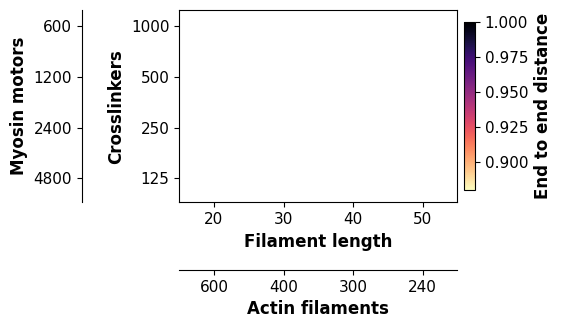

In [730]:
#End to end
lFs = np.array([20,30,40,50])
nCs = np.array([125,250,500,1000])

g, ax2 = plt.subplots(1,1, sharex=True)
timestep_temp= 4000000

cmap = sns.color_palette('magma_r',as_cmap = True)
def endtoend_temp(lF_temp,nC_temp):
    try: return ale_endtoend(build_key(lF_temp = lF_temp, nF_temp = int(12000/lF_temp), nC_temp = nC_temp, nM_temp = int(600000/nC_temp), pMDE_temp = '1',pCA_temp='0.1',pCD_temp = '0.00001',pMOC_temp = '1',sd = 216),timestep_temp)
    except KeyError: 
        return np.nan
ale_colorplot(lFs,nCs,endtoend_temp,cmap,.88,1,g=g,ax=ax2,l=.92,b=.16,w=.03,h=.67,lab='End to end distance', logay = True, ymax = 1250,ymin= 90)

def nC2nM(nC_temp): return 600000/nC_temp
def nM2nC(nM_temp): return 600000/nM_temp
secay2 = ax2.secondary_yaxis(-0.35, functions=(nC2nM,nM2nC))
secay2.set_ylabel('Myosin motors')
secay2.set_yticks([600,1200,2400,4800],[600,1200,2400,4800])
secay2.set_yticks([],minor = True)

def lF2nF(lF_temp): return 12000/lF_temp
def nF2lF(nF_temp): return 12000/nF_temp

secax2 = ax2.secondary_xaxis(-0.35, functions=(lF2nF,nF2lF))
secax2.set_xlabel('Actin filaments')
secax2.set_xticks([240,300,400,600])

ax2.set_ylabel('Crosslinkers')
ax2.set_xlabel('Filament length')
g.figure.set_figwidth(3.5)
g.figure.set_figheight(2.5)
plt.show()

### 212 and 215: crosslinkers and motors, no dwelling, no overtaking

/tmp/ipykernel_203315/2672441644.py:27: RuntimeWarning: divide by zero encountered in divide
  def nM2nC(nM_temp): return 600000/nM_temp
/tmp/ipykernel_203315/2672441644.py:34: RuntimeWarning: divide by zero encountered in divide
  def nF2lF(nF_temp): return 12000/nF_temp


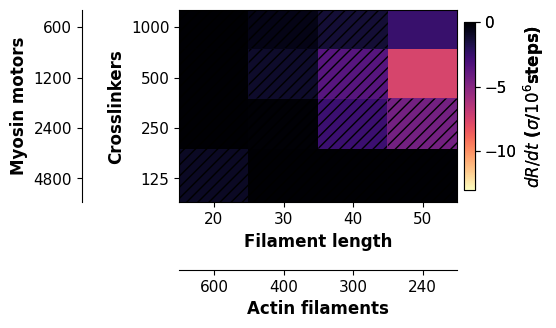

In [72]:
# Constriction rate
lFs = np.array([20,30,40,50])
nCs = np.array([125,250,500,1000])

g, ax2 = plt.subplots(1,1, sharex=True)
timestep_temp= 4000000
cmap = sns.color_palette('magma_r',as_cmap = True)
def rate_temp(lF_temp,nC_temp):
    key = build_key(lF_temp = lF_temp, nF_temp = int(12000/lF_temp), nC_temp = nC_temp, nM_temp = int(600000/nC_temp), pMDE_temp = '1',pCA_temp='0.1',pCD_temp = '0.00001',pMOC_temp = '0',sd = 212)
    try: 
        if ale_PercFrac(key,timestep_temp) > 0.8:
            return 1000000*ale_rate_constrict(key,timestep_temp)
        else: return np.nan
    except KeyError: return np.nan
def rate_temp_broken(lF_temp,nC_temp):
    key = build_key(lF_temp = lF_temp, nF_temp = int(12000/lF_temp), nC_temp = nC_temp, nM_temp = int(600000/nC_temp), pMDE_temp = '1',pCA_temp='0.1',pCD_temp = '0.00001',pMOC_temp = '0',sd = 212)
    try: 
        if not ale_PercFrac(key,timestep_temp) > 0.8:
            return 1000000*ale_rate_constrict(key,timestep_temp)
        else: return np.nan
    except KeyError: return np.nan

ale_colorplot(lFs,nCs,rate_temp,cmap,-13,0,g=g,ax=ax2,l=.92,b=.16,w=.03,h=.67,lab='$dR/dt$ ($\sigma$/$10^6$steps)', logay = True, ymax = 1270,ymin=90)
ale_colorplot(lFs,nCs,rate_temp_broken,cmap,-13,0,g=g,ax=ax2,l=.92,b=.16,w=.03,h=.67,lab='$dR/dt$ ($\sigma$/$10^6$steps)', logay = True, ymax = 1270,ymin=90, hatch='///')

def nC2nM(nC_temp): return 600000/nC_temp
def nM2nC(nM_temp): return 600000/nM_temp
secay2 = ax2.secondary_yaxis(-0.35, functions=(nC2nM,nM2nC))
secay2.set_ylabel('Myosin motors')
secay2.set_yticks([600,1200,2400,4800],[600,1200,2400,4800])
secay2.set_yticks([],minor = True)

def lF2nF(lF_temp): return 12000/lF_temp
def nF2lF(nF_temp): return 12000/nF_temp

secax2 = ax2.secondary_xaxis(-0.35, functions=(lF2nF,nF2lF))
secax2.set_xlabel('Actin filaments')
secax2.set_xticks([240,300,400,600])

ax2.set_ylabel('Crosslinkers')
ax2.set_xlabel('Filament length')
g.figure.set_figwidth(3.5)
g.figure.set_figheight(2.5)
plt.show()#rw_r0-250-200_Lz10.0_nF200-60_nM300_nC2000_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0.1-0.00001-0_212

/tmp/ipykernel_112965/742793464.py:16: RuntimeWarning: divide by zero encountered in divide
  def nM2nC(nM_temp): return 600000/nM_temp
/tmp/ipykernel_112965/742793464.py:23: RuntimeWarning: divide by zero encountered in divide
  def nF2lF(nF_temp): return 12000/nF_temp


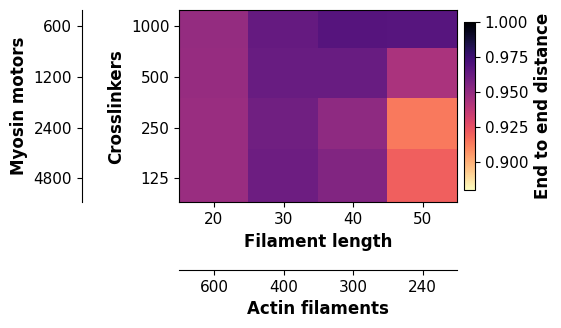

In [727]:
#End to end
lFs = np.array([20,30,40,50])
nCs = np.array([125,250,500,1000])

g, ax2 = plt.subplots(1,1, sharex=True)
timestep_temp= 4000000

cmap = sns.color_palette('magma_r',as_cmap = True)
def endtoend_temp(lF_temp,nC_temp):
    try: return ale_endtoend(build_key(lF_temp = lF_temp, nF_temp = int(12000/lF_temp), nC_temp = nC_temp, nM_temp = int(600000/nC_temp), pMDE_temp = '1',pCA_temp='0.1',pCD_temp = '0.00001',pMOC_temp = '0',sd = 212),timestep_temp)
    except KeyError: 
        return np.nan
ale_colorplot(lFs,nCs,endtoend_temp,cmap,.88,1,g=g,ax=ax2,l=.92,b=.16,w=.03,h=.67,lab='End to end distance', logay = True, ymax = 1250,ymin= 90)

def nC2nM(nC_temp): return 600000/nC_temp
def nM2nC(nM_temp): return 600000/nM_temp
secay2 = ax2.secondary_yaxis(-0.35, functions=(nC2nM,nM2nC))
secay2.set_ylabel('Myosin motors')
secay2.set_yticks([600,1200,2400,4800],[600,1200,2400,4800])
secay2.set_yticks([],minor = True)

def lF2nF(lF_temp): return 12000/lF_temp
def nF2lF(nF_temp): return 12000/nF_temp

secax2 = ax2.secondary_xaxis(-0.35, functions=(lF2nF,nF2lF))
secax2.set_xlabel('Actin filaments')
secax2.set_xticks([240,300,400,600])

ax2.set_ylabel('Crosslinkers')
ax2.set_xlabel('Filament length')
g.figure.set_figwidth(3.5)
g.figure.set_figheight(2.5)
plt.show()

/tmp/ipykernel_203315/3259536846.py:38: RuntimeWarning: divide by zero encountered in divide
  def nF2lF(nF_temp): return 12000/nF_temp


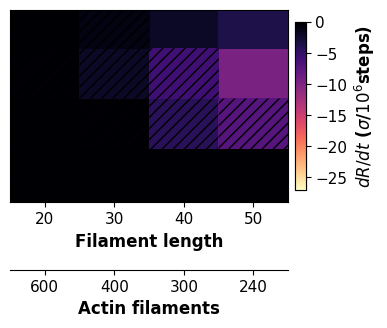

In [71]:
# Constriction rate
lFs = np.array([20,30,40,50])
nCs = np.array([125,250,500,1000])

g, ax2 = plt.subplots(1,1, sharex=True)
timestep_temp= 2000000

cmap = sns.color_palette('magma_r',as_cmap = True)
def rate_temp(lF_temp,nC_temp):
    key = build_key(lF_temp = lF_temp, nF_temp = int(12000/lF_temp), nC_temp = nC_temp, nM_temp = int(600000/nC_temp), pMDE_temp = '1',pCA_temp='0.1',pCD_temp = '0.00001',pMOC_temp = '0',sd = 212)
    try: 
        if ale_PercFrac(key,timestep_temp) > 0.8:
            return 1000000*ale_rate_constrict(key,timestep_temp)
        else: return np.nan
    except KeyError: return np.nan
def rate_temp_broken(lF_temp,nC_temp):
    key = build_key(lF_temp = lF_temp, nF_temp = int(12000/lF_temp), nC_temp = nC_temp, nM_temp = int(600000/nC_temp), pMDE_temp = '1',pCA_temp='0.1',pCD_temp = '0.00001',pMOC_temp = '0',sd = 212)
    try: 
        if not ale_PercFrac(key,timestep_temp) > 0.8:
            return 1000000*ale_rate_constrict(key,timestep_temp)
        else: return np.nan
    except KeyError: return np.nan

cax = ale_colorplot(lFs,nCs,rate_temp,cmap,-27,0,g=g,ax=ax2,l=.92,b=.16,w=.03,h=.67,lab='$dR/dt$ ($\sigma$/$10^6$steps)', logay = True, ymax = 1270,ymin=90)
cax1 = ale_colorplot(lFs,nCs,rate_temp_broken,cmap,-27,0,g=g,ax=ax2,l=.92,b=.16,w=.03,h=.67,lab='$dR/dt$ ($\sigma$/$10^6$steps)', logay = True, ymax = 1270,ymin=90, hatch='///')
cax.set_yticks([0,-5,-10,-15,-20,-25])
cax1.set_yticks([])
cax1.set_ylabel('')

"""def nC2nM(nC_temp): return 600000/nC_temp
def nM2nC(nM_temp): return 600000/nM_temp
secay2 = ax2.secondary_yaxis(-0.35, functions=(nC2nM,nM2nC))
secay2.set_ylabel('Myosin motors')
secay2.set_yticks([600,1200,2400,4800],[600,1200,2400,4800])
secay2.set_yticks([],minor = True)"""

def lF2nF(lF_temp): return 12000/lF_temp
def nF2lF(nF_temp): return 12000/nF_temp

secax2 = ax2.secondary_xaxis(-0.35, functions=(lF2nF,nF2lF))
secax2.set_xlabel('Actin filaments')
secax2.set_xticks([240,300,400,600])

ax2.set_yticks([])
ax2.set_ylabel('')
ax2.set_xlabel('Filament length')
g.figure.set_figwidth(3.5)
g.figure.set_figheight(2.5)
plt.show()#rw_r0-250-200_Lz10.0_nF200-60_nM300_nC2000_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0.1-0.00001-0_212

/tmp/ipykernel_203315/4074196946.py:39: RuntimeWarning: divide by zero encountered in divide
  def nF2lF(nF_temp): return 12000/nF_temp


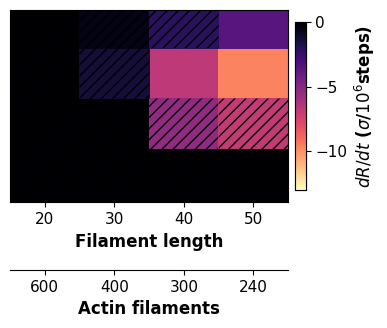

In [80]:
# Constriction rate for test 215: less flexible fil
# Constriction rate
lFs = np.array([20,30,40,50])
nCs = np.array([125,250,500,1000])

g, ax2 = plt.subplots(1,1, sharex=True)
timestep_temp= 2000000

cmap = sns.color_palette('magma_r',as_cmap = True)
def rate_temp(lF_temp,nC_temp):
    key = build_key(lF_temp = lF_temp, nF_temp = int(12000/lF_temp), nC_temp = nC_temp, nM_temp = int(600000/nC_temp), pMDE_temp = '1',pCA_temp='0.1',pCD_temp = '0.00001',pMOC_temp = '0',sd = 215)
    try: 
        if ale_PercFrac(key,timestep_temp) > 0.8:
            return 1000000*ale_rate_constrict(key,timestep_temp)
        else: return np.nan
    except KeyError: return np.nan
def rate_temp_broken(lF_temp,nC_temp):
    key = build_key(lF_temp = lF_temp, nF_temp = int(12000/lF_temp), nC_temp = nC_temp, nM_temp = int(600000/nC_temp), pMDE_temp = '1',pCA_temp='0.1',pCD_temp = '0.00001',pMOC_temp = '0',sd = 215)
    try: 
        if not ale_PercFrac(key,timestep_temp) > 0.8:
            return 1000000*ale_rate_constrict(key,timestep_temp)
        else: return np.nan
    except KeyError: return np.nan

cax = ale_colorplot(lFs,nCs,rate_temp,cmap,-13,0,g=g,ax=ax2,l=.92,b=.16,w=.03,h=.67,lab='$dR/dt$ ($\sigma$/$10^6$steps)', logay = True, ymax = 1270,ymin=90)
cax1 = ale_colorplot(lFs,nCs,rate_temp_broken,cmap,-13,0,g=g,ax=ax2,l=.92,b=.16,w=.03,h=.67,lab='$dR/dt$ ($\sigma$/$10^6$steps)', logay = True, ymax = 1270,ymin=90, hatch='///')
cax.set_yticks([0,-5,-10])
cax1.set_yticks([])
cax1.set_ylabel('')

"""def nC2nM(nC_temp): return 600000/nC_temp
def nM2nC(nM_temp): return 600000/nM_temp
secay2 = ax2.secondary_yaxis(-0.35, functions=(nC2nM,nM2nC))
secay2.set_ylabel('Myosin motors')
secay2.set_yticks([600,1200,2400,4800],[600,1200,2400,4800])
secay2.set_yticks([],minor = True)"""

def lF2nF(lF_temp): return 12000/lF_temp
def nF2lF(nF_temp): return 12000/nF_temp

secax2 = ax2.secondary_xaxis(-0.35, functions=(lF2nF,nF2lF))
secax2.set_xlabel('Actin filaments')
secax2.set_xticks([240,300,400,600])

ax2.set_yticks([])
ax2.set_ylabel('')
ax2.set_xlabel('Filament length')
g.figure.set_figwidth(3.5)
g.figure.set_figheight(2.5)
plt.show()

/tmp/ipykernel_203315/2122048956.py:17: RuntimeWarning: divide by zero encountered in divide
  def nM2nC(nM_temp): return 600000/nM_temp
/tmp/ipykernel_203315/2122048956.py:24: RuntimeWarning: divide by zero encountered in divide
  def nF2lF(nF_temp): return 12000/nF_temp


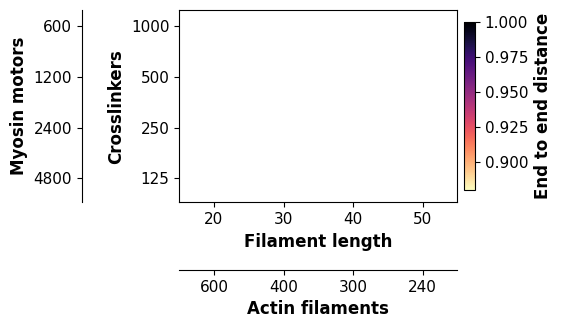

In [77]:
#End to end
lFs = np.array([20,30,40,50])
nCs = np.array([125,250,500,1000])

g, ax2 = plt.subplots(1,1, sharex=True)
timestep_temp= 4000000

cmap = sns.color_palette('magma_r',as_cmap = True)
def endtoend_temp(lF_temp,nC_temp):
    key = build_key(lF_temp = lF_temp, nF_temp = int(12000/lF_temp), nC_temp = nC_temp, nM_temp = int(600000/nC_temp), pMDE_temp = '1',pCA_temp='0.1',pCD_temp = '0.00001',pMOC_temp = '0',sd = 215)
    try: return ale_endtoend(key,timestep_temp)
    except KeyError: 
        return np.nan
ale_colorplot(lFs,nCs,endtoend_temp,cmap,.88,1,g=g,ax=ax2,l=.92,b=.16,w=.03,h=.67,lab='End to end distance', logay = True, ymax = 1250,ymin= 90)

def nC2nM(nC_temp): return 600000/nC_temp
def nM2nC(nM_temp): return 600000/nM_temp
secay2 = ax2.secondary_yaxis(-0.35, functions=(nC2nM,nM2nC))
secay2.set_ylabel('Myosin motors')
secay2.set_yticks([600,1200,2400,4800],[600,1200,2400,4800])
secay2.set_yticks([],minor = True)

def lF2nF(lF_temp): return 12000/lF_temp
def nF2lF(nF_temp): return 12000/nF_temp

secax2 = ax2.secondary_xaxis(-0.35, functions=(lF2nF,nF2lF))
secax2.set_xlabel('Actin filaments')
secax2.set_xticks([240,300,400,600])

ax2.set_ylabel('Crosslinkers')
ax2.set_xlabel('Filament length')
g.figure.set_figwidth(3.5)
g.figure.set_figheight(2.5)
plt.show()

# Ivan Plots rw

In [32]:
# Read dictionary

with open('/home/alessandro/ISTA/ivan_original/Test_B15__Alessandro/Test_B15__Alessandro/Analysis/dicR.pickle', 'rb') as file:
    dicR=pickle.load(file)
print(len(dicR))
dicR.keys()

452


dict_keys(['rw_r0-250-200_Lz10.0_nF100-20_nM1000_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_203', 'rw_r0-250-200_Lz10.0_nF100-30_nM1000_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_203', 'rw_r0-250-200_Lz10.0_nF100-40_nM1000_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_203', 'rw_r0-250-200_Lz10.0_nF100-50_nM1000_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_203', 'rw_r0-250-200_Lz10.0_nF150-20_nM1500_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_203', 'rw_r0-250-200_Lz10.0_nF150-30_nM1500_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_203', 'rw_r0-250-200_Lz10.0_nF150-40_nM1500_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_203', 'rw_r0-250-200_Lz10.0_nF150-50_nM1500_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_203', 'rw_r0-250-200_Lz10.0_nF200-20_nM2000_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_203', 'rw_r0-250-200_Lz10.0_nF200-30_nM2000_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_203', 'rw_r0-250-200_Lz10.0_nF200-40_nM2000_nC0_R10-0-0-0-0-0-0-0.1-1-0.000

### Heat plots pMW vs pMD vd pMDE

rw_r0-250-200_Lz10.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_203
rw_r0-250-200_Lz10.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.0001-0-0-0_203
rw_r0-250-200_Lz10.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.001-0-0-0_203
rw_r0-250-200_Lz10.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_204
rw_r0-250-200_Lz10.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00002-0-0-0_204
rw_r0-250-200_Lz10.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00004-0-0-0_204
rw_r0-250-200_Lz10.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00008-0-0-0_204
rw_r0-250-200_Lz10.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00016-0-0-0_204
rw_r0-250-200_Lz10.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00032-0-0-0_204
rw_r0-250-200_Lz10.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00064-0-0-0_204
rw_r0-250-200_Lz10.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00128-0-0-0_204


KeyError: 0.00128

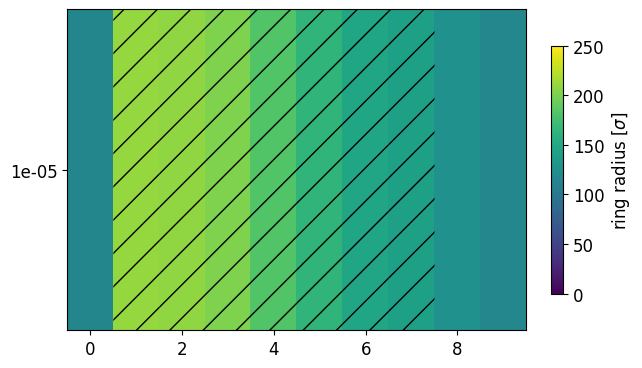

In [33]:
# Plots rw

TimestepThreshold = 4000000 # Only consider files going beyond this timestep
iavg = 1
pMWplot = 1
nCplot = 0
lFplot = 50
Rringplot = 200

if True: #for pMDplot in [0.001,0.0001,0.00001]:
    for nMplot in [2400,4800,9600]: #pMDEplot in [0,1,pMDplot]:
        for nFplot in [400]:
            for pMDEplot in [0.00001,0.0001,0.001]:

                data = []
                for filestring in dicR.keys():
                    par = getparams(filestring)
                    if par['nM']==nMplot and par['nC']==nCplot and par['nF']==nFplot and par['eAA']==0 \
                    and par['pMW']==pMWplot and par['lF']==lFplot and par['Rring']==Rringplot and par['geom']=='rw':   #par['pMD']==pMDplot and par['pMDE']==pMDEplot
                        print(filestring)
                        Df = dicR[filestring]
                        if Df.iloc[-1].time<TimestepThreshold:
                            continue
                        its = Df.index[Df['time']==TimestepThreshold].tolist()[0] + 1
                        Ravg = (Df['Ravg'].iloc[its-iavg:its]).mean()
                        RingIntactFlag = True if Df.RingIntactFlag.iloc[its-iavg:its].mean()>0.5 else False
                        RingIntactFlag = Df.PercolatedFraction.iloc[its-iavg:its].mean()
                        if par['pMDE']==par['pMD']:
                            pMDEmap = 0.5
                        else:
                            pMDEmap = par['pMDE']
                        #assert pMDEmap in [par['pMW'],0,0.5], "wrong pMDEmap"
                        BoundMyosin = Df['histAntiparallelMbond'].iloc[-1][1].sum() + Df['histParallelMbond'].iloc[-1][1].sum()  
                        data.append([par['pMD'],pMDEmap,Ravg,BoundMyosin,      RingIntactFlag])  #y,x,... ringintactflag
                        dicpMDElabel = {0:'0', 1:'1', par['pMW']:'pMW', 0.5:'pMD'}
                        pMDElabels = ['0','pMDE','1']
                data = np.array(data)
                if len(data)==0:
                    continue
                
                ylist, xlist, datadfplt = [],[],[]
                ylist = np.unique(data[:,0]).tolist()
                xlist = np.unique(data[:,1]).tolist()
                datadfplotdic = {}
                PlotLabelList = ['Rring', 'BoundMyosin']
                PlotStringDic = {'Rring':r'ring radius [$\sigma$]', 'BoundMyosin':'# bound myosin'}
                PlotVminmaxDic = {'Rring':[0,250], 'BoundMyosin':[0,nMplot]}
                PlotColormapDic = {'Rring':'viridis', 'BoundMyosin':'magma'}
                for l in PlotLabelList:
                    datadfplotdic[l] = np.NaN*np.ones((len(ylist), len(xlist)))
                datadfplotRingIntactFlag = np.NaN*np.ones((len(ylist), len(xlist)))
                for x in data:
                    i = ylist.index(x[0])
                    c = xlist.index(x[1])
                    for lindex, l in enumerate(PlotLabelList):
                        if not np.isnan(datadfplotdic[l][i,c]):
                            print("WARNING: two files for same box! x = {}, y = {}".format(x[0], x[1]))
                        datadfplotdic[l][i,c] = x[2+lindex]
                    datadfplotRingIntactFlag[i,c] = x[-1] 
                dfpltRingIntactFlag = pd.DataFrame(datadfplotRingIntactFlag, index=ylist, columns=xlist)
                #print(dfpltRingIntactFlag)
                dfpltRingIntactFlag = dfpltRingIntactFlag.sort_index(axis=1,ascending=False)
                dfpltRingIntactFlag = dfpltRingIntactFlag.sort_index(axis=0,ascending=False)
                #print(dfpltRingIntactFlag)

                        
                for l in PlotLabelList:
                    dfplt = pd.DataFrame(datadfplotdic[l], index=ylist, columns=xlist)
                    #print(dfplt)
                    #dfplt.columns = dfplt.columns.astype(int)
                    dfplt = dfplt.sort_index(axis=1,ascending=False)
                    dfplt = dfplt.sort_index(axis=0,ascending=False)
                    #dfplt = dfplt.sort_index(ascending=False)
                    #print(dfplt)

                    fig = plt.figure()
                    plt.imshow(dfplt, vmin=PlotVminmaxDic[l][0], vmax=PlotVminmaxDic[l][1], aspect=len(dfplt.columns)/len(dfplt.index)*0.7,cmap=PlotColormapDic[l])
                    ax = plt.gca()
                    colorbar = plt.colorbar(ax=ax,fraction=0.025,label=PlotStringDic[l],aspect=20)

                    # plot hashes for broken ring
                    assert (dfpltRingIntactFlag.columns==dfpltRingIntactFlag.columns).all()
                    assert (dfpltRingIntactFlag.index==dfpltRingIntactFlag.index).all()
                    y, x = np.mgrid[slice(0-0.5, len(dfpltRingIntactFlag.index) + 1-0.5, 1), slice(-0.5, len(dfpltRingIntactFlag.columns) + 1-0.5, 1)]
                    zm = np.ma.masked_greater(np.array(dfpltRingIntactFlag), 0.5)
                    plt.pcolor(x, y, zm, hatch='/', alpha=0.)  # hashed means PercolatedFlag<0.5, i.e. more than 1 cluster in sims
                
                    # Show all ticks and label them with the respective list entries
                    ax.set_yticks(np.arange(len(dfplt.index)), labels=[x for x in dfplt.index])
                    ax.set_xticks(np.arange(len(dfplt.columns)), labels=[dicpMDElabel[x] for x in dfplt.columns])
                    
                    # Rotate the tick labels and set their alignment.
                    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
                    # Loop over data dimensions and create text annotations.
                    #for i in range(len(nMlist)):
                    #    for j in range(len(nClist)):
                    #        text = ax.text(j, i, datadfplt[i, j],
                    #                       ha="center", va="center", color="w")
                    plt.ylabel('myosin detachment rate', size=15)
                    plt.xlabel('end detachment rate',size=15)
                    #colorbar.set_label(r'in-plane stress [kT/$\sigma^3$]',size=15)

                    texts = []
                    texts.append('nM = {:d}'.format(nMplot))
                    texts.append('nC = {:d}'.format(nCplot))
                    texts.append('eAA = {:.1f}'.format(eAAplot))
                    texts.append('nF = {:d}'.format(nFplot))
                    texts.append('pMW = {:g}'.format(pMWplot))
                    for it,text in enumerate(texts):
                        plt.annotate(text, xy=(0.95,0.95-it*0.07), xycoords='axes fraction', ha='right', va='top', size=12, c='w')
                    plt.tight_layout()

                    #plt.savefig('{:s}/Analysis/Graphs/StressHeatmap_Lx{:.0f}_pMD{:g}_pLD{:g}_pMOL{:g}_lF{:g}.pdf'.format(folder,Lxplot,pMDplot,pLDplot,pMOLplot,lFplot))
                    plt.savefig('{:s}/Analysis/Graphs/{:s}_rw_nM{:d}_nC{:d}_eAA{:.1f}_nF{:d}_pMW{:g}_ts{:d}.pdf'.format(folder,l,nMplot,nCplot,eAAplot,nFplot,pMWplot,TimestepThreshold),transparent=True)
                    plt.show()
                    plt.close()# Plot quantities from dicR

In [ ]:
# Plots rw, xlist = pW

TimestepThreshold = 5000000 # Only consider files going beyond this timestep
iavg = 1
pMDplot = 0.00001
nCplot = 0
lFplot = 50
Rringplot = 200

if True: #for pMDplot in [0.001,0.0001,0.00001]:
    for nMplot in [9600]: #pMDEplot in [0,1,pMDplot]:
        for nFplot in [400]:
            for eAAplot in [0]:

                data = []
                for filestring in dicR.keys():
                    par = getparams(filestring)
                    if par['nM']==nMplot and par['nC']==nCplot and par['nF']==nFplot and par['eAA']==eAAplot \
                    and par['pMD']==pMDplot and par['lF']==lFplot and par['Rring']==Rringplot and par['geom']=='rw':   #par['pMD']==pMDplot and par['pMDE']==pMDEplot
                        print(filestring)
                        Df = dicR[filestring]
                        if Df.iloc[-1].time<TimestepThreshold:
                            continue
                        its = Df.index[Df['time']==TimestepThreshold].tolist()[0] + 1
                        Ravg = (Df['Ravg'].iloc[its-iavg:its]).mean()
                        RingIntactFlag = True if Df.RingIntactFlag.iloc[its-iavg:its].mean()>0.5 else False
                        RingIntactFlag = Df.PercolatedFraction.iloc[its-iavg:its].mean()
                        if par['pMDE']==par['pMD']:
                            pMDEmap = 0.5
                        elif par['pMDE']==par['pMW']:
                            pMDEmap = 1
                        else:
                            pMDEmap = par['pMDE']
                        assert pMDEmap in [1,0,0.5], "wrong pMDEmap"
                        BoundMyosin = Df['histAntiparallelMbond'].iloc[-1][1].sum() + Df['histParallelMbond'].iloc[-1][1].sum()  
                        data.append([par['pMW'],pMDEmap,Ravg,BoundMyosin,      RingIntactFlag])  #y,x,... ringintactflag
                        dicpMDElabel = {0:'0', 1:'pMW', 0.5:'pMD'}
                data = np.array(data)
                if len(data)==0:
                    continue
                
                ylist, xlist, datadfplt = [],[],[]
                ylist = np.unique(data[:,0]).tolist()
                xlist = np.unique(data[:,1]).tolist()
                datadfplotdic = {}
                PlotLabelList = ['Rring', 'BoundMyosin']
                PlotStringDic = {'Rring':r'ring radius [$\sigma$]', 'BoundMyosin':'# bound myosin'}
                PlotVminmaxDic = {'Rring':[0,250], 'BoundMyosin':[0,nMplot]}
                PlotColormapDic = {'Rring':'viridis', 'BoundMyosin':'magma'}
                for l in PlotLabelList:
                    datadfplotdic[l] = np.NaN*np.ones((len(ylist), len(xlist)))
                datadfplotRingIntactFlag = np.NaN*np.ones((len(ylist), len(xlist)))
                for x in data:
                    i = ylist.index(x[0])
                    c = xlist.index(x[1])
                    for lindex, l in enumerate(PlotLabelList):
                        if not np.isnan(datadfplotdic[l][i,c]):
                            print("WARNING: two files for same box! x = {}, y = {}".format(x[0], x[1]))
                        datadfplotdic[l][i,c] = x[2+lindex]
                    datadfplotRingIntactFlag[i,c] = x[-1] 
                dfpltRingIntactFlag = pd.DataFrame(datadfplotRingIntactFlag, index=ylist, columns=xlist)
                print(dfpltRingIntactFlag)
                dfpltRingIntactFlag = dfpltRingIntactFlag.sort_index(axis=1,ascending=False)
                dfpltRingIntactFlag = dfpltRingIntactFlag.sort_index(axis=0,ascending=False)
                print(dfpltRingIntactFlag)

                        
                for l in PlotLabelList:
                    dfplt = pd.DataFrame(datadfplotdic[l], index=ylist, columns=xlist)
                    print(dfplt)
                    #dfplt.columns = dfplt.columns.astype(int)
                    dfplt = dfplt.sort_index(axis=1,ascending=False)
                    dfplt = dfplt.sort_index(axis=0,ascending=False)
                    #dfplt = dfplt.sort_index(ascending=False)
                    print(dfplt)

                    fig = plt.figure()
                    plt.imshow(dfplt, vmin=PlotVminmaxDic[l][0], vmax=PlotVminmaxDic[l][1], aspect=len(dfplt.columns)/len(dfplt.index)*0.7,cmap=PlotColormapDic[l])
                    ax = plt.gca()
                    colorbar = plt.colorbar(ax=ax,fraction=0.025,label=PlotStringDic[l],aspect=20)

                    # plot hashes for broken ring
                    assert (dfpltRingIntactFlag.columns==dfpltRingIntactFlag.columns).all()
                    assert (dfpltRingIntactFlag.index==dfpltRingIntactFlag.index).all()
                    y, x = np.mgrid[slice(0-0.5, len(dfpltRingIntactFlag.index) + 1-0.5, 1), slice(-0.5, len(dfpltRingIntactFlag.columns) + 1-0.5, 1)]
                    zm = np.ma.masked_greater(np.array(dfpltRingIntactFlag), 0.5)
                    plt.pcolor(x, y, zm, hatch='/', alpha=0.)  # hashed means PercolatedFlag<0.5, i.e. more than 1 cluster in sims
                
                    # Show all ticks and label them with the respective list entries
                    ax.set_yticks(np.arange(len(dfplt.index)), labels=[x for x in dfplt.index])
                    ax.set_xticks(np.arange(len(dfplt.columns)), labels=[dicpMDElabel[x] for x in dfplt.columns])
                    
                    # Rotate the tick labels and set their alignment.
                    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
                    # Loop over data dimensions and create text annotations.
                    #for i in range(len(nMlist)):
                    #    for j in range(len(nClist)):
                    #        text = ax.text(j, i, datadfplt[i, j],
                    #                       ha="center", va="center", color="w")
                    plt.ylabel('myosin walking rate', size=15)
                    plt.xlabel('end detachment rate',size=15)
                    #colorbar.set_label(r'in-plane stress [kT/$\sigma^3$]',size=15)

                    texts = []
                    texts.append('nM = {:d}'.format(nMplot))
                    texts.append('nC = {:d}'.format(nCplot))
                    texts.append('eAA = {:.1f}'.format(eAAplot))
                    texts.append('nF = {:d}'.format(nFplot))
                    texts.append('pMD = {:g}'.format(pMDplot))
                    for it,text in enumerate(texts):
                        plt.annotate(text, xy=(0.95,0.95-it*0.07), xycoords='axes fraction', ha='right', va='top', size=12, c='w')
                    plt.tight_layout()

                    #plt.savefig('{:s}/Analysis/Graphs/StressHeatmap_Lx{:.0f}_pMD{:g}_pLD{:g}_pMOL{:g}_lF{:g}.pdf'.format(folder,Lxplot,pMDplot,pLDplot,pMOLplot,lFplot))
                    plt.savefig('{:s}/Analysis/Graphs/{:s}_rw_nM{:d}_nC{:d}_eAA{:.1f}_nF{:d}_pMD{:g}_ts{:d}.pdf'.format(folder,l,nMplot,nCplot,eAAplot,nFplot,pMDplot,TimestepThreshold),transparent=True)
                    plt.show()
                    plt.close()# Plot quantities from dicR

### Correlation nM vs rAvg

In [ ]:
TimestepThreshold=10000000
iavg=1
Rringplot=200
lFplot=50
nCplot=0
nFplot=400
for filestring in dicR.keys():
    par = getparams(filestring)
    if par['nC']==nCplot and par['nF']==nFplot and par['lF']==lFplot and par['Rring']==Rringplot and par['geom']=='rw':   #par['pMD']==pMDplot and par['pMDE']==pMDEplot
        print(filestring)
        Df = dicR[filestring]
        if Df.iloc[-1].time<TimestepThreshold:
            continue
        its = Df.index[Df['time']==TimestepThreshold].tolist()[0] + 1
        Ravg = (Df['Ravg'].iloc[its-iavg:its]).mean()
        RingIntactFlag = True if Df.RingIntactFlag.iloc[its-iavg:its].mean()>0.5 else False
        RingIntactFlag = Df.PercolatedFraction.iloc[its-iavg:its].mean()
        BoundMyosin = Df['histAntiparallelMbond'].iloc[-1][1].sum() + Df['histParallelMbond'].iloc[-1][1].sum()  
        if par['pMDE']==par['pMD']:
            color='b'
        elif par['pMDE']<par['pMD']:
            color='k'
        else:
            color='r'
        if par['pMD']>0.0001*par['pMW']:
            marker='v'
        else:
            marker='o'
        plt.plot(BoundMyosin,Ravg,marker,c=color)  #y,x,... ringintactflag

In [34]:
def update_annot(ind):
    x,y = line.get_data()
    annot.xy = (x[ind["ind"][0]], y[ind["ind"][0]])
    text = "{}, {}".format(" ".join(list(map(str,ind["ind"]))), 
                           " ".join([names[n] for n in ind["ind"]]))
    annot.set_text(text)
    annot.get_bbox_patch().set_alpha(0.4)


def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = line.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()


rw_r0-250-200_Lz10.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-0.01-0.00001-0.00001-0-0-0_203
rw_r0-250-200_Lz10.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-0.01-0.00001-0.0001-0-0-0_203
rw_r0-250-200_Lz10.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-0.01-0.00001-0.001-0-0-0_203
rw_r0-250-200_Lz10.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-0.1-0.00001-0.00001-0-0-0_203
rw_r0-250-200_Lz10.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-0.1-0.00001-0.0001-0-0-0_203
rw_r0-250-200_Lz10.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-0.1-0.00001-0.001-0-0-0_203
rw_r0-250-200_Lz10.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_203
rw_r0-250-200_Lz10.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.0001-0-0-0_203
rw_r0-250-200_Lz10.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.001-0-0-0_203
rw_r0-250-200_Lz10.0_nF400-50_nM4800_nC0_R10-0-0-0-0-0-0-0.1-0.01-0.00001-0.00001-0-0-0_203
rw_r0-250-200_Lz10.0_nF400-50_nM4800_nC0_R10-0-0-0-0-0-0-0.1-0.01-0.00001-0.0001-0-0-0_203
rw_r0-250-

'\nfor ifig in [1,2]:\n    fig = plt.figure(ifig)\n    fig.canvas.mpl_connect("motion_notify_event", hover)\n    plt.show()\n    '

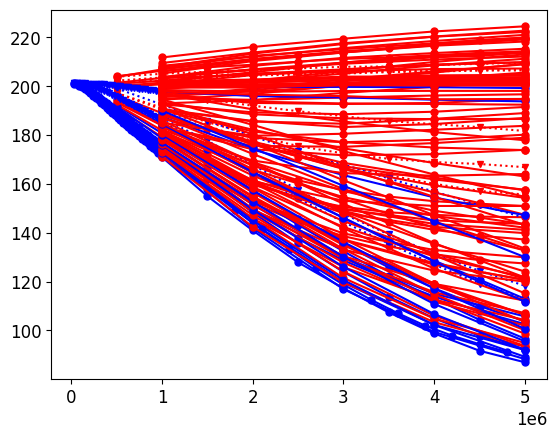

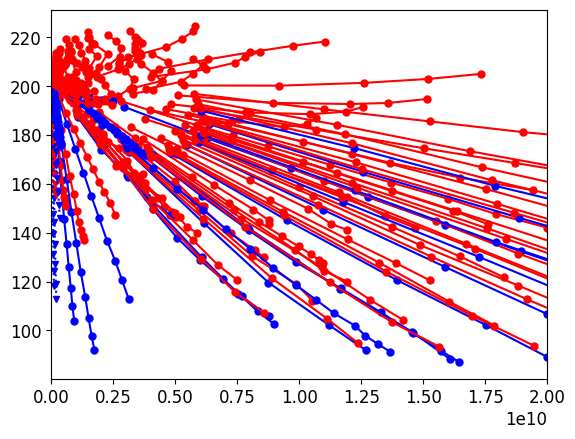

In [35]:
# rescaled time vs rAvg
Rringplot=200
lFplot=50
nCplot=0
nFplot=400
for filestring in dicR.keys():
    par = getparams(filestring)
    if par['nC']==nCplot and par['nF']==nFplot and par['lF']==lFplot and par['Rring']==Rringplot and par['geom']=='rw':   #par['pMD']==pMDplot and par['pMDE']==pMDEplot
        print(filestring)
        Df = dicR[filestring]
        time = Df.time
        Ravg = Df['Ravg']
        BoundMyosin = []
        for i,Dfline in Df.iterrows():
            BoundMyosin.append( Dfline['histAntiparallelMbond'][1].sum() + Dfline['histParallelMbond'][1].sum()  )
        
        if par['pMDE']==par['pMD']:
            color='b'
        elif par['pMDE']<par['pMD']:
            color='k'
        else:
            color='r'
        if par['pMD']>=0.001*par['pMW']:
            marker='v:'
        else:
            marker='o-'
        plt.figure(1)
        plt.plot(time*BoundMyosin*par['pMW'],Ravg,marker,c=color,ms=5)  #y,x,... ringintactflag
        plt.figure(2)
        plt.plot(time,Ravg,marker,c=color,ms=5)  #y,x,... ringintactflag

plt.figure(1)
plt.xlim([0,2e10])
'''
for ifig in [1,2]:
    fig = plt.figure(ifig)
    fig.canvas.mpl_connect("motion_notify_event", hover)
    plt.show()
    '''

### Plots per sim

In [ ]:
keys = [k for k in dicR.keys()]
keys.sort(key=sortbyparams)

timeHistList = [2e6, 5e6, 10e6]
RringPlot = [200.0]
lFPlot= [50]
LzPlot= [10.0]
nMplot=[1200,2400,9600]
eAAplot=[1.0]
pWplot=[1]
pMDplot = [0.00001]
if len(RringPlot)==1 and len(lFPlot)==1 and len(LzPlot)==1:
    SaveFigFlag=True
else:
    SaveFigFlag=False
SaveFigFlagIndividual=True

counter=0

for i,key in enumerate(keys):    
    dffull = dicR[key]
    par = getparams(key)
    Lz=par['Lz']
    Rcylout=par['Rcylout']
    lF=par['lF']
    nF=par['nF']
    nM=par['nM']
    eAA = par['eAA']
    
    if par['pMDE']==0:
        fmt = '--'
    elif par['pMDE']<=par['pMD']:
        fmt = '-'
    else:
        fmt = ':'
    label="nF{:d}-{:d} nM{:d} pMD{:g} pMDE{:g} pMW{:g}".format(par['nF'],par['lF'],par['nM'],par['pMD'],par['pMDE'],par['pMW'])
    
    if not ((par['Rring'] in RringPlot) and (Lz in LzPlot) and (lF in lFPlot) and (nM in nMplot) and (eAA in eAAplot) and (par['pMW'] in pWplot) and\
            (par['geom']=='rw') and (par['nF']==400) and (par['pMD'] in pMDplot) and (par['pMDE'] in [par['pMD'],1])  ):
        continue
    print(key)
    counter+=1
        
    plt.figure(1)
    df = dffull[dffull.RingIntactFlag==1]
    plt.plot(df.time, df.Ravg,fmt, color=nM2color(nM), label=label)
    plt.fill_between(df.time, df.Ravg-df.Rstd, df.Ravg+df.Rstd, color=nM2color(nM), alpha=0.1)
    #dfbroken = dffull[dffull.RingIntactFlag==0]
    #if len(dfbroken)>0:
    #    plt.plot(dfbroken.iloc[0].time, dfbroken.iloc[0].Ravg, 'x', color=nM2color(nM), label=None, ms=10)

    plt.figure(2)
    plt.plot(df.time, df.Rstd, fmt, color=nM2color(nM), label=label)

    plt.figure(3)
    FractionMB = np.array([x[1].sum() for x in df.histMBdensity.values])/(2*nM)
    plt.plot(df.time, FractionMB, fmt, color=nM2color(nM), label=label )
    
    plt.figure(4)
    FractionMB = np.array([x[1].sum() for x in df.histMBdensity.values])/(nF)
    plt.plot(df.time, FractionMB, fmt, color=nM2color(nM), label=label )
    
    plt.figure(5)
    plt.plot(df.time, df.ActinStrainAvg, fmt, color=nM2color(nM), label=label )
    
    plt.figure(6)
    plt.plot(df.time, df.vdotnActinAvg, fmt, color=nM2color(nM), label=label )
    
    plt.figure(7)
    plt.plot(df.time, df.MSpeedAntiparallelAvg, '--', color=nM2color(nM), label=label )
    plt.plot(df.time, df.MSpeedParallelAvg, '-', color=nM2color(nM), label=label )
    
    
    # AP, AB and M distribution around ring
    fig100,axs=plt.subplots(1,len(timeHistList),sharey=True, figsize=(3*len(timeHistList),3))
    plt.annotate(key, (0.5,1.1), fontsize=10, va='center', ha='center', xycoords='figure fraction')
    for i,timeHist in enumerate(timeHistList):
        plt.sca(axs[i])
        if len(df[df.time==timeHist])==0:
            continue
        plt.ylabel('Density')
        plt.xlabel(r'$\theta\ [rad]$')
        plt.title('ts{:.0f}'.format(timeHist), fontsize=10)

        histAdensity = df[df.time==timeHist].histAdensity.iloc[0]
        Ravg = df[df.time==timeHist].Ravg.iloc[0]
        #plt.stairs(histAdensity[1]/lF, edges=histAdensity[0], lw=2, label='actin / lF', color='forestgreen')
        plt.plot(bin2midpoint(histAdensity[0]), histAdensity[1]/(lF*nF), ':', color='forestgreen', label='actin / lF', lw=1)

        histABdensity = df[df.time==timeHist].histABdensity.iloc[0]
        #plt.stairs(histABdensity[1], edges=histABdensity[0], lw=2, label='actin barbed', color='limegreen')
        plt.plot(bin2midpoint(histABdensity[0]), histABdensity[1]/nF, color='limegreen', label='actin barbed', lw=2)

        histAPdensity = df[df.time==timeHist].histAPdensity.iloc[0]
        #plt.stairs(histAPdensity[1], edges=histAPdensity[0], lw=2, label='actin pointed', color='darkgreen')
        plt.plot(bin2midpoint(histAPdensity[0]), histAPdensity[1]/nF, color='darkgreen', label='actin pointed', lw=2)

        histMUdensity = df[df.time==timeHist].histMUdensity.iloc[0]
        #plt.stairs(histMUdensity[1], edges=histMUdensity[0], lw=2, label='myosin unbound', color='navy')
        plt.plot(bin2midpoint(histMUdensity[0]), histMUdensity[1]/nM, color='navy', label='myosin unbound', lw=1)

        histMBdensity = df[df.time==timeHist].histMBdensity.iloc[0]
        #plt.stairs(histMBdensity[1], edges=histMBdensity[0], lw=2, label='myosin bound', color='royalblue')
        plt.plot(bin2midpoint(histMBdensity[0]), histMBdensity[1]/nM, color='royalblue', label='myosin bound', lw=2)
        
        if i==0:
            plt.legend(fontsize=8)

            
    # Myosin distribution along filament        
    fig120,axs=plt.subplots(1,len(timeHistList),sharey=True, figsize=(3*len(timeHistList),3))
    plt.annotate(key, (0.5,1.1), fontsize=10, va='center', ha='center', xycoords='figure fraction')
    for i,timeHist in enumerate(timeHistList):
        plt.sca(axs[i])
        if len(df[df.time==timeHist])==0:
            continue
        plt.ylabel('Frequence')
        plt.xlabel(r'Distance from pointed end')
        plt.title('ts{:.0f}'.format(timeHist), fontsize=10)

        histMDistrAlongActin = df[df.time==timeHist].histMDistrAlongActin.iloc[0]
        plt.plot(bin2midpoint(histMDistrAlongActin[0]), histMDistrAlongActin[1], color='cornflowerblue', label='bound myo', lw=1)
        histDoubleBoundMDistrAlongActin = df[df.time==timeHist].histDoubleBoundMDistrAlongActin.iloc[0]
        plt.plot(bin2midpoint(histDoubleBoundMDistrAlongActin[0]), histDoubleBoundMDistrAlongActin[1], color='navy', label='double bound myo', lw=1)
        if i==0:
            plt.legend(fontsize=8)
            
    # vdotn        
    fig121,axs=plt.subplots(1,len(timeHistList),sharey=True, figsize=(3*len(timeHistList),3))
    plt.annotate(key, (0.5,1.1), fontsize=10, va='center', ha='center', xycoords='figure fraction')
    for i,timeHist in enumerate(timeHistList):
        plt.sca(axs[i])
        if len(df[df.time==timeHist])==0:
            continue
        plt.ylabel('Frequence')
        plt.xlabel(r'$\mathbf{v}\cdot \mathbf{\hat{n}}$')
        plt.title('ts{:.0f}'.format(timeHist), fontsize=10)

        histvdotnActinDistr = df[df.time==timeHist].histvdotnActinDistr.iloc[0]
        plt.plot(bin2midpoint(histvdotnActinDistr[0]), histvdotnActinDistr[1], color='k', label='', lw=1)

    # Actin strain        
    fig122,axs=plt.subplots(1,len(timeHistList),sharey=True, figsize=(3*len(timeHistList),3))
    plt.annotate(key, (0.5,1.1), fontsize=10, va='center', ha='center', xycoords='figure fraction')
    for i,timeHist in enumerate(timeHistList):
        plt.sca(axs[i])
        if len(df[df.time==timeHist])==0:
            continue
        plt.ylabel('Frequence')
        plt.xlabel(r'AA bond length')
        plt.title('ts{:.0f}'.format(timeHist), fontsize=10)

        histActinStrainDistr = df[df.time==timeHist].histActinStrainDistr.iloc[0]
        plt.plot(bin2midpoint(histActinStrainDistr[0]), histActinStrainDistr[1], color='forestgreen', label='', lw=1)

            
    fig101,axs=plt.subplots(1,3,sharey=True, figsize=(3*3,2))
    for j, s in enumerate(['histABdensity', 'histAPdensity', 'histMBdensity']):
        if s not in df:
            continue
        plt.sca(axs[j])
        data = []
        for i,dfline in df.iterrows():
            Ravg = dfline.Ravg
            time = dfline.time
            midpoints = bin2midpoint( dfline[s][0]*Ravg )
            hist = dfline[s][1]
            for i in range(len(hist)):
                data.append( [midpoints[i], time, hist[i]] )
        if len(data)==0:
            continue
        data = np.array(data)
        plt.scatter(data[:,0], data[:,1], c=data[:,2], s=40, marker='s')
        plt.colorbar()
        plt.xlabel('arc coordinate')
        if j==0:
            plt.ylabel('time')
        plt.title(s, fontsize=10)
    plt.tight_layout()
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/HistAB-AP-MB_{:s}.pdf'.format(folder,key))
    #plt.show()
    #plt.close(fig101)
    
    fig102,axs=plt.subplots(1,3,sharey=True, figsize=(3*3,2))
    for j, s in enumerate(['histParallelContacts','histAntiparallelExtensileContacts', 'histAntiparallelContractileContacts']):
        plt.sca(axs[j])
        data = []
        for i,dfline in df.iterrows():
            if len(dfline[s])==0:
                continue
            time = dfline.time
            midpoints = bin2midpoint( dfline[s][0] )
            hist = dfline[s][1]
            for i in range(2,len(hist)):
                data.append( [midpoints[i], time, hist[i] ] )
        data = np.array(data)
        plt.scatter(data[:,0], data[:,1], c=data[:,2], s=30, marker='s')
        plt.colorbar()
        plt.xlabel('contact length')
        if j==0:
            plt.ylabel('time')
        plt.title(s[4:], fontsize=10)
    plt.tight_layout()
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/HistContact_{:s}.pdf'.format(folder,key))
    #plt.show()
    #plt.close(fig102)

    fig103,axs=plt.subplots(1,1,sharey=True, figsize=(4,3))
    for j, s in enumerate(['histParallelContacts','histAntiparallelExtensileContacts', 'histAntiparallelContractileContacts']):
        data = []
        for i, dfline in df.iterrows():
            if len(dfline[s])==0:
                continue
            time = dfline.time
            hist = dfline[s][1]
            histsum = sum(hist*dfline[s][0][:-1])
            data.append([time,histsum])
        data = np.array(data)
        plt.plot(data[:,0], data[:,1], label=s[4:])
    plt.ylabel('# contacts')
    plt.xlabel('time')
    plt.title('Total number of contacts', fontsize=10)
    plt.legend(frameon=False, fontsize=8)
    plt.ylim(0,None)
    plt.tight_layout()
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/ContactsvsTime_{:s}.pdf'.format(folder,key))
    #plt.show()
    #plt.close(fig103)

    fig104,axs=plt.subplots(1,2,sharey=True, figsize=(6,2))
    for j, s in enumerate(['histParallelMbond','histAntiparallelMbond']):
        plt.sca(axs[j])
        data = []
        for i,dfline in df.iterrows():
            if len(dfline[s])==0:
                continue
            time = dfline.time
            midpoints = bin2midpoint( dfline[s][0] )
            hist = dfline[s][1]
            for i in range(1,len(hist)):
                data.append( [midpoints[i], time, hist[i] ] )
        data = np.array(data)
        plt.scatter(data[:,0], data[:,1], c=data[:,2], s=30, marker='s')
        plt.colorbar()
        plt.xlabel('Extensivity')
        if j==0:
            plt.ylabel('time')
        plt.title(s[4:], fontsize=10)
    plt.tight_layout()
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/HistMbonds_{:s}.pdf'.format(folder,key))
    #plt.show()
    #plt.close(fig104)

    # MBonds
    fig105,axs=plt.subplots(1,1,sharey=True, figsize=(4,3))
    times, histsumParallel, histsumContractile, histsumExtensile = [],[],[],[]
    for i, dfline in df.iterrows():
        times.append(dfline.time)
        assert (dfline['histParallelMbond'][0]==dfline['histAntiparallelMbond'][0]).all()
        s = 'histParallelMbond'
        midpoints = bin2midpoint( dfline[s][0] )
        counts = dfline[s][1]
        histsumParallel.append(sum(counts))
        s = 'histAntiparallelMbond'
        midpoints = bin2midpoint( dfline[s][0] )
        counts = dfline[s][1]
        assert len(counts[0:lF])==len(counts[lF+1:])
        histsumContractile.append(sum(counts[0:lF]))
        histsumExtensile.append(sum(counts[lF+1:]))
    plt.plot(times, histsumParallel, label='Parallel')
    plt.plot(times, histsumContractile, label='Antiparallel contractile')
    plt.plot(times, histsumExtensile, label='Antiparallel extensile')
    #plt.ylabel('# double-bound Myo')
    plt.xlabel('time')
    plt.title('Filament pairs bound by myosin', fontsize=10)
    plt.legend(frameon=False, fontsize=8)
    plt.ylim(0,None)
    plt.tight_layout()
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/MbondsvsTime_{:s}.pdf'.format(folder,key))
    #plt.show()
    #plt.close(fig105)
    

if counter>=1:

    assert len(lFPlot)==1
    assert len(RringPlot)==1
    assert len(LzPlot)==1
    assert len(pMWplot)==1
    assert len(pMDplot)==1
    assert len(pMDEplot)==1
    
    stringname = 'Rring{:.0f}_Lz{:.0f}_nF{:d}_pMW{:g}_pMD{:g}_pMDE{:g}'.format(RringPlot[0],LzPlot[0],lFPlot[0],pMWplot[0], pMDplot[0],pMDEplot[0])
    
    plt.figure(1)
    #for timeHist in timeHistList:
    #    plt.plot([timeHist,timeHist],[max(RcyloutPlot)-50, max(RcyloutPlot)],':',lw=0.2,color='k')
    plt.ylabel('Average ring radius')
    plt.xlabel('time')
    plt.ylim((20,215))
    plt.xlim((1e6,10e6))
    plt.legend(fontsize=10,frameon=False,title='# myosin',title_fontsize=10,alignment='left')
    plt.tight_layout()
    if SaveFigFlag: plt.savefig('{:s}/Analysis/Graphs/RingRadius_{:s}.pdf'.format(folder,stringname), metadata = {'Subject':UsedKeysString})

    plt.figure(2)
    plt.ylabel('Std of ring radius')
    plt.xlabel('time')
    plt.legend(fontsize=10,frameon=False,title='# myosin',title_fontsize=10,alignment='left')
    plt.tight_layout()
    if SaveFigFlag: plt.savefig('{:s}/Analysis/Graphs/RingRadiusStd_{:s}.pdf'.format(folder,stringname), metadata = {'Subject':UsedKeysString})

    plt.figure(3)
    plt.ylabel('Fraction of myosin heads bound')
    plt.xlabel('time')
    plt.legend(fontsize=10,frameon=False,title='# myosin',title_fontsize=10,alignment='left')
    plt.tight_layout()
    if SaveFigFlag: plt.savefig('{:s}/Analysis/Graphs/MyosinBoundFraction_{:s}.pdf'.format(folder,stringname), metadata = {'Subject':UsedKeysString})

    plt.figure(4)
    plt.ylabel('Bound myosin per filament') #'Myosin-actin bonds per actin filament')
    plt.xlabel('time')
    plt.legend(fontsize=10,frameon=False,title='# myosin',title_fontsize=10,alignment='left')
    plt.tight_layout()
    if SaveFigFlag: plt.savefig('{:s}/Analysis/Graphs/MyosinBoundFraction_{:s}.pdf'.format(folder,stringname), metadata = {'Subject':UsedKeysString})

    plt.figure(5)
    plt.ylabel('Length of actin-actin bonds') #'Myosin-actin bonds per actin filament')
    plt.xlabel('time')
    plt.legend(fontsize=10,frameon=False,alignment='left')
    plt.tight_layout()
    if SaveFigFlag: plt.savefig('{:s}/Analysis/Graphs/ActinStrainAvg_{:s}.pdf'.format(folder,stringname), metadata = {'Subject':UsedKeysString})

    plt.figure(6)
    plt.ylabel(r'$\mathrm{v}\cdot\mathrm{\hat{n}}$') #'Myosin-actin bonds per actin filament')
    plt.xlabel('time')
    plt.legend(fontsize=10,frameon=False,alignment='left')
    plt.tight_layout()
    if SaveFigFlag: plt.savefig('{:s}/Analysis/Graphs/vdotnActinAvg_{:s}.pdf'.format(folder,stringname), metadata = {'Subject':UsedKeysString})

    plt.figure(7)
    plt.ylabel(r'myosin speed') #'Myosin-actin bonds per actin filament')
    plt.xlabel('time')
    plt.legend(fontsize=10,frameon=False,alignment='left')
    plt.tight_layout()
    if SaveFigFlag: plt.savefig('{:s}/Analysis/Graphs/MyoSpeed_{:s}.pdf'.format(folder,stringname), metadata = {'Subject':UsedKeysString})


In [ ]:
    '''
    fig105,axs=plt.subplots(1,1,figsize=(4,3))
    plt.annotate(key, (0.5,1.1), fontsize=10, va='center', ha='center', xycoords='figure fraction')
    colors = ['k','b','g','orange','y','r']
    timesPlot = [1000000, 1100000, 1200000, 1300000, 1400000, 1500000]
    for i,timeHist in enumerate(timesPlot):
        dfline = df[df.time==timeHist].iloc[0]
        if len(dfline.DeltaExtensivityRef)==0:
            continue
        plt.ylabel('Delta Extensivity')
        plt.xlabel('Initial Extensivity')
        label = 'ts{:d}'.format(timeHist)
        InitialExtensivity = dfline.DeltaExtensivityRef.InitialExtensivity
        DeltaSum = dfline.DeltaExtensivityRef.DeltaSum
        #DeltaStd = dfline.DeltaExtensivityRef.DeltaStd
        plt.plot(InitialExtensivity, DeltaSum, '-', color=colors[i], label=label, lw=1)
        #plt.fill_between(InitialExtensivity, DeltaMean-DeltaStd, DeltaMean+DeltaStd, color=colors[i], alpha=0.2)
    plt.legend(fontsize=8)
    plt.title('# steps forward in 1e5 ts, before first detachment', fontsize=10)
    plt.ylim(0,None)
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/DeltaExtensivityRef_{:d}ts_{:s}.pdf'.format(folder,len(timesPlot),key))
    
    fig106,axs=plt.subplots(1,1, figsize=(4,2))
    data = []
    for i, dfline in df.iterrows():
        if len(dfline.DeltaExtensivityRef)==0:
            continue
        time = dfline.time
        InitialExtensivity = dfline.DeltaExtensivityRef.InitialExtensivity
        DeltaSum = dfline.DeltaExtensivityRef.DeltaSum
        for i in range(1,len(hist)):
            data.append( [InitialExtensivity[i], time, DeltaSum[i] ] )
    data = np.array(data)
    plt.scatter(data[:,0], data[:,1], c=data[:,2], s=10, marker='s')
    plt.colorbar()
    plt.xlabel('Initial Extensivity')
    if j==0:
        plt.ylabel('time')
    plt.title('# steps forward in 1e5 ts, before first detachment', fontsize=10)
    plt.tight_layout()
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/HistDeltaExtensivityRef_{:s}.pdf'.format(folder,key))
    

    fig107,axs=plt.subplots(1,1,figsize=(4,3))
    plt.annotate(key, (0.5,1.1), fontsize=10, va='center', ha='center', xycoords='figure fraction')
    colors = ['k','b','g','y','r']
    timesPlot = [1000000, 2000000, 3000000, 4000000]
    for i,timeHist in enumerate(timesPlot):
        dfline = df[df.time==timeHist].iloc[0]
        if len(dfline.DeltaExtensivityCont)==0:
            continue
        plt.ylabel('Delta Extensivity')
        plt.xlabel('Previous Extensivity')
        label = 'ts{:d}'.format(timeHist)
        InitialExtensivity = dfline.DeltaExtensivityCont.PreviousExtensivity
        DeltaSum = dfline.DeltaExtensivityCont.DeltaSum
        #DeltaStd = dfline.DeltaExtensivityCont.DeltaStd
        plt.plot(InitialExtensivity, DeltaSum, '-', color=colors[i], label=label, lw=1)
        #plt.fill_between(InitialExtensivity, DeltaMean-DeltaStd, DeltaMean+DeltaStd, color=colors[i], alpha=0.2)
        plt.title('# steps forward in 1e5 ts, for all Myos', fontsize=10)
        plt.legend(fontsize=8)
        plt.ylim(0,None)
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/DeltaExtensivityCont_{:s}.pdf'.format(folder,key))
    
    fig108,axs=plt.subplots(1,1, figsize=(4,3))
    data = []
    for i, dfline in df.iterrows():
        if len(dfline.DeltaExtensivityCont)==0:
            continue
        time = dfline.time
        InitialExtensivity = dfline.DeltaExtensivityCont.PreviousExtensivity
        DeltaSum = dfline.DeltaExtensivityCont.DeltaSum
        for i in range(1,len(hist)):
            data.append( [InitialExtensivity[i], time, DeltaSum[i] ] )
    data = np.array(data)
    plt.scatter(data[:,0], data[:,1], c=data[:,2], s=5, marker='s')
    plt.colorbar()
    plt.xlabel('Previous Extensivity')
    if j==0:
        plt.ylabel('time')
    plt.title('# steps forward in 1e5 ts, for all Myos', fontsize=10)
    plt.tight_layout()
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/HistDeltaExtensivityCont_{:s}.pdf'.format(folder,key))
    '''


### Paper

In [91]:
nM2colorDic = {}
colors=['#184093','cornflowerblue','mediumturquoise','#e36d7d','#b077b8','#d19fd6','#9fd6af'] #'powderblue','darkcyan',
nMList = [19200, 9600, 4800, 2400, 1200, 600] 
for i,nM in enumerate(nMList):
    nM2colorDic[nM] = colors[i]
    
string2titleDic = {'histABdensity':'Barbed end density', 'histAPdensity':'Pointed end density', 'histMBdensity':'Bound myosin density'}

rw_r0-250-200_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0-0-0_201
rw_r0-250-200_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0-0-0_201
rw_r0-250-200_Lz10.0_eAA1.0_nF400-50_nM9600_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0-0-0_201


/var/folders/r9/smk0v8f53xz3gxjck33br70w0000gn/T/ipykernel_70998/1452006861.py:343: UserWarning: Unknown infodict keyword: 'Comment'. Must be one of {'Creator', 'ModDate', 'Author', 'Subject', 'Title', 'CreationDate', 'Trapped', 'Keywords', 'Producer'}.
  if SaveFigFlag: plt.savefig('{:s}/Analysis/Graphs/Paper/RingRadius_{:s}.pdf'.format(folder,stringname), metadata = {'Comment':UsedKeysString})
/var/folders/r9/smk0v8f53xz3gxjck33br70w0000gn/T/ipykernel_70998/1452006861.py:350: UserWarning: Unknown infodict keyword: 'Comment'. Must be one of {'Creator', 'ModDate', 'Author', 'Subject', 'Title', 'CreationDate', 'Trapped', 'Keywords', 'Producer'}.
  if SaveFigFlag: plt.savefig('{:s}/Analysis/Graphs/Paper/RingRadiusStd_{:s}.pdf'.format(folder,stringname), metadata = {'Comment':UsedKeysString})
/var/folders/r9/smk0v8f53xz3gxjck33br70w0000gn/T/ipykernel_70998/1452006861.py:357: UserWarning: Unknown infodict keyword: 'Comment'. Must be one of {'Creator', 'ModDate', 'Author', 'Subject', 'Title

"\nplt.ylabel('Actin')\n#plt.xlabel('Arc of ring')\nplt.xlabel(r'$\theta\\ [rad]$')\nplt.legend(fontsize=8)\n\nplt.figure(11)\nplt.ylabel('Actin barbed end')\nplt.xlabel(r'$\theta\\ [rad]$')\nplt.legend(fontsize=8)\n\nplt.figure(12)\nplt.ylabel('Actin pointed end')\nplt.xlabel(r'$\theta\\ [rad]$')\nplt.legend(fontsize=8)\n\nplt.figure(20)\nplt.ylabel('Unbound myosin')\n#plt.xlabel('Arc of ring')\nplt.xlabel(r'$\theta\\ [rad]$')\nplt.legend(fontsize=8)\n             \nplt.figure(21)\nplt.ylabel('Bound myosin')\n#plt.xlabel('Arc of ring')\nplt.xlabel(r'$\theta\\ [rad]$')\nplt.legend(fontsize=8)\n"

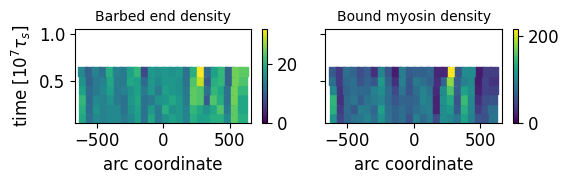

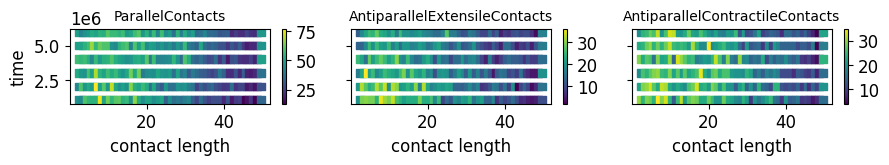

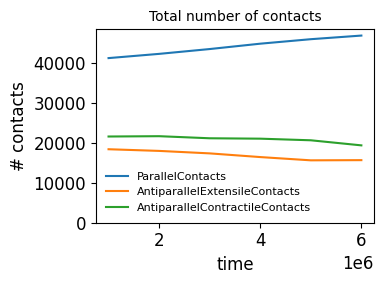

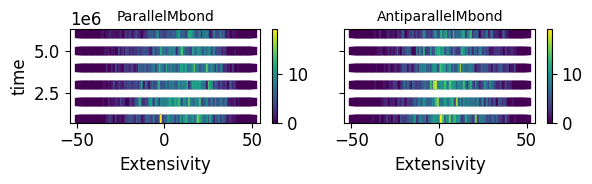

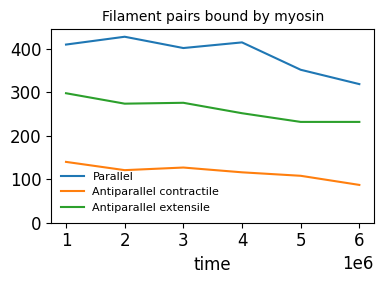

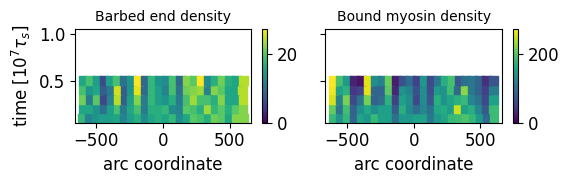

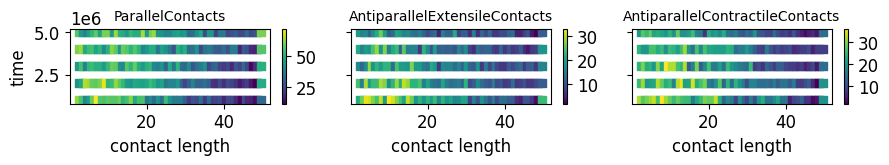

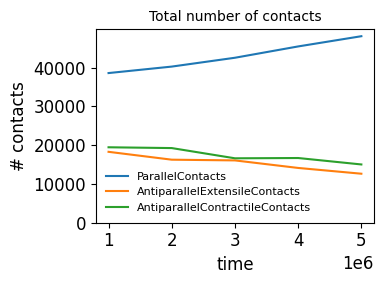

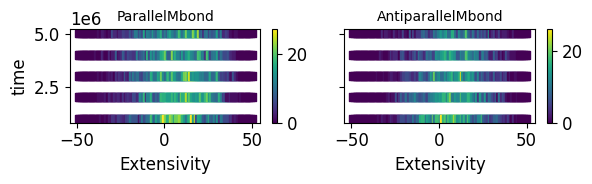

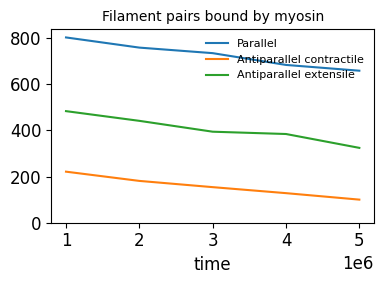

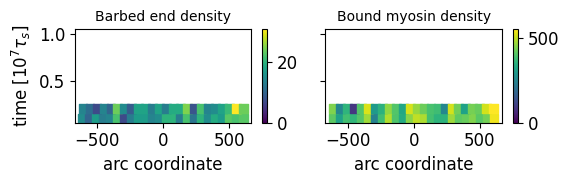

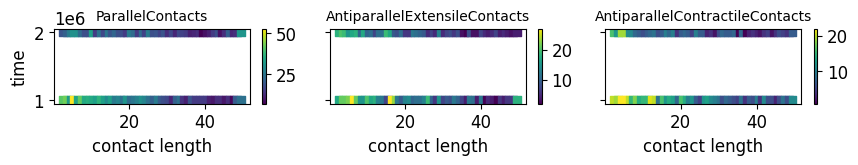

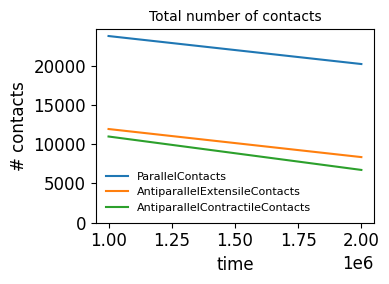

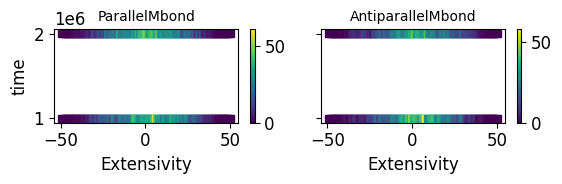

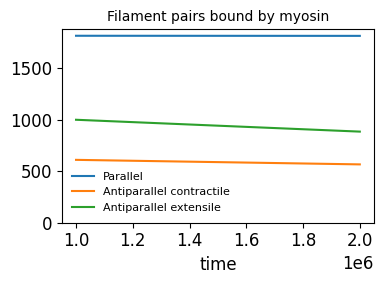

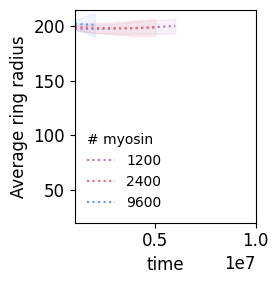

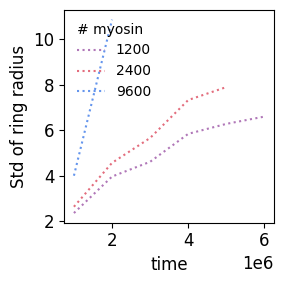

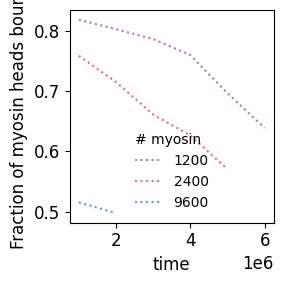

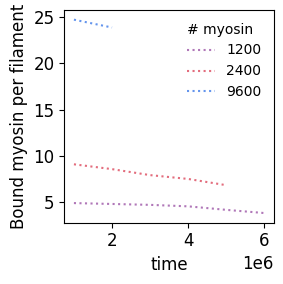

In [96]:
keys = [k for k in dicR.keys()]
keys.sort(key=sortbyparams)

timeHistList = [1e6, 5e6, 10e6]
RringPlot = [200.0]
lFPlot= [50]

LzPlot= [10.0]
nMplot=[1200,2400,4800,9600]
eAAplot=[1.0]
pMWplot=[1]
pMDplot  = [0.00001]
pMDEplot = [1]

SaveFigFlag=True
SaveFigFlagIndividual=True

counter=0
UsedKeysString = ''

for i,key in enumerate(keys):    
    dffull = dicR[key]
    par = getparams(key)
    Lz=par['Lz']
    Rcylout=par['Rcylout']
    lF=par['lF']
    nF=par['nF']
    nM=par['nM']
    eAA = par['eAA']
    
    if par['pMDE']==0:
        fmt = '--'
    elif par['pMDE']<=par['pMD']:
        fmt = '-'
    else:
        fmt = ':'
    
    if not ((par['Rring'] in RringPlot) and (Lz in LzPlot) and (lF in lFPlot) and (nM in nMplot) and (eAA in eAAplot) and (par['pMW'] in pMWplot) and\
            (par['geom']=='rw') and (par['nF']==400) and (par['pMD'] in pMDplot) and (par['pMDE'] in pMDEplot)  ):
        continue
    print(key)
    counter+=1
    
    UsedKeysString += key if UsedKeysString=='' else (', '+key)
    
    #label="nF{:d}-{:d} nM{:d} pMD{:g} pMDE{:g} pMW{:g}".format(par['nF'],par['lF'],par['nM'],par['pMD'],par['pMDE'],par['pMW'])
    label='{:d}'.format(nM)
        
    plt.figure(1, figsize=(3,3))
    df = dffull[dffull.RingIntactFlag==1]
    plt.plot(df.time, df.Ravg,fmt, color=nM2colorDic[nM], label=label)
    plt.fill_between(df.time, df.Ravg-df.Rstd, df.Ravg+df.Rstd, color=nM2colorDic[nM], alpha=0.1)
    #dfbroken = dffull[dffull.RingIntactFlag==0]
    #if len(dfbroken)>0:
    #    plt.plot(dfbroken.iloc[0].time, dfbroken.iloc[0].Ravg, 'x', color=nM2colorDic[nM], label=None, ms=10)

    plt.figure(2, figsize=(3,3))
    plt.plot(df.time, df.Rstd, fmt, color=nM2colorDic[nM], label=label)

    plt.figure(3, figsize=(3,3))
    FractionMB = np.array([x[1].sum() for x in df.histMBdensity.values])/(2*nM)
    plt.plot(df.time, FractionMB, fmt, color=nM2colorDic[nM], label=label )
    
    plt.figure(4, figsize=(3,3))
    FractionMB = np.array([x[1].sum() for x in df.histMBdensity.values])/(nF)
    plt.plot(df.time, FractionMB, fmt, color=nM2colorDic[nM], label=label )
    
    '''
    #plt.figure(1000+i)
    fig100,axs=plt.subplots(1,len(timeHistList),sharey=True, figsize=(3*len(timeHistList),3))
    plt.annotate(key, (0.5,1.1), fontsize=10, va='center', ha='center', xycoords='figure fraction')
    for i,timeHist in enumerate(timeHistList):
        plt.sca(axs[i])
        if len(df[df.time==timeHist])==0:
            continue
        plt.ylabel('Density')
        plt.xlabel(r'$\theta\ [rad]$')
        plt.title('ts{:.0f}'.format(timeHist), fontsize=10)

        histAdensity = df[df.time==timeHist].histAdensity.iloc[0]
        Ravg = df[df.time==timeHist].Ravg.iloc[0]
        #plt.stairs(histAdensity[1]/lF, edges=histAdensity[0], lw=2, label='actin / lF', color='forestgreen')
        plt.plot(bin2midpoint(histAdensity[0]), histAdensity[1]/(lF*nF), ':', color='forestgreen', label='actin / lF', lw=1)

        histABdensity = df[df.time==timeHist].histABdensity.iloc[0]
        #plt.stairs(histABdensity[1], edges=histABdensity[0], lw=2, label='actin barbed', color='limegreen')
        plt.plot(bin2midpoint(histABdensity[0]), histABdensity[1]/nF, color='limegreen', label='actin barbed', lw=2)

        histAPdensity = df[df.time==timeHist].histAPdensity.iloc[0]
        #plt.stairs(histAPdensity[1], edges=histAPdensity[0], lw=2, label='actin pointed', color='darkgreen')
        plt.plot(bin2midpoint(histAPdensity[0]), histAPdensity[1]/nF, color='darkgreen', label='actin pointed', lw=2)

        histMUdensity = df[df.time==timeHist].histMUdensity.iloc[0]
        #plt.stairs(histMUdensity[1], edges=histMUdensity[0], lw=2, label='myosin unbound', color='navy')
        plt.plot(bin2midpoint(histMUdensity[0]), histMUdensity[1]/nM, color='navy', label='myosin unbound', lw=1)

        histMBdensity = df[df.time==timeHist].histMBdensity.iloc[0]
        #plt.stairs(histMBdensity[1], edges=histMBdensity[0], lw=2, label='myosin bound', color='royalblue')
        plt.plot(bin2midpoint(histMBdensity[0]), histMBdensity[1]/nM, color='royalblue', label='myosin bound', lw=2)
        
        if i==0:
            plt.legend(fontsize=8)

    '''        
    
    plotList = ['histABdensity', 'histMBdensity'] # 'histAPdensity'
    fig101,axs=plt.subplots(1,len(plotList),sharey=True, figsize=(3*len(plotList),2))
    for j, s in enumerate(plotList): 
        if s not in df:
            continue
        plt.sca(axs[j])
        data = []
        for i,dfline in df.iterrows():
            Ravg = dfline.Ravg
            time = dfline.time / 1e7
            midpoints = bin2midpoint( dfline[s][0]*Ravg )
            hist = dfline[s][1]
            for i in range(len(hist)):
                data.append( [midpoints[i], time, hist[i]] )
        if len(data)==0:
            continue
        data = np.array(data)
        plt.scatter(data[:,0], data[:,1], c=data[:,2], s=40, marker='s', vmin=0)
        plt.colorbar()
        plt.xlabel('arc coordinate')
        if j==0:
            plt.ylabel(r'time [$10^7 \tau_s$]')
        plt.title(string2titleDic[s], fontsize=10)
    plt.ylim((0.05,1.05))
    plt.tight_layout()
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/Paper/HistAB-AP-MB_{:s}.pdf'.format(folder,key))
    #plt.show()
    #plt.close(fig101)
    
    
    fig102,axs=plt.subplots(1,3,sharey=True, figsize=(3*3,2))
    for j, s in enumerate(['histParallelContacts','histAntiparallelExtensileContacts', 'histAntiparallelContractileContacts']):
        plt.sca(axs[j])
        data = []
        for i,dfline in df.iterrows():
            if len(dfline[s])==0:
                continue
            time = dfline.time
            midpoints = bin2midpoint( dfline[s][0] )
            hist = dfline[s][1]
            for i in range(2,len(hist)):
                data.append( [midpoints[i], time, hist[i] ] )
        data = np.array(data)
        plt.scatter(data[:,0], data[:,1], c=data[:,2], s=30, marker='s')
        plt.colorbar()
        plt.xlabel('contact length')
        if j==0:
            plt.ylabel('time')
        plt.title(s[4:], fontsize=10)
    plt.tight_layout()
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/Paper/HistContact_{:s}.pdf'.format(folder,key))
    #plt.show()
    #plt.close(fig102)

    fig103,axs=plt.subplots(1,1,sharey=True, figsize=(4,3))
    for j, s in enumerate(['histParallelContacts','histAntiparallelExtensileContacts', 'histAntiparallelContractileContacts']):
        data = []
        for i, dfline in df.iterrows():
            if len(dfline[s])==0:
                continue
            time = dfline.time
            hist = dfline[s][1]
            histsum = sum(hist*dfline[s][0][:-1])
            data.append([time,histsum])
        data = np.array(data)
        plt.plot(data[:,0], data[:,1], label=s[4:])
    plt.ylabel('# contacts')
    plt.xlabel('time')
    plt.title('Total number of contacts', fontsize=10)
    plt.legend(frameon=False, fontsize=8)
    plt.ylim(0,None)
    plt.tight_layout()
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/Paper/ContactsvsTime_{:s}.pdf'.format(folder,key))
    #plt.show()
    #plt.close(fig103)

    fig104,axs=plt.subplots(1,2,sharey=True, figsize=(6,2))
    for j, s in enumerate(['histParallelMbond','histAntiparallelMbond']):
        plt.sca(axs[j])
        data = []
        for i,dfline in df.iterrows():
            if len(dfline[s])==0:
                continue
            time = dfline.time
            midpoints = bin2midpoint( dfline[s][0] )
            hist = dfline[s][1]
            for i in range(1,len(hist)):
                data.append( [midpoints[i], time, hist[i] ] )
        data = np.array(data)
        plt.scatter(data[:,0], data[:,1], c=data[:,2], s=30, marker='s')
        plt.colorbar()
        plt.xlabel('Extensivity')
        if j==0:
            plt.ylabel('time')
        plt.title(s[4:], fontsize=10)
    plt.tight_layout()
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/Paper/HistMbonds_{:s}.pdf'.format(folder,key))
    #plt.show()
    #plt.close(fig104)

    # MBonds
    fig105,axs=plt.subplots(1,1,sharey=True, figsize=(4,3))
    times, histsumParallel, histsumContractile, histsumExtensile = [],[],[],[]
    for i, dfline in df.iterrows():
        times.append(dfline.time)
        assert (dfline['histParallelMbond'][0]==dfline['histAntiparallelMbond'][0]).all()
        s = 'histParallelMbond'
        midpoints = bin2midpoint( dfline[s][0] )
        counts = dfline[s][1]
        histsumParallel.append(sum(counts))
        s = 'histAntiparallelMbond'
        midpoints = bin2midpoint( dfline[s][0] )
        counts = dfline[s][1]
        assert len(counts[0:lF])==len(counts[lF+1:])
        histsumContractile.append(sum(counts[0:lF]))
        histsumExtensile.append(sum(counts[lF+1:]))
    plt.plot(times, histsumParallel, label='Parallel')
    plt.plot(times, histsumContractile, label='Antiparallel contractile')
    plt.plot(times, histsumExtensile, label='Antiparallel extensile')
    #plt.ylabel('# double-bound Myo')
    plt.xlabel('time')
    plt.title('Filament pairs bound by myosin', fontsize=10)
    plt.legend(frameon=False, fontsize=8)
    plt.ylim(0,None)
    plt.tight_layout()
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/Paper/MbondsvsTime_{:s}.pdf'.format(folder,key))
    #plt.show()
    #plt.close(fig105)
    
    '''
    fig105,axs=plt.subplots(1,1,figsize=(4,3))
    plt.annotate(key, (0.5,1.1), fontsize=10, va='center', ha='center', xycoords='figure fraction')
    colors = ['k','b','g','orange','y','r']
    timesPlot = [1000000, 1100000, 1200000, 1300000, 1400000, 1500000]
    for i,timeHist in enumerate(timesPlot):
        dfline = df[df.time==timeHist].iloc[0]
        if len(dfline.DeltaExtensivityRef)==0:
            continue
        plt.ylabel('Delta Extensivity')
        plt.xlabel('Initial Extensivity')
        label = 'ts{:d}'.format(timeHist)
        InitialExtensivity = dfline.DeltaExtensivityRef.InitialExtensivity
        DeltaSum = dfline.DeltaExtensivityRef.DeltaSum
        #DeltaStd = dfline.DeltaExtensivityRef.DeltaStd
        plt.plot(InitialExtensivity, DeltaSum, '-', color=colors[i], label=label, lw=1)
        #plt.fill_between(InitialExtensivity, DeltaMean-DeltaStd, DeltaMean+DeltaStd, color=colors[i], alpha=0.2)
    plt.legend(fontsize=8)
    plt.title('# steps forward in 1e5 ts, before first detachment', fontsize=10)
    plt.ylim(0,None)
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/Paper/DeltaExtensivityRef_{:d}ts_{:s}.pdf'.format(folder,len(timesPlot),key))
    
    fig106,axs=plt.subplots(1,1, figsize=(4,2))
    data = []
    for i, dfline in df.iterrows():
        if len(dfline.DeltaExtensivityRef)==0:
            continue
        time = dfline.time
        InitialExtensivity = dfline.DeltaExtensivityRef.InitialExtensivity
        DeltaSum = dfline.DeltaExtensivityRef.DeltaSum
        for i in range(1,len(hist)):
            data.append( [InitialExtensivity[i], time, DeltaSum[i] ] )
    data = np.array(data)
    plt.scatter(data[:,0], data[:,1], c=data[:,2], s=10, marker='s')
    plt.colorbar()
    plt.xlabel('Initial Extensivity')
    if j==0:
        plt.ylabel('time')
    plt.title('# steps forward in 1e5 ts, before first detachment', fontsize=10)
    plt.tight_layout()
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/Paper/HistDeltaExtensivityRef_{:s}.pdf'.format(folder,key))
    

    fig107,axs=plt.subplots(1,1,figsize=(4,3))
    plt.annotate(key, (0.5,1.1), fontsize=10, va='center', ha='center', xycoords='figure fraction')
    colors = ['k','b','g','y','r']
    timesPlot = [1000000, 2000000, 3000000, 4000000]
    for i,timeHist in enumerate(timesPlot):
        dfline = df[df.time==timeHist].iloc[0]
        if len(dfline.DeltaExtensivityCont)==0:
            continue
        plt.ylabel('Delta Extensivity')
        plt.xlabel('Previous Extensivity')
        label = 'ts{:d}'.format(timeHist)
        InitialExtensivity = dfline.DeltaExtensivityCont.PreviousExtensivity
        DeltaSum = dfline.DeltaExtensivityCont.DeltaSum
        #DeltaStd = dfline.DeltaExtensivityCont.DeltaStd
        plt.plot(InitialExtensivity, DeltaSum, '-', color=colors[i], label=label, lw=1)
        #plt.fill_between(InitialExtensivity, DeltaMean-DeltaStd, DeltaMean+DeltaStd, color=colors[i], alpha=0.2)
        plt.title('# steps forward in 1e5 ts, for all Myos', fontsize=10)
        plt.legend(fontsize=8)
        plt.ylim(0,None)
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/Paper/DeltaExtensivityCont_{:s}.pdf'.format(folder,key))
    
    fig108,axs=plt.subplots(1,1, figsize=(4,3))
    data = []
    for i, dfline in df.iterrows():
        if len(dfline.DeltaExtensivityCont)==0:
            continue
        time = dfline.time
        InitialExtensivity = dfline.DeltaExtensivityCont.PreviousExtensivity
        DeltaSum = dfline.DeltaExtensivityCont.DeltaSum
        for i in range(1,len(hist)):
            data.append( [InitialExtensivity[i], time, DeltaSum[i] ] )
    data = np.array(data)
    plt.scatter(data[:,0], data[:,1], c=data[:,2], s=5, marker='s')
    plt.colorbar()
    plt.xlabel('Previous Extensivity')
    if j==0:
        plt.ylabel('time')
    plt.title('# steps forward in 1e5 ts, for all Myos', fontsize=10)
    plt.tight_layout()
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/Paper/HistDeltaExtensivityCont_{:s}.pdf'.format(folder,key))
    '''




if counter>=1:

    assert len(lFPlot)==1
    assert len(RringPlot)==1
    assert len(LzPlot)==1
    assert len(pMWplot)==1
    assert len(pMDplot)==1
    assert len(pMDEplot)==1
    
    stringname = 'Rring{:.0f}_Lz{:.0f}_nF{:d}_pMW{:g}_pMD{:g}_pMDE{:g}'.format(RringPlot[0],LzPlot[0],lFPlot[0],pMWplot[0], pMDplot[0],pMDEplot[0])
    
    plt.figure(1)
    #for timeHist in timeHistList:
    #    plt.plot([timeHist,timeHist],[max(RcyloutPlot)-50, max(RcyloutPlot)],':',lw=0.2,color='k')
    plt.ylabel('Average ring radius')
    plt.xlabel('time')
    plt.ylim((20,215))
    plt.xlim((1e6,10e6))
    plt.legend(fontsize=10,frameon=False,title='# myosin',title_fontsize=10,alignment='left')
    plt.tight_layout()
    if SaveFigFlag: plt.savefig('{:s}/Analysis/Graphs/Paper/RingRadius_{:s}.pdf'.format(folder,stringname), metadata = {'Comment':UsedKeysString})

    plt.figure(2)
    plt.ylabel('Std of ring radius')
    plt.xlabel('time')
    plt.legend(fontsize=10,frameon=False,title='# myosin',title_fontsize=10,alignment='left')
    plt.tight_layout()
    if SaveFigFlag: plt.savefig('{:s}/Analysis/Graphs/Paper/RingRadiusStd_{:s}.pdf'.format(folder,stringname), metadata = {'Comment':UsedKeysString})

    plt.figure(3)
    plt.ylabel('Fraction of myosin heads bound')
    plt.xlabel('time')
    plt.legend(fontsize=10,frameon=False,title='# myosin',title_fontsize=10,alignment='left')
    plt.tight_layout()
    if SaveFigFlag: plt.savefig('{:s}/Analysis/Graphs/Paper/MyosinBoundFraction_{:s}.pdf'.format(folder,stringname), metadata = {'Comment':UsedKeysString})

    plt.figure(4)
    plt.ylabel('Bound myosin per filament') #'Myosin-actin bonds per actin filament')
    plt.xlabel('time')
    plt.legend(fontsize=10,frameon=False,title='# myosin',title_fontsize=10,alignment='left')
    plt.tight_layout()
    if SaveFigFlag: plt.savefig('{:s}/Analysis/Graphs/Paper/MyosinBoundFraction_{:s}.pdf'.format(folder,stringname), metadata = {'Comment':UsedKeysString})



## Plots cw

cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM4800_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM4800_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM9600_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM9600_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-1_110
        0.0
4800.0  0.0
2400.0  0.0
1200.0  0.0


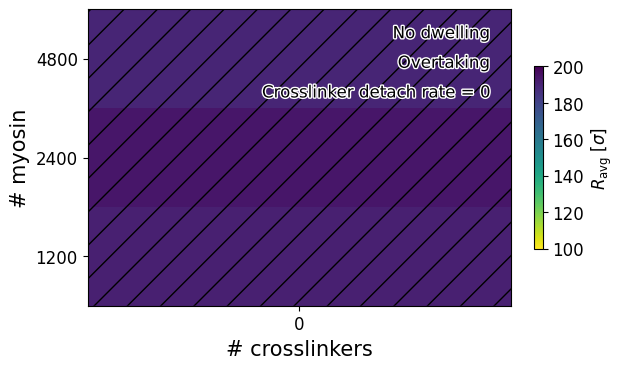

cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM4800_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM4800_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM9600_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM9600_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10

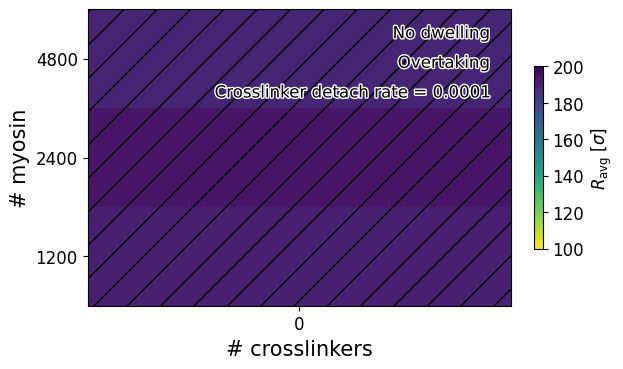

cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM4800_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM4800_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM9600_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM9600_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-1_110
        0.0
4800.0  0.0
2400.0  0.0
1200.0  0.0


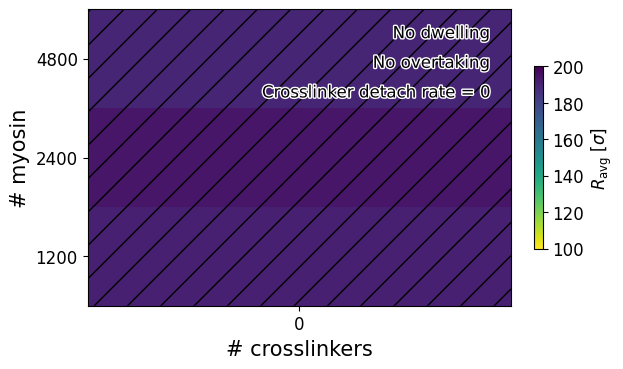

cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM4800_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM4800_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM9600_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM9600_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10

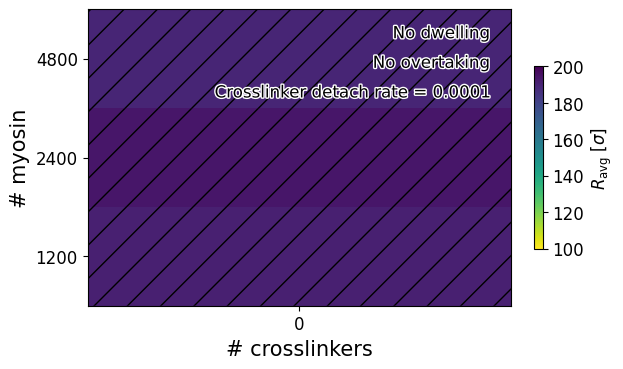

cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM4800_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM4800_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM9600_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM9600_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-1_110
        0.0
9600.0  1.0
4800.0  0.0
2400.0  0.0
1200.0  0.0


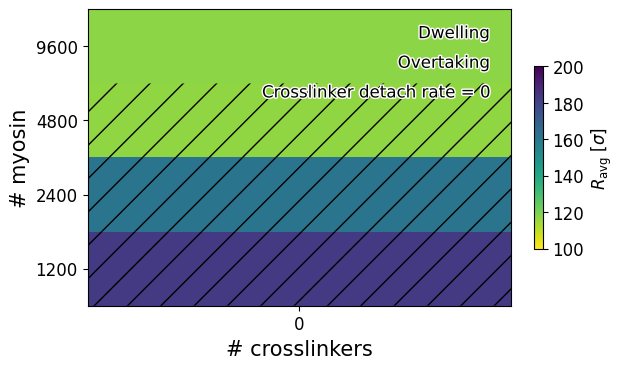

cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM4800_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM4800_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM9600_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM9600_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0

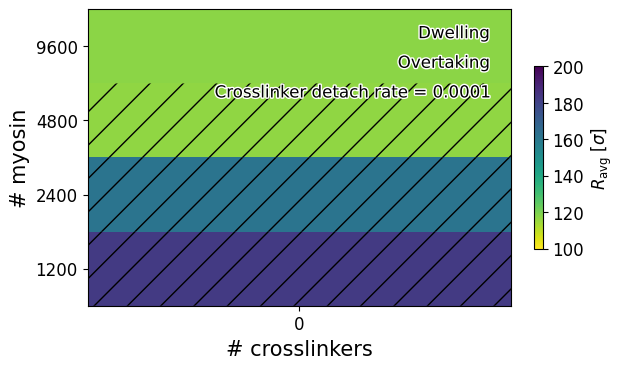

cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM4800_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM4800_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM9600_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM9600_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-1_110
        0.0
9600.0  1.0
4800.0  0.0
2400.0  0.0
1200.0  0.0


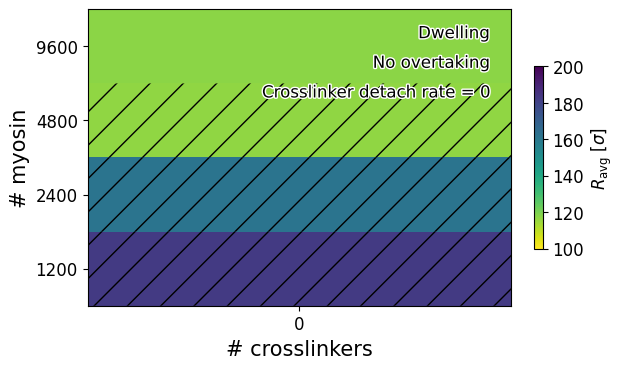

cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM4800_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM4800_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM9600_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM9600_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0

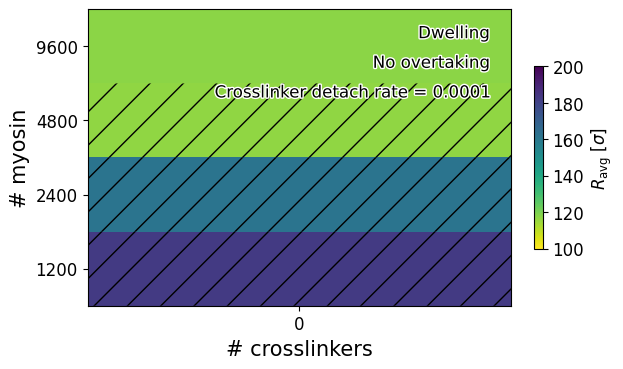

In [33]:
# Plots cw

TimestepThreshold = 7500000 # Only consider files going beyond this timestep

for pMDplot in [0.0001, 0.00001]:
    for pMDEplot in [1,pMDplot]:
        for pMOCplot in [1,0]:
            for pCDplot in [0, pMDplot]:

                data = []
                # get first column for nC=0
                for filestring in dicR.keys():
                    par = getparams(filestring)
                    if par['pMDE']==pMDEplot and par['nC']==0 and par['pMD']==pMDplot:
                        print(filestring)
                        Df = dicR[filestring]
                        if Df.iloc[-1].time<TimestepThreshold:
                            continue
                        its = Df.index[Df['time']==TimestepThreshold].tolist()[0] + 1
                        Ravg = (Df['Ravg'].iloc[its-10:its]).mean()
                        RingIntactFlag = True if Df.RingIntactFlag.iloc[-10:].mean()>0.5 else False
                        data.append([par['nM'],par['nC'],Ravg,RingIntactFlag])
                #get rest
                for filestring in dicR.keys():
                    par = getparams(filestring)
                    if par['pMDE']==pMDEplot  and par['pMOC']==pMOCplot and par['pCD']==pCDplot and par['pMD']==pMDplot:
                        print(filestring)
                        Df = dicR[filestring]
                        if Df.iloc[-1].time<TimestepThreshold:
                            continue
                        its = Df.index[Df['time']==TimestepThreshold].tolist()[0] + 1
                        Ravg = (Df['Ravg'].iloc[its-10:its]).mean()
                        RingIntactFlag = True if Df.RingIntactFlag.iloc[-10:].mean()>0.5 else False
                        data.append([par['nM'],par['nC'],Ravg,RingIntactFlag])
                data = np.array(data)
                if len(data)==0:
                    continue
                #plt.scatter(data[:,0], data[:,1], c=data[:,2], s=1000, marker='s')
                #plt.colorbar()
                
                
                nMlist, nClist, datadfplt = [],[],[]
                nMlist = np.unique(data[:,0]).tolist()
                nClist = np.unique(data[:,1]).tolist()
                dataRavg = np.NaN*np.ones((len(nMlist), len(nClist)))
                dataRingIntactFlag = np.NaN*np.ones((len(nMlist), len(nClist)))
                for x in data:
                    i = nMlist.index(x[0])
                    c = nClist.index(x[1])
                    dataRavg[i,c] = x[2]
                    dataRingIntactFlag[i,c] = x[3]
                dfRavg = pd.DataFrame(dataRavg, index=nMlist, columns=nClist)
                dfRavg = dfRavg.sort_index(ascending=False)
                dfRingIntactFlag = pd.DataFrame(dataRingIntactFlag, index=nMlist, columns=nClist)
                dfRingIntactFlag = dfRingIntactFlag.sort_index(ascending=False)

                # Ravg
                fig1 = plt.figure()
                #plt.imshow(dfPercolatedFlag, alpha=0.1)
                plt.imshow(dfRavg, vmin=par['Rcylin'], vmax=par['Rcylout'], cmap='viridis_r', aspect=len(dfRavg.columns)/len(dfRavg.index)*0.7 )
                ax = plt.gca()
                ax.set_yticks(np.arange(len(dfRavg.index)), labels=[int(x) for x in dfRavg.index])
                ax.set_xticks(np.arange(len(dfRavg.columns)), labels=[int(x) for x in dfRavg.columns])
                plt.ylabel('# myosin', size=15)
                plt.xlabel('# crosslinkers',size=15)
                colorbar = plt.colorbar(ax=ax,fraction=0.02,label=r'$R_\mathrm{avg}\ [\sigma$]')
                #plt.pcolor(np.arange(len(dfglobalDotprod.columns)), np.arange(len(dfglobalDotprod.index)), dfPercolatedFlag, hatch='/', alpha=0.5)
                #plt.contourf(dfPercolatedFlag, 1, hatches=['', '//'], alpha=0.5, colors=None)
                print(dfRingIntactFlag)
                y, x = np.mgrid[slice(0-0.5, len(dfRingIntactFlag.index) + 1-0.5, 1), slice(-0.5, len(dfRingIntactFlag.columns) + 1-0.5, 1)]
                zm = np.ma.masked_greater(np.array(dfRingIntactFlag), 0.5)
                plt.pcolor(x, y, zm, hatch='/', alpha=0.)  # hashed means PercolatedFlag<0.5, i.e. more than 1 cluster in sims
                
                if pMDEplot==pMDplot:
                    textDwelling = 'Dwelling'
                elif pMDEplot==1:
                    textDwelling = 'No dwelling'
                else:
                    textDwelling = 'Partial dwelling {:g}'.format(pMDEplot)
                
                if pMOCplot==1:
                    textOvertaking = 'Overtaking'
                elif pMOCplot==0:
                    textOvertaking = 'No overtaking'
                else:
                    textOvertaking = 'Partial overtaking ({:g})'.format(pMOCplot)
                    
                textpCD = 'Crosslinker detach rate = {:g}'.format(pCDplot)
                plt.annotate(textDwelling, xy=(0.95,0.95), xycoords='axes fraction', ha='right', va='top', size=12, path_effects=[pe.withStroke(linewidth=2, foreground="white")])
                plt.annotate(textOvertaking, xy=(0.95,0.85), xycoords='axes fraction', ha='right', va='top', size=12, path_effects=[pe.withStroke(linewidth=2, foreground="white")])
                plt.annotate(textpCD, xy=(0.95,0.75), xycoords='axes fraction', ha='right', va='top', size=12, path_effects=[pe.withStroke(linewidth=2, foreground="white")])
                plt.tight_layout()

                plt.savefig('{:s}/Analysis/Graphs/Ravg_pMD{:g}_pMDE{:g}_pCD{:g}_pMOC{:g}.pdf'.format(folder,pMDplot,pMDEplot,pCDplot,pMOCplot))
                plt.savefig('{:s}/Analysis/Graphs/Ravg_pMD{:g}_pMDE{:g}_pCD{:g}_pMOC{:g}.pdf'.format(folder,pMDplot,pMDEplot,pCDplot,pMOCplot),transparent=True)
                plt.show()
                plt.close()

    